# Load utils & data

In [29]:
import os, glob, json
import pickle, dill
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir) ## CHANGE CSID
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
STANZA_DIR

john10
scr1
/john10/scr1/yiweil


'/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'

In [30]:
ryan_values = dill.load(open('/sailhome/ryantran/d_file.txt','rb'))

PermissionError: [Errno 13] Permission denied: '/sailhome/ryantran/d_file.txt'

In [2]:
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = f.read().splitlines()
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

Excluding URLs from 43 domains:
['', 'addons.mozilla', 'vimeo.com', 'scribd.com', 'i2.wp.com', 'gfycat.com', 'redditenhacementsuite', 'www\\.fanfiction\\.net', 'ri.search.yahoo.com', 'i0.kym-cdn.com', 'qph.ec.quoracdn.net', 'youtu', 'ff2ebook.com', 'open.spotify.com', 'i.ytimg.com', 'voat.co', 'soundcloud.com', 'twitter', '25.media.tumblr.com', 'lmgtfy.com', 'encrypted-tbn0.gstatic.com', 's-media-cache-ak0.pinimg', 's3.amazonaws.com', 'instagram.com', 'i216.photobucket.com', 'greasyfork', 'media.giphy.com', 'img1.wikia.nocookie.net', 'pastebin', 'images.app.goo.gl', '4.bp.blogspot', 'reddit', 'i.pinimg.com', 'facebook.com', 'youtube', 'duckduckgo.com', 'i.redd.it', 'google', 'lh3.googleusercontent.com', 'knowyourmeme.com', 'mashable.com', 'chrome.google', 'imgur']


In [3]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample','full_cmv'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
        print("Distribution of generic comments:")
        print(Counter([utt.meta['is_generic'] for utt in corp_to_analyze[corp_name].iter_utterances()
              if utt.id[:2]=='t1']))
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of valid utterances:")
        print(Counter([is_valid_utt(utt) for utt in corp_to_analyze['full_cmv'].iter_utterances()
                       if utt.id[:2]=='t1']))
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))
        
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['text_urls'] = get_urls(utt.text)
            utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
            utt.meta['num_urls'] = len([x for x in utt.meta['url_domains'] 
                                        if (x[0] not in domains_to_exclude)
                                        and (x[1] not in domains_to_exclude)])
            utt.meta['has_url'] = utt.meta['num_urls'] > 0

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering moderators and speakers with usernames ending in '-bot'...
Found 3155486 non-deleted/removed utterances not written by a bot or moderator.


Annotating generic utterances from full_cmv...


3243830it [00:26, 124555.44it/s]


Filtering to 2932326 non-generic comments.
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Distribution of generic comments:
Counter({False: 2905983, True: 253589})
Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:26, 37457.91it/s]


Annotating removed/deleted comments in full_cmv...


3243830it [00:26, 120788.75it/s]


Annotating path information w/ version ignoring OP...


3243830it [00:47, 67821.29it/s]


Distribution of valid utterances:
Counter({True: 2824502, False: 335070})
Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


3243830it [02:39, 20359.33it/s]


In [4]:
def get_utt(id_, corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(id_)

def is_valid_utt(utt):
    """
    Returns whether an utterance meets the following criteria: 1) is not removed/deleted; 2) is not empty; 3) is not generic; 
    4) is not written by a bot/moderator.
    """
    return (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (not utt.meta['is_generic']) \
       and (not utt.meta['written_by_bot']) 

def meets_datapoint_criteria(utt, corp=corp_to_analyze['full_cmv']):
    return is_valid_utt(utt) and (not is_OP_utt(corp, utt)) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))

# Indirect empirical evidence: (SCI ENTITY_NSUBJ, VERB) tuples

We'll try operationalizing indirect empirical evidence-content in comments by measuring the occurrence of tuples such as "data shows", "research suggests", "scientists say".

## Create starting lexicons of SCI ENTITIES and VERBS to look for

### Use DeSmog lexicons as starting point; augment w/ Empath 

In [5]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

desmog_feats_dict.keys()

dict_keys(['ANTI_WORDS', 'AFFIRM_WORDS', 'SCI_WORDS', 'VERBS_WORDS', 'DOUBT_WORDS', 'PRO_WORDS'])

In [11]:
#desmog_feats_dict['SCI_WORDS']

In [14]:
#desmog_feats_dict['VERBS_WORDS']

In [6]:
SEED_SCI_ENTS = {
    'scientist','physicist','scholar','climatologist','economist','paleoclimatologist','researcher','expert',
    'publication','study','paper','article',
    'evidence','science','research','data','measurement','analysis',
    'observation','experiment','technique','discovery','test','method','model'}

SEED_VERBS = set(desmog_feats_dict['VERBS_WORDS']).intersection(set(desmog_feats_dict['AFFIRM_WORDS']))

In [19]:
SEED_VERBS#.intersection(set(desmog_feats_dict['AFFIRM_WORDS']))

{'acknowledge',
 'admit',
 'affirm',
 'agree',
 'certify',
 'concede',
 'conclude',
 'confirm',
 'corroborate',
 'demonstrate',
 'discover',
 'forget',
 'indicate',
 'know',
 'learn',
 'notice',
 'point_out',
 'realize',
 'recall',
 'remember',
 'reveal',
 'see',
 'show',
 'suspect',
 'uncover',
 'understand',
 'verify'}

In [25]:
with open('householder_stems.txt','r') as f:
    HOUSEHOLDER_STEMS = set(f.read().splitlines())
HOUSEHOLDER_STEMS.add('point_out')
set(HOUSEHOLDER_STEMS).difference(SEED_VERBS)

{'abide',
 'accept',
 'add',
 'adduce',
 'adjudge',
 'adjure',
 'admonish',
 'adumbrate',
 'advance',
 'advertise',
 'advise',
 'advocate',
 'affect',
 'air',
 'allege',
 'allow',
 'announce',
 'annunciate',
 'answer',
 'anticipate',
 'appear',
 'appreciate',
 'apprehend',
 'apprise',
 'approve',
 'argue',
 'arrange',
 'articulate',
 'ascertain',
 'ask',
 'assert',
 'assess',
 'assume',
 'assure',
 'augur',
 'aver',
 'avouch',
 'avow',
 'bear',
 'befall',
 'beg',
 'begin',
 'behold',
 'believe',
 'bespeak',
 'bet',
 'betoken',
 'betray',
 'boast',
 'brag',
 'bring',
 'broadcast',
 'cable',
 'calculate',
 'call',
 'can',
 'care',
 'catch',
 'cause',
 'caution',
 'challenge',
 'chance',
 'charge',
 'check',
 'choose',
 'circulate',
 'cite',
 'claim',
 'come',
 'commence',
 'communicate',
 'complain',
 'comprehend',
 'compute',
 'conceive',
 'confess',
 'confide',
 'conjecture',
 'consider',
 'construe',
 'contemplate',
 'contend',
 'contest',
 'continue',
 'contribute',
 'controvert',
 '

In [373]:
SEED_VERBS.difference(set(HOUSEHOLDER_STEMS))

set()

In [20]:
#SEED_VERBS.intersection(set(desmog_feats_dict['DOUBT_WORDS']))

In [8]:
from empath import Empath
lexicon = Empath()

lexicon.create_category("science_ents_nyt",list(SEED_SCI_ENTS),model="nytimes")
lexicon.create_category("science_ents_reddit",list(SEED_SCI_ENTS),model="reddit")
lexicon.create_category("science_ents_fic",list(SEED_SCI_ENTS),model="fiction")

["researcher", "new_research", "scientist", "physicist", "Dr._Wilson", "Dr._Collins", "other_scientists", "research_team", "new_finding", "genetics", "astrophysicist", "research", "hypothesis", "other_researchers", "new_findings", "molecular_biology", "science", "scientific", "scientific_literature", "Dr._Smith", "astronomer", "study", "recent_research", "new_theory", "geneticist", "molecular", "computer_simulations", "cold_fusion", "statistical_analysis", "methodology", "research_project", "analysis", "Dr._White", "experiments", "scientific_work", "Dr._Anderson", "the_Human_Genome_Project", "new_analysis", "the_Massachusetts_Institute_of_Technology", "the_University_of_California_at_San_Diego", "particle_physics", "Dr._Friedman", "biology", "the_California_Institute_of_Technology", "paleontologist", "Dr._Brown", "studies", "new_study", "evolutionary", "new_technique", "the_University_of_California_at_Berkeley", "researchers", "analyses", "cosmology", "Dr._Miller", "human_genome_projec

In [7]:
ents_to_add = {'researcher','scientist','physicist','astrophysicist','research','geneticist','statistician',
              'paleontologist','biologist','astronomer','science','sociologist','anthropologist','geologist',
              'research_team','expert','theorist','microbiologist','geographer','professor','zoologist',
              'mathematician','Dr.','neuroscientist','research_project','ecologist','chemist','cosmologist',
              'biology','neuroscience','research_group','institute','geophysicist','astrophysics','demographer',
              'epidemiology','neurobiologist','astronomy','anthropology','immunology','study','epidemiologist',
              'linguistics','climatologist','animal_behavior','toxicologist','biochemistry','oceanographer',
              'historian','immunologist','archaeologist','microbiology','scholar','entomologist','report',
              'sociologist','thesis','scientific_work','scientific_literature','dissertation','article',
              'scientific_community','scientific_result','scientific_method','scientific_methodology','historian',
              'academic_literature','academic_world','finding','nobel_laureate','evidence','analysis','psychology',
              'experiment','record','calculation','statistic','statistics','survey','researching','manuscript',
              'specialist','stats','measurement','scientific_work','simulation','technique','growing_body',
              'abstract','scientific_process','scientific_result','empirical_result','experimental_result',
              'calculation','assessment','database','dataset','record','datum','scholarship'}

SCI_ENTS = SEED_SCI_ENTS | ents_to_add
print(len(f"Using set of {len(SCI_ENTS)} scientific entities."))

37


In [6]:
with open('sci_ents.txt','w') as f:
    for e in SCI_ENTS:
        f.write(e+'\n')

## Examine distributions of tuples of interest in CMV corpus

Eventual criteria:
* 1. lemma from `SCI_ENTS` 
* 2. has `nsubj` dependency label (and `noun` as POS tag?)
* 3. head word has `verb` POS tag (or other related tags?) and lemma belongs to `SEED_VERBS`

Criterion 1 will inform the exact conditions for criterion 2, which will in turn inform the set of verbs to use for criterion 3.

### Criterion 1: First find SCI_ENTS; then examine dep. label and POS tag distributions

In [8]:
mwe_sci_ents_dict = {
    'research': {'project','group','team','community','process','result','method','methodology',
                'field','organization','organisation','body','institution'},
    'scientific': {'literature','result','method','methodology','work','community','consensus','understanding',
                  'process','world','field','conclusion','law','organization','organisation','body','institution',
                  'inquiry','investigation','theory','fact','knowledge','journal','perspective',
                  'principle','view','argument','breakthrough','answer','standpoint','reasoning',
                  'claim','discipline','proof','explanation','information','opinion','discourse',
                  'viewpoint','hypothesis','authority','position','theory','model','evidence'},
    'academic': {'world','literature','consensus','understanding','community','work','result','field',
                'organization','organisation','body','institution','inquiry','investigation',
                'discipline','theory'},
    'nobel': {'laureate'},
    'animal': {'behavior'},
    'empirical': {'result','evidence','validation','fact','claim','argument','testing','proof','information',
                 'model'},
    'experimental': {'result'},
    'growing': {'body'}
}

mwes = ['_'.join([initial,ending]) 
 for initial in mwe_sci_ents_dict
 for ending in mwe_sci_ents_dict[initial]]
print(len(mwes), mwes)

87 ['research_process', 'research_body', 'research_group', 'research_field', 'research_methodology', 'research_team', 'research_organization', 'research_community', 'research_method', 'research_institution', 'research_project', 'research_result', 'research_organisation', 'scientific_opinion', 'scientific_fact', 'scientific_community', 'scientific_method', 'scientific_reasoning', 'scientific_perspective', 'scientific_proof', 'scientific_theory', 'scientific_world', 'scientific_organisation', 'scientific_knowledge', 'scientific_body', 'scientific_methodology', 'scientific_claim', 'scientific_view', 'scientific_principle', 'scientific_literature', 'scientific_investigation', 'scientific_consensus', 'scientific_discipline', 'scientific_answer', 'scientific_conclusion', 'scientific_position', 'scientific_field', 'scientific_breakthrough', 'scientific_model', 'scientific_viewpoint', 'scientific_hypothesis', 'scientific_institution', 'scientific_argument', 'scientific_discourse', 'scientific_

In [10]:
sci_ent_tuples = defaultdict(list)
mwe_sci_ent_candidates = defaultdict(list)

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if not is_empty_utt(utt):
        json_obj = get_stanza_jsonstream(utt,
                                         stanza_dir='/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed')
        for ix_sent,sent in enumerate(json_obj['parse']):
            for ix_word,word in enumerate(sent):
                if word['lemma'] in SCI_ENTS:
                    dep = word['deprel']
                    pos = word['upos']
                    head_id = int(word['head'])
                    head = sent[head_id-1]
                    head_lemma = head['lemma']
                    head_dep = head['deprel']
                    head_pos = head['upos']
                    sci_ent_tuples[utt.id].append({'id':utt.id,
                                                   'sent_ix':ix_sent,
                                                   'word_ix':ix_word,
                                                   'lemma':word['lemma'],
                                                   'dep':dep,
                                                   'pos':pos,
                                                   'head':head_lemma,
                                                   'head_dep':head_dep,
                                                   'head_pos':head_pos})
                elif word['lemma'] in mwe_sci_ents_dict:
                    #print(f"Found possible MWE sci ent with beginning lemma {word['lemma']}...")
                    # see if next word completes a MWE SCI ENT
                    if ix_word+1 <= len(sent)-1:
                        #print("\tNext word index within bounds.")
                        next_word = sent[ix_word+1]
                        #print("\tNext word lemma:",next_word['lemma'])
                        mwe_sci_ent_candidates[word['lemma']].append(next_word['lemma'])
                        if next_word['lemma'] in mwe_sci_ents_dict[word['lemma']]:
                            #print("\tMWE match found!")
                            dep = next_word['deprel']
                            pos = next_word['upos']
                            head_id = int(next_word['head'])
                            head = sent[head_id-1]
                            head_lemma = head['lemma']
                            head_dep = head['deprel']
                            head_pos = head['upos']
                            sci_ent_tuples[utt.id].append({'id':utt.id,
                                                           'sent_ix':ix_sent,
                                                           'word_ix':ix_word,
                                                           'lemma':'_'.join([word['lemma'],next_word['lemma']]),
                                                           'dep':dep,
                                                           'pos':pos,
                                                           'head':head_lemma,
                                                           'head_dep':head_dep,
                                                           'head_pos':head_pos})

224927it [2:44:31, 26.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

242577it [2:56:17, 18.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

259409it [3:07:21, 30.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limi

936302it [10:39:06, 25.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

954861it [10:51:39, 22.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

973781it [11:04:17, 18.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_l

1630306it [21:23:07, 14.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

1644840it [21:38:26, 20.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

1657757it [21:51:40, 15.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rat

2251757it [32:13:54, 17.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2264303it [32:26:56, 10.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2283790it [32:46:54, 14.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rat

2865493it [42:55:37, 22.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2878878it [43:09:22, 12.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2892380it [43:23:31, 12.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rat

Iteratively augment MWE expressions by examining collocations with single-word SCI ENTS.

In [104]:
# filtered_candidates = {}
# for initial in mwe_sci_ent_candidates.keys():
#     print(initial)
#     counts_df = pd.DataFrame(Counter(mwe_sci_ent_candidates[initial]),index=[0]).T
#     filtered_counts_df = counts_df.loc[~counts_df.index.isin(mwe_sci_ents_dict[initial] | SCI_ENTS)]\
#           .sort_values(0,ascending=False)
#     print(filtered_counts_df)
#     filtered_candidates[initial] = filtered_counts_df.loc[filtered_counts_df[0] >= 5].index.values
#     print('*'*20)

Need to also deduplicate tuples counted multiple times because they are identified in both SWEs and MWEs (e.g., see rows 2+3 below):

In [12]:
flattened_sci_ent_tuples = flatten(sci_ent_tuples.values())
all_sci_ent_tups = pd.DataFrame({
    key: [tup[key] for tup in flattened_sci_ent_tuples]
    for key in flattened_sci_ent_tuples[0].keys()
})
print(len(all_sci_ent_tups))
all_sci_ent_tups.head()

785523


,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
0,t1_czbzlk5,1,1,science,obl,NOUN,have,root,VERB
1,t1_czbzlk5,1,9,observation,obl,NOUN,base,acl,VERB
2,t1_czbzlk5,2,1,observation,nsubj,NOUN,wrong,root,ADJ
3,t1_czbzlk5,5,10,evidence,obj,NOUN,have,parataxis,VERB
4,t1_czbzlk5,5,24,evidence,obj,NOUN,have,conj,VERB


In [13]:
len(sci_ent_tuples.values())

425927

If:
* 2 rows have the same `id`, `sent_ix`, `dep`, `pos`, `head`, `head_dep`, and `head_pos`,
* `word_ix` differs by 1,
* shared lemma

keep only the one with the lower `word_ix`.

In [14]:
duplicates = all_sci_ent_tups.loc[all_sci_ent_tups.duplicated(
    ['id','sent_ix','dep','pos','head','head_dep','head_pos'],
    keep=False)].reset_index(drop=False,inplace=False)
duplicates.shape

(5532, 10)

In [15]:
real_duplicates = []
for row_ix,row in duplicates.iterrows():
    if row_ix+1 < len(duplicates):
        next_row = duplicates.iloc[row_ix+1]
        if (next_row['id'] == row['id']) and (next_row['sent_ix'] == row['sent_ix']):
            if next_row['word_ix'] - row['word_ix'] == 1:
                if next_row['lemma'] == row['lemma'].split('_')[-1]:
                    real_duplicates.append((row_ix, row_ix+1))
print(len(real_duplicates))

real_duplicates_df = duplicates.loc[duplicates.index.isin(set(flatten(real_duplicates)))]\
                               .reset_index(drop=True,inplace=False)
real_duplicates_df

5


,index,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
0,51477,t1_feur027,0,1,study,nsubj,NOUN,be,root,VERB
1,51478,t1_feur027,0,2,study,nsubj,NOUN,be,root,VERB
2,97417,t1_cswip4w,2,22,evidence,obj,NOUN,find,ccomp,VERB
3,97418,t1_cswip4w,2,23,evidence,obj,NOUN,find,ccomp,VERB
4,335186,t1_f9j9w0c,17,1,evidence,obj,NOUN,require,root,VERB
5,335187,t1_f9j9w0c,17,2,evidence,obj,NOUN,require,root,VERB
6,633160,t1_fdlldjs,0,8,expert,nsubj,NOUN,be,conj,VERB
7,633161,t1_fdlldjs,0,9,expert,nsubj,NOUN,be,conj,VERB
8,749646,t1_dsrt5m2,3,1,study,nsubj,NOUN,be,root,VERB
9,749647,t1_dsrt5m2,3,2,study,nsubj,NOUN,be,root,VERB


In [16]:
duplicate_ixs_to_remove = real_duplicates_df.loc[real_duplicates_df.duplicated(
    ['id','sent_ix','dep','pos','head','head_dep','head_pos'],
    keep='first')]['index'].values
dedup_sci_ent_tups = all_sci_ent_tups.loc[~all_sci_ent_tups.index.isin(duplicate_ixs_to_remove)].copy()
print(len(dedup_sci_ent_tups),len(all_sci_ent_tups))
dedup_sci_ent_tups.head()

785518 785523


,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
0,t1_czbzlk5,1,1,science,obl,NOUN,have,root,VERB
1,t1_czbzlk5,1,9,observation,obl,NOUN,base,acl,VERB
2,t1_czbzlk5,2,1,observation,nsubj,NOUN,wrong,root,ADJ
3,t1_czbzlk5,5,10,evidence,obj,NOUN,have,parataxis,VERB
4,t1_czbzlk5,5,24,evidence,obj,NOUN,have,conj,VERB


In [23]:
corp_to_analyze['full_cmv'].get_utterance('t1_czbzlk5').text

"Evolution is provable in the same way that Newton's laws are provable: not at all. In science, we have a body of facts, based on observations. Those observations can sometimes be wrong, but if they're not, then all we have for certain is a body of facts. Theories help us explain a large set of facts, allowing us to predict and sometimes control. These theories need to be able to make testable, falsifiable predictions in order to be scientific.\n\nHere's the problem though, we can have contrary evidence that shows our theories are wrong, but we can never have enough evidence that our theory is _proven_ true. The word proof has its place in logic, and in mathematics: not in science. There is a reason why the term evidence is used in science, and not proof: because even if all the evidence currently supports the theory, new evidence could come up that causes us to modify, or even abandon the old theory. We don't prove theories are true in science, we provide evidence that is consistent w

In [173]:
#get_stanza_json(corp_to_analyze['matched_cmv_subsample'].get_utterance('t3_i7c1ox'))['parse'][8]

What is the distribution of utterances that even have a scientific entity?

Found 425927 comments (0.13%) with at least 1 SCI ENT.


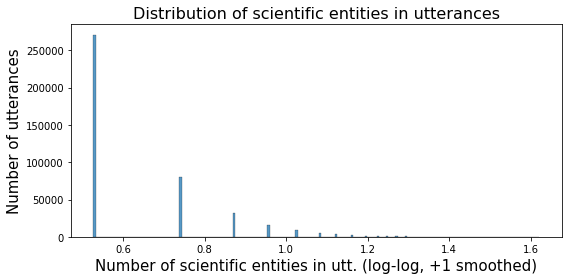

In [17]:
sci_ent_counts_per_utt = dedup_sci_ent_tups.groupby('id').size()
print(f"Found {len(sci_ent_counts_per_utt.apply(lambda x: x>0))} comments \
({round(len(sci_ent_counts_per_utt)/len(corp_to_analyze['full_cmv'].get_utterance_ids()),2)}%) \
with at least 1 SCI ENT.")

to_plot_df = sci_ent_counts_per_utt.apply(lambda x: np.log(np.log(x+1)+1))
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(x=to_plot_df, ax=ax)
ax.set_xlabel("Number of scientific entities in utt. (log-log, +1 smoothed)",fontsize=15)
ax.set_ylabel("Number of utterances",fontsize=15)
ax.set_title("Distribution of scientific entities in utterances",fontsize=16)
plt.tight_layout()
#plt.savefig(os.path.join('figs','dist_sci_ents_matched_cmv_subsample.png'),dpi=200)

And of these, 8332 = 2% are awarded a delta.

In [41]:
Counter([corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['is_awarded_delta']
        for utt_id in set(dedup_sci_ent_tups['id'].values)])

Counter({False: 421026, True: 8332})

What about the distribution of *subtrees* (**excluding comments from OP**) that have a scientific entity? Over time?

In [18]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]

to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],
    'num_sci_ent_tuples': [sum([sci_ent_counts_per_utt[u_id]
                                if (u_id in sci_ent_counts_per_utt) # and (not meta['is_removed']) etc.--wouldn't 
                                and (not is_OP_utt(corp_to_analyze['full_cmv'],
                                                   corp_to_analyze['full_cmv'].get_utterance(u_id)))
                                else 0                              # find any SCI ENTS in these utts
                           for u_id in utt.meta['path_to_outcome_OP_removed']]) 
                           for utt in subtree_outcome_utts],})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df['has_sci_ent'] = to_plot_df['num_sci_ent_tuples'].apply(lambda x: x > 0)

In [19]:
d = defaultdict(lambda: defaultdict(dict))
year_groups = to_plot_df.groupby('year')
for year in year_groups.first().index:
    for outcome in ['+delta', '-delta']:
        df_ = year_groups.get_group(year)
        df_ = df_.loc[df_['outcome'] == outcome]
        counts = df_['has_sci_ent'].value_counts()
        for bool_ in [True, False]:
            d[year][outcome][bool_] = counts[bool_]

years_df, outcomes_df, has_sci_ent_df, counts_df = [], [], [], []
for year in d:
    for outcome in d[year]:
        for bool_ in d[year][outcome]:
            years_df.append(year)
            outcomes_df.append(outcome)
            has_sci_ent_df.append(bool_)
            counts_df.append(d[year][outcome][bool_])
to_plot_df2 = pd.DataFrame({
    'year': years_df,
    'outcome': outcomes_df,
    'has_sci_ent': has_sci_ent_df,
    'num_subtrees': counts_df})
sum_df = to_plot_df2.groupby(['year','outcome']).sum()
to_plot_df2['pct_subtrees'] = to_plot_df2.apply(
    lambda x: x['num_subtrees']/sum_df.loc[(x['year'], x['outcome'])]['num_subtrees'], axis=1)
to_plot_df2.head()

,year,outcome,has_sci_ent,num_subtrees,pct_subtrees
0,2013,+delta,True,288,0.409673
1,2013,+delta,False,415,0.590327
2,2013,-delta,True,7075,0.348539
3,2013,-delta,False,13224,0.651461
4,2014,+delta,True,1161,0.369510


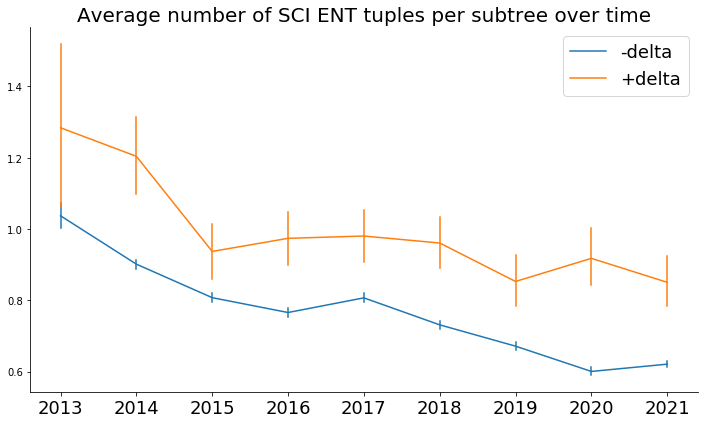

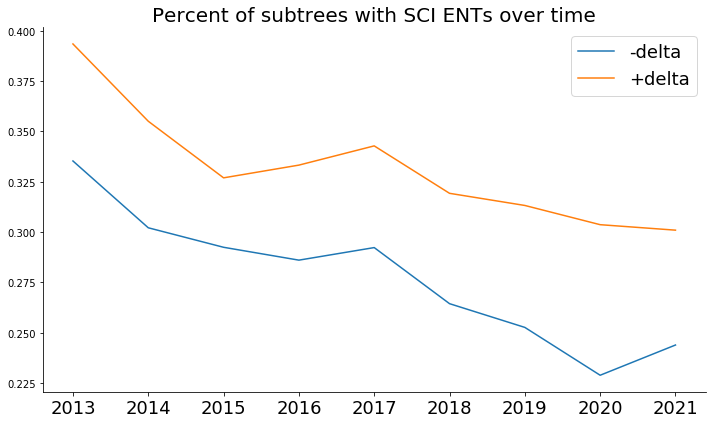

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_sci_ent_tuples',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of SCI ENT tuples per subtree over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_sci_ents_per_subtree_over_time.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='pct_subtrees',hue='outcome',
             data=to_plot_df2.loc[to_plot_df2['has_sci_ent']].sort_values('outcome',ascending=False),
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Percent of subtrees with SCI ENTs over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/pct_subtrees_w_sci_ents_over_time.png',dpi=200)

What is the distribution of dependency labels, POS tags for scientific entities?

obj           167629
nsubj         163231
obl           120662
nmod          108202
conj           55921
root           52031
compound       42444
advcl          18769
nsubj:pass     16826
xcomp          14459
ccomp          10538
acl:relcl       9984
acl             9361
appos           6820
amod            6451
parataxis       6062
csubj           2483
nmod:poss       1686
obl:npmod        498
flat             284
dep              228
iobj             163
list             111
vocative          93
dislocated        51
csubj:pass        48
aux               13
nmod:npmod        11
punct             11
discourse         10
advmod            10
obl:tmod           9
goeswith           3
aux:pass           1
nmod:tmod          1
Name: dep, dtype: int64
Top 6 frequency dependency labels for SCI ENTS: {'obj', 'conj', 'nmod', 'obl', 'root', 'nsubj'}


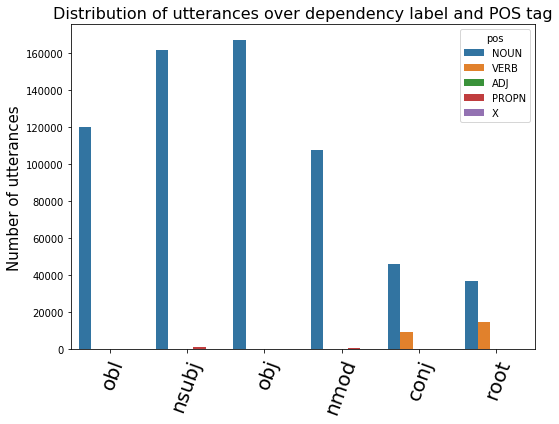

In [45]:
print(dedup_sci_ent_tups['dep'].value_counts())

top_dep = set(dedup_sci_ent_tups['dep'].value_counts().index[:6])
print("Top 6 frequency dependency labels for SCI ENTS:",top_dep)

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='dep', data=dedup_sci_ent_tups.loc[all_sci_ent_tups['dep'].isin(top_dep)], hue='pos', ax=ax)
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=70,rotation_mode='anchor',ha="right")
ax.set_ylabel("Number of utterances",fontsize=15)
ax.set_title("Distribution of utterances over dependency label and POS tag",fontsize=16)
plt.tight_layout()
#plt.savefig(os.path.join('figs','dist_sci_ents_deprel_pos_matched_cmv_subsample.png'),dpi=200)

Inspect SCI ENTS w/ `nsubj` dep. label but NOT POS=noun:

In [46]:
coordinates_ = dedup_sci_ent_tups.loc[
    (dedup_sci_ent_tups['dep']=='nsubj') & 
    (dedup_sci_ent_tups['pos']!='NOUN')
][['id','sent_ix','word_ix']].values
print(f"Found {len(coordinates_)} SCI ENTS w/ `nsubj` dep. label that are *not* NOUNS.")

print(dedup_sci_ent_tups.loc[
    (dedup_sci_ent_tups['dep']=='nsubj') & 
    (dedup_sci_ent_tups['pos']!='NOUN')
]['pos'].value_counts())

dedup_sci_ent_tups.loc[
    (dedup_sci_ent_tups['dep']=='nsubj') & 
    (dedup_sci_ent_tups['pos']=='ADJ')
]

Found 1204 SCI ENTS w/ `nsubj` dep. label that are *not* NOUNS.
PROPN    1096
VERB      107
ADJ         1
Name: pos, dtype: int64


,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
360919,t1_d7e3q0k,0,15,geneticist,nsubj,ADJ,would,acl:relcl,AUX


In [72]:
corp_to_analyze['matched_cmv_subsample'].get_utterance('t1_d7e3q0k').text

'It applies, but a social/psychological evaluation doesn\'t make the claims a geneticist would. There is a difference between studying your behaviour and marking down how many times you forget to do the dishes and draw a conclusion from that, and doing a biopsy to see, after observing you, whether or not there is a "forget to do the dishes" gene.'

In [47]:
dedup_sci_ent_tups.loc[
    (dedup_sci_ent_tups['dep']=='nsubj') & 
    (dedup_sci_ent_tups['pos']=='VERB')
]

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
6904,t1_cliqazj,5,4,model,nsubj,VERB,work,root,VERB
11885,t1_h7m2iyx,0,7,study,nsubj,VERB,have,ccomp,VERB
30631,t1_e5to79m,0,2,biology,nsubj,VERB,why,root,ADV
32671,t1_cp5nrt6,6,2,test,nsubj,VERB,nothing,root,PRON
42351,t1_dt5ibi0,0,3,study,nsubj,VERB,prove,root,VERB
...,...,...,...,...,...,...,...,...,...
802548,t1_cgprq00,0,3,test,nsubj,VERB,be,root,VERB
804327,t1_dsr8e8y,0,12,report,nsubj,VERB,go,advcl,VERB
813498,t1_dtoavxe,2,3,test,nsubj,VERB,different,root,ADJ
813762,t1_fjy0zwf,1,5,report,nsubj,VERB,likely,root,ADJ


In [120]:
corp_to_analyze['full_cmv'].get_utterance('t1_dt5ibi0').text

'How does that study prove anything?\n\nI would think that if a woman meets the same physical qualifications that men are held to (and a small number will) there would be no impact on performance.'

We should add 'PROPN' (which capitalized at the beginning of sentences tend to receive) to the criteria.

Let's also inspect non-`nsubj` SCI ENTS in-situ:

In [77]:
coordinates_ = dedup_sci_ent_tups.loc[
     (dedup_sci_ent_tups['dep']!='nsubj') #& 
#     ((dedup_sci_ent_tups['pos']=='NOUN') |
#      (dedup_sci_ent_tups['pos']=='PROPN'))
][['id','sent_ix','word_ix','pos','dep','lemma','head','head_dep','head_pos']]
print(f"Found {len(coordinates_)} SCI ENTS that are *not* nsubjs.")
#print(f"Found {len(coordinates_)} SCI ENTS w/ `NOUN/PROPN` POS that are *not* nsubjs.")

print(coordinates_['pos'].value_counts())

Found 651873 SCI ENTS that are *not* nsubjs.
NOUN     567895
VERB      77885
ADJ        3415
PROPN      2665
X             8
PUNCT         5
Name: pos, dtype: int64


In [78]:
import json_stream
def get_stanza_jsonstream(utt,
    stanza_dir=STANZA_DIR):
    #if len(utt.text) > 0 and utt.text != '-' and utt.text != '/':
    return json_stream.load(open(os.path.join(STANZA_DIR,f'{utt.id}.json'),'r'), persistent=True)

def get_stanza_json(utt,
    stanza_dir=STANZA_DIR):
    #if len(utt.text) > 0 and utt.text != '-' and utt.text != '/':
    return json.load(open(os.path.join(STANZA_DIR,f'{utt.id}.json'),'r'))

def get_context(corp,utt_id,sent_ix,word_ix,window_before=3,window_after=20):
    sent = get_stanza_jsonstream(corp.get_utterance(utt_id))['parse'][sent_ix]
    sent_len = len(list(sent))
    context = ' '.join([sent[word]['text'] for word in range(max(0,word_ix-window_before),
                                                             min(sent_len,word_ix+window_after))])
    return context

If still not done running after dentist:

In [79]:
random_rows_sample = set(np.random.choice(coordinates_.index.values,size=5000,replace=False))
print(list(random_rows_sample)[:3])
coordinates_sample = coordinates_.loc[coordinates_.index.isin(random_rows_sample)].copy()
coordinates_sample['context'] = coordinates_sample.apply(
    lambda x: get_context(corp_to_analyze['full_cmv'],x['id'],x['sent_ix'],x['word_ix'],window_before=10), axis=1)
coordinates_sample.head()

[712706, 49161, 147465]


,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
86,t3_2gxwbi,1,242,NOUN,obj,sociologist,see,acl:relcl,VERB,any of the other social sciences i have n't seen sociologists debate whether or not social stratification even exists linguists reject the idea that cultural pressures can change languages or
195,t1_diwympw,2,9,NOUN,nmod,experiment,country,nsubj,NOUN,Its just there have been so many countries as experiments for Islam ( https://en.wikipedia.org/wiki/Islam_by_country#Countries) and none have really worked out like the West .
252,t1_dad2vmg,11,6,NOUN,obj,evidence,find,advcl,VERB,What matters is if you find evidence to support your opinions .
453,t1_dl07b07,4,27,NOUN,obl,science,close,conj,ADJ,much closer to medicine and genomics is closer to the sciences in general being such board term that it is
582,t1_crgxdty,5,31,NOUN,obl,record,time,conj,NOUN,"would actually make things worse ( and , for the record , leaving is actually the single most likely time that DV escalates to murder ) , they are n't"


In descending order of frequency:

It seems that we are right to be excluding SCI ENTs w/ the `obj` dep. label:

In [81]:
coordinates_sample.loc[coordinates_sample['dep']=='obj']

,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
86,t3_2gxwbi,1,242,NOUN,obj,sociologist,see,acl:relcl,VERB,any of the other social sciences i have n't seen sociologists debate whether or not social stratification even exists linguists reject the idea that cultural pressures can change languages or
252,t1_dad2vmg,11,6,NOUN,obj,evidence,find,advcl,VERB,What matters is if you find evidence to support your opinions .
3286,t1_e21di54,2,21,NOUN,obj,scholarship,have,conj,VERB,is that your parents paid for it or you had scholarships and that is informing your view .
4269,t1_cbjxpam,0,102,NOUN,obj,article,browse,xcomp,VERB,"topic and what not , I just stumbled here browsing articles and thought I give my two cents"
5439,t1_gm1e46p,1,9,NOUN,obj,evidence,cite,xcomp,VERB,"Everyone crying to hold through it seemed to cite evidence that the banks doubled down on their short positions , and many of those positioned did n't expire until"
...,...,...,...,...,...,...,...,...,...,...
819054,t1_dtmhk04,3,18,NOUN,obj,test,fail,ccomp,VERB,"thousands of slender women disappointed that they failed their firefighter test ; they did n’t even take the test , as that job does n’t occur to them as something"
819945,t1_dbxnvpf,4,3,NOUN,obj,assessment,design,advcl,VERB,"When I design assessments , I have two main requirements to meet :"
820198,t1_dcmt38v,23,26,NOUN,obj,database,protect,acl,VERB,with a more intensive focus on protecting an organization ’s database and other information - related assets .
820806,t1_g5ukhea,1,5,NOUN,obj,datum,falsify,acl:relcl,VERB,Not the Democrats who falsified data and manipulated testimonies all in order to impeach the president .


The case with `nmod` SCI ENTs is a bit more tricky--talking about having evidence, as in the final example, seems to be relevant, but including this label risks including "model", "technique" etc. used in a different sense.

In [83]:
coordinates_sample.loc[coordinates_sample['dep']=='nmod']

,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
195,t1_diwympw,2,9,NOUN,nmod,experiment,country,nsubj,NOUN,Its just there have been so many countries as experiments for Islam ( https://en.wikipedia.org/wiki/Islam_by_country#Countries) and none have really worked out like the West .
1308,t1_hdskrjb,2,5,NOUN,nmod,model,lack,root,NOUN,Or lack of male role models to show what healthy love looks like .
2008,t1_czp6nvm,2,17,NOUN,nmod,study,field,nmod,NOUN,to philosophy as the foundation of all other fields of study .
2568,t1_hc7gsdg,0,9,NOUN,nmod,research,caveat,conj,NOUN,"They should , but with the caveat of diligent research ."
3174,t1_dyrunu3,5,31,NOUN,nmod,model,incentive,obj,NOUN,vastly speed up this process by creating tax incentives for models that have more units .
...,...,...,...,...,...,...,...,...,...,...
814662,t1_dflk4oe,1,20,NOUN,nmod,scientist,most,obj,ADJ,scientists who have a belief and historically speaking most of scientist have been believers of a or many gods .
817554,t1_cw17ue4,1,6,NOUN,nmod,technique,problem,root,NOUN,It is a problem of educational techniques and flawed impressions .
819939,t1_d088cwo,3,16,NOUN,nmod,assessment,motivation,nmod,NOUN,have some sort of possible motivation beyond a purely rigorous assessment of the situation ?
819953,t1_dbxnvpf,13,6,NOUN,nmod,assessment,grade,obj,NOUN,Does achieving a grade on this assessment correlate with the student 's abilities outside of the educational context / in the real world ?


The most relevant kind of template to include seems to be: "confirmed with evidence", "according to data", "backed by science"--think about how to include only these while excluding false positives like "genomics is closer to the sciences", "based in human biology", "thinking of the experiment".

In [85]:
coordinates_sample.loc[coordinates_sample['dep']=='obl']

,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
453,t1_dl07b07,4,27,NOUN,obl,science,close,conj,ADJ,much closer to medicine and genomics is closer to the sciences in general being such board term that it is
582,t1_crgxdty,5,31,NOUN,obl,record,time,conj,NOUN,"would actually make things worse ( and , for the record , leaving is actually the single most likely time that DV escalates to murder ) , they are n't"
1047,t1_hc7t27g,0,18,NOUN,obl,biology,base,acl,VERB,"is evidence that this is at least partially based in biology - among mammals , females tend to live longer than males ."
1401,t1_djmbvtj,1,33,NOUN,obl,dataset,appear,ccomp,VERB,", they say this : "" Thus , across both datasets , the same findings appear : while there is strong evidence that conservatives , on the whole , are"
2530,t1_fnz4l8o,2,11,NOUN,obl,datum,provide,xcomp,VERB,do you want to provide counter argument with your own data ?
...,...,...,...,...,...,...,...,...,...,...
813884,t1_cga22qb,10,18,NOUN,obl,observation,confirm,acl:relcl,VERB,"able to find one that can be confirmed by scientific observation ( although if we allow non-scientific observation , there are lots of seances in which non-physical spirits speak to"
817962,t1_he5o7w7,7,5,NOUN,obl,statistic,first,advmod,ADV,"So first of all your statistics is off and secondly , what has that to do with morality ?"
818155,t1_fjxmk4l,0,8,NOUN,obl,experiment,think,root,VERB,You must be thinking of the Tuskegee syphilis experiment .
819059,t1_e2k4m05,3,6,NOUN,obl,science,back,root,VERB,My position is backed by objective science regarding biology .


Basically include these if their conjunct is part of a valid tuple.

In [86]:
coordinates_sample.loc[coordinates_sample['dep']=='conj']

,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
4931,t1_cincnam,2,22,NOUN,conj,evidence,concept,obl,NOUN,"not be based on a religious concept , but perceived evidence ."
10855,t1_cj3a74w,12,18,VERB,conj,test,try,amod,VERB,all animals to respond efficiently with tried - and - tested behaviours to predictable and reliable stimuli .
12763,t1_d2au72u,9,20,NOUN,conj,scientist,artist,nsubj,NOUN,"evidence , "" but leading artists , politicians , and scientists at the time all held this view , as can be seen from writings of the time ."
13187,t1_f8mggvh,1,18,NOUN,conj,biology,geology,obl,NOUN,"drawing / painting classes improve learning in geology , general biology , and anatomy courses ."
17475,t1_e2u5h2o,7,28,NOUN,conj,science,vary,ccomp,VERB,", and the reasoning for this is not anti - science ."
...,...,...,...,...,...,...,...,...,...,...
810194,t1_cwmz6d1,9,12,NOUN,conj,record,policy,obl,NOUN,"not supporting him specifically because of his economic policy or record , they 're supporting him because he represents a break from the status quo ."
810892,t1_c9xe8qa,23,8,NOUN,conj,biology,psychology,obl,NOUN,Being introverted acts contrary to our psychology and biology .
811727,t1_gggt3kl,14,22,NOUN,conj,research,maturity,obl,NOUN,"parent came with maturity , experience , and education / research ."
815909,t1_faaq4t9,0,37,VERB,conj,test,part,parataxis,NOUN,"genes , culture is part of evolution , and is tested in the same way genes are in survival of the fittest ."


Safe to exclude?

In [87]:
coordinates_sample.loc[coordinates_sample['dep']=='root']

,id,sent_ix,word_ix,pos,dep,lemma,head,head_dep,head_pos,context
1512,t1_cojyl16,1,1,NOUN,root,study,.,punct,PUNCT,Harvard study .
1880,t1_d5ob714,5,5,NOUN,root,expert,.,punct,PUNCT,I am far from an expert on the literature of Islam but from what I 've heard they are significantly more explicit in their orders
1934,t1_cklrl73,3,11,VERB,root,report,.,punct,PUNCT,"they only cared about propaganda , they could have just reported it in the newspapers but not actually shot off the missile ."
3973,t1_do2um28,14,4,NOUN,root,study,],punct,PUNCT,A diffusion tensor imaging study ** ]
4067,t1_e2lk0qf,3,3,NOUN,root,evidence,.,punct,PUNCT,That would be evidence about original intent .
...,...,...,...,...,...,...,...,...,...,...
800999,t1_cggvfo4,1,4,NOUN,root,expert,.,punct,PUNCT,My husband is an expert in the field and in many cases these companies rent the cell towers from each other so the coverage
802709,t1_hb614pn,1,5,VERB,root,study,.,punct,PUNCT,"race as a concept were studied ant it does not hold from genetical perspective , variations in alleles between races are less significant than variations"
802868,t1_dfmpqb7,10,8,NOUN,root,method,.,punct,PUNCT,"In the end , tests are just a method of evaluation and do not determine true potential for academic learning ."
809629,t1_d9xf92p,32,4,NOUN,root,record,.,punct,PUNCT,"Also just for the record because it sounds like I 'm praising Trump a lot here : I really hate the guy , did"


Interim conclusion: rule-based SCI ENT tuple criteria quickly becomes unwieldy; may achieve both better precision and recall using ML model trained on anchor texts corresponding to (or full sentences containing) URLs, in which people are presenting empirical evidence.

### Criterion 2: Now restrict to NOUN + nsubj. SCI ENTS

In [20]:
pos_dep_sci_ent_utts = \
dedup_sci_ent_tups.loc[
    (dedup_sci_ent_tups['dep'].isin({'nsubj'})) & 
    (dedup_sci_ent_tups['pos'].isin({'NOUN','PROPN'}))
].copy()

print(f"Found unique {len(set(pos_dep_sci_ent_utts['id'].values))} comments \
({round(len(set(pos_dep_sci_ent_utts['id'].values))/len(corp_to_analyze['full_cmv'].get_utterance_ids()),2)}%) \
w/ SCI ENT satisfying POS and dep. label criteria.")

Found unique 122571 comments (0.04%) w/ SCI ENT satisfying POS and dep. label criteria.


In [90]:
sci_ent_counts_per_utt = pos_dep_sci_ent_utts.groupby('id').size()

# removed_outcome_ids = pickle.load(open('removed_subtrees.pkl','rb'))
# def is_removed_subtree(subtree_outcome_utt,path_to_removed_subtrees=removed_outcome_ids):
#     return subtree_outcome_utt.id in removed_outcome_ids

subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]

to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],
    'num_sci_ent_tuples': [sum([sci_ent_counts_per_utt[u_id]
                                if u_id in sci_ent_counts_per_utt
                                else 0
                           for u_id in utt.meta['path_to_outcome_OP_removed']]) 
                           for utt in subtree_outcome_utts],})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df['has_sci_ent'] = to_plot_df['num_sci_ent_tuples'].apply(lambda x: x > 0)

d = defaultdict(lambda: defaultdict(dict))
year_groups = to_plot_df.groupby('year')
for year in year_groups.first().index:
    for outcome in ['+delta', '-delta']:
        df_ = year_groups.get_group(year)
        df_ = df_.loc[df_['outcome'] == outcome]
        counts = df_['has_sci_ent'].value_counts()
        for bool_ in [True, False]:
            d[year][outcome][bool_] = counts[bool_]

years_df, outcomes_df, has_sci_ent_df, counts_df = [], [], [], []
for year in d:
    for outcome in d[year]:
        for bool_ in d[year][outcome]:
            years_df.append(year)
            outcomes_df.append(outcome)
            has_sci_ent_df.append(bool_)
            counts_df.append(d[year][outcome][bool_])
to_plot_df2 = pd.DataFrame({
    'year': years_df,
    'outcome': outcomes_df,
    'has_sci_ent': has_sci_ent_df,
    'num_subtrees': counts_df})
sum_df = to_plot_df2.groupby(['year','outcome']).sum()
to_plot_df2['pct_subtrees'] = to_plot_df2.apply(
    lambda x: x['num_subtrees']/sum_df.loc[(x['year'], x['outcome'])]['num_subtrees'], axis=1)
to_plot_df2.head()

,year,outcome,has_sci_ent,num_subtrees,pct_subtrees
0,2013,+delta,True,114,0.162162
1,2013,+delta,False,589,0.837838
2,2013,-delta,True,2483,0.122321
3,2013,-delta,False,17816,0.877679
4,2014,+delta,True,427,0.135901


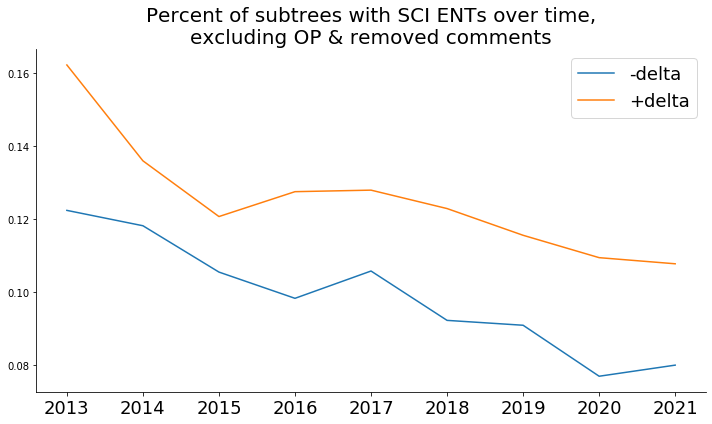

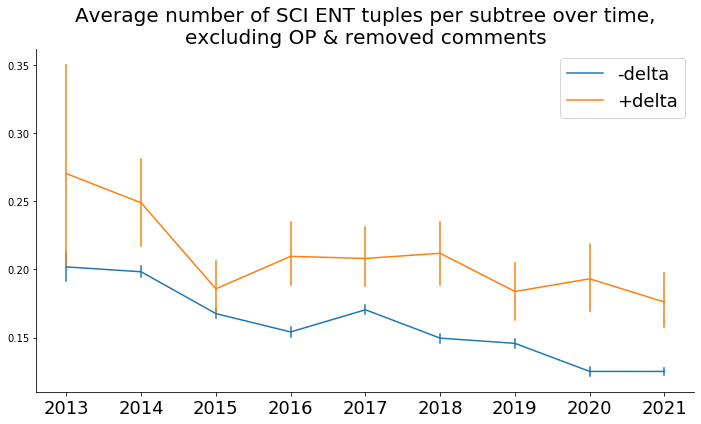

In [91]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='pct_subtrees',hue='outcome',
             data=to_plot_df2.loc[to_plot_df2['has_sci_ent']].sort_values('outcome',ascending=False),
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Percent of subtrees with SCI ENTs over time,\nexcluding OP & removed comments',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/pct_subtrees_w_noun_subj_sci_ents_over_time.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_sci_ent_tuples',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of SCI ENT tuples per subtree over time,\nexcluding OP & removed comments',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_noun_subj_sci_ents_per_subtree_over_time.png',dpi=200)

#### Examine dep. label and POS tags of head words to formulate criteria on what the SCI ENT is the nsubj *of*

In [92]:
print(pos_dep_sci_ent_utts['head_pos'].value_counts())

top_head_pos = set(pos_dep_sci_ent_utts['head_pos'].value_counts().index[:6])
print("Top 6 frequency POS tags for head of SCI ENTS:",top_head_pos)

VERB     117586
ADJ       22402
NOUN      12806
ADV        5178
PRON       1934
AUX        1747
NUM         388
PROPN       370
ADP         202
DET         200
SYM         113
SCONJ        97
X            95
INTJ          3
PUNCT         1
PART          1
Name: head_pos, dtype: int64
Top 6 frequency POS tags for head of SCI ENTS: {'PRON', 'VERB', 'AUX', 'ADV', 'ADJ', 'NOUN'}


Examine instances where POS of head word is *not* a VERB:

When head word of a NOUN nsubj SCI ENT is an *ADJ*, the larger context tends to be "SCI ENT is ADJ" (e.g. "science is complicated")--safe to omit.

In [271]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='ADJ']

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
2,t1_czbzlk5,2,1,observation,nsubj,NOUN,wrong,root,ADJ
21,t1_dzgj9xz,11,42,test,nsubj,NOUN,fair,advcl,ADJ
55,t1_ffzkltl,1,1,datum,nsubj,NOUN,hard,root,ADJ
77,t3_2gxwbi,1,7,economist,nsubj,NOUN,full,ccomp,ADJ
189,t1_dv1pzc6,2,2,astronomy,nsubj,NOUN,useful,ccomp,ADJ
...,...,...,...,...,...,...,...,...,...
820800,t1_dad8vqc,3,5,record,nsubj,NOUN,abysmal,root,ADJ
820825,t1_g6fxhht,1,2,datum,nsubj,NOUN,reflective,root,ADJ
820828,t1_d8o8axc,6,4,evidence,nsubj,NOUN,overwhelming,root,ADJ
820829,t1_fmp8q80,2,16,evidence,nsubj,NOUN,real,parataxis,ADJ


When head word of a NOUN nsubj SCI ENT is a *NOUN*, the larger context tends to be "SCI ENT is NOUN" (e.g. "science is garbage")--safe to omit.

In [272]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='NOUN']

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
22,t1_hacg7qn,0,2,method,nsubj,NOUN,something,root,NOUN
125,t1_coqukcu,1,1,evidence,nsubj,NOUN,fact,root,NOUN
337,t1_gluzrk7,0,1,professor,nsubj,NOUN,idiot,root,NOUN
479,t1_ga1bs6g,3,19,model,nsubj,NOUN,description,ccomp,NOUN
481,t1_ga1bs6g,4,10,model,nsubj,NOUN,choice,conj,NOUN
...,...,...,...,...,...,...,...,...,...
820586,t1_h6nromh,2,24,economist,nsubj,NOUN,one,conj,NOUN
820723,t1_ec623e2,0,7,evidence,nsubj,NOUN,existence,advcl,NOUN
820788,t1_cqgpu3g,0,15,article,nsubj,NOUN,lawsuit,conj,NOUN
820822,t1_dtt0v5y,3,21,finding,nsubj,NOUN,way,advcl,NOUN


When head word of a NOUN nsubj SCI ENT is an *ADVERB*, larger context includes examples like "research is about [...]", "where is the evidence?", "here is some evidence", "the science is there for everyone", 
"studies are out there"--safe to omit.

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='ADV']

When head word of a NOUN nsubj SCI ENT is an *AUXILIARY*, there are 2 kinds of larger context:
* involving "consensus" specifically: "The consensus is that [...]"--**this should be detected!**
* embedded clauses, e.g. "[...] than what a test does_AUX", "[...] in the way that articles do_AUX"--safe to omit.

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='AUX']

In [ ]:
# pos_dep_sci_ent_utts.loc[
#     (pos_dep_sci_ent_utts['head_pos']=='AUX') & 
#     (pos_dep_sci_ent_utts['lemma'].apply(lambda x: x.endswith('_consensus')))
# ]

When head word of a NOUN nsubj SCI ENT is a *PRONOUN*, the larger context tends to be similar to when it's an auxiliary: "study is what [...]"--safe to omit, other than "consensus".

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='PRON']['head'].value_counts()

Though when we examine the examples with "consensus", other than when the head is "that", the others are also safe to omit:

In [99]:
pos_dep_sci_ent_utts.loc[
    (pos_dep_sci_ent_utts['head_pos']=='PRON') & 
    (pos_dep_sci_ent_utts['lemma'].apply(lambda x: x.endswith('_consensus')))
]

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
84421,t1_cmhy6hv,3,26,scientific_consensus,nsubj,NOUN,nothing,acl,PRON
178712,t1_efazjfq,2,2,scientific_consensus,nsubj,NOUN,that,root,PRON
307294,t1_dksla98,5,7,scientific_consensus,nsubj,NOUN,what,acl,PRON
342130,t1_haoilwj,0,3,scientific_consensus,nsubj,NOUN,what,obj,PRON
424268,t1_esdjf6e,2,3,scientific_consensus,nsubj,NOUN,what,root,PRON
514385,t1_dhxho66,0,5,scientific_consensus,nsubj,NOUN,what,obj,PRON
650913,t1_dh1xtw3,6,6,scientific_consensus,nsubj,NOUN,what,ccomp,PRON
683005,t1_ddsyfwp,0,6,scientific_consensus,nsubj,NOUN,what,ccomp,PRON
781638,t1_f1sxw6j,1,13,scientific_consensus,nsubj,NOUN,what,obj,PRON


In [102]:
# def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
#     return corp.get_utterance(utt_id)

get_utt('t1_efazjfq').text

"Sorry. Could you provide a source that proves races exist?\n\nThe current scientific consensus is that [race](https://www.nationalgeographic.com/magazine/2018/04/race-genetics-science-africa/) is a colloquialism of social construction. There's no genetic basis for racial differences."

In [268]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='PRON']['lemma'].value_counts()

evidence          627
science           124
method            106
test              101
statistic          96
                 ... 
mathematician       1
geologist           1
anthropology        1
empirical_fact      1
geneticist          1
Name: lemma, Length: 65, dtype: int64

When head word of a NOUN nsubj SCI ENT is a *PROPER NOUN*, the larger context tends to be "SCI ENT is NOUN" instances where the parser was thrown off by capitalization or modification of the actual noun by some proper noun--safe to omit.

In [269]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='PROPN']#['head'].value_counts()

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
1846,t1_daocvzb,14,2,record,nsubj,NOUN,Roger,root,PROPN
7467,t1_c9uird6,3,3,study,nsubj,NOUN,David,root,PROPN
10568,t1_cx76jws,2,1,article,nsubj,NOUN,MD,root,PROPN
14113,t1_dc4d64n,0,1,statistic,nsubj,NOUN,Renaissance,root,PROPN
15907,t1_ek1k31b,0,20,datum,nsubj,NOUN,Center,conj,PROPN
...,...,...,...,...,...,...,...,...,...
809058,t1_ci26wb2,0,2,datum,nsubj,NOUN,Lean,root,PROPN
812495,t1_elijjfo,5,2,professor,nsubj,NOUN,Freud,root,PROPN
813508,t1_ds2hrco,5,2,expert,nsubj,NOUN,Dr.,root,PROPN
818009,t1_e1s6wvq,1,3,model,nsubj,NOUN,Blockbuster,root,PROPN


When head word of a NOUN nsubj SCI ENT is a *NUMERAL*, the larger context tends to be "study is from 2001", "test for UL certification is 10000 USD", "professor is one of the big names"--safe to omit.

In [270]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='NUM']#['head'].value_counts()

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
1034,t1_et9m9mv,3,2,study,nsubj,NOUN,2001,root,NUM
1854,t1_cgi7i69,2,3,datum,nsubj,NOUN,2011,root,NUM
5250,t1_gzf3tqu,7,4,record,nsubj,NOUN,1,root,NUM
11578,t1_dhbr5hp,0,1,article,nsubj,NOUN,2009,root,NUM
11820,t1_du8do6v,2,4,test,nsubj,NOUN,one,ccomp,NUM
...,...,...,...,...,...,...,...,...,...
806826,t1_f46ofi4,2,4,analysis,nsubj,NOUN,one,root,NUM
810312,t1_h9xl1qk,2,1,datum,nsubj,NOUN,50,root,NUM
810682,t1_cu9o7yb,3,1,professor,nsubj,NOUN,50/50,root,NUM
818419,t1_grbwoku,0,6,article,nsubj,NOUN,2013,ccomp,NUM


When head word of a NOUN nsubj SCI ENT is an *ADPOSITION*, the larger context tends to be  "[...] that data can be *about*_ADP", "data will be off_ADP", "the science isn't all in_ADP", "the science isn't in yet"--safe to admit

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='ADP']#['head'].value_counts()

When head word of a NOUN nsubj SCI ENT is a *DETERMINER*, we get more of the embedded context--safe to omit. 

In [2]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='DET']['head'].value_counts()

NameError: name 'pos_dep_sci_ent_utts' is not defined

When head word of a NOUN nsubj SCI ENT is a *subordinating conjunction*, we get more of the embedded context--safe to omit. 

In [108]:
pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='SCONJ']['head'].value_counts()

where    37
why      35
how      22
when      3
Name: head, dtype: int64

When head word of a NOUN nsubj SCI ENT is a *SYMBOL*, larger context tends to be "statistic is $XX", "report is at 2% of all reports", "publication = funding"--safe to omit.

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='SYM']#['head'].value_counts()

Finally, looking at 'X' and 'INTJ' tags--'X' consist of all URLs; sole 'INTJ' example is "biochemistry is very computer-*like*_INTJ"--all safe to omit.

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='X']#['head'].value_counts()

In [ ]:
#pos_dep_sci_ent_utts.loc[pos_dep_sci_ent_utts['head_pos']=='INTJ']#['head'].value_counts()

In [289]:
#get_utt('t1_dfl23ll').text

So our criteria so far:
* `head_pos` == VERB, or
* (`head_pos` == AUX) & (`lemma` == 'X_consensus') [& (`head` == 'be')]

In [21]:
pos_dep_verblike_sci_ent_utts = pos_dep_sci_ent_utts.loc[
    (pos_dep_sci_ent_utts['head_pos']=='VERB') | 
    ((pos_dep_sci_ent_utts['head_pos']=='AUX') & 
     (pos_dep_sci_ent_utts['lemma'].apply(lambda x: '_consensus' in x)))
].copy()
print(len(pos_dep_verblike_sci_ent_utts), len(pos_dep_sci_ent_utts))

114823 159325


In [93]:
117614/163123

0.7210142040055664

#### Examine actual lemmas of head words to formulate additional criteria

We also want to curate the kinds of verbs for the tuples we include. Are there verbs separate from the pre-curated set of sentential complement-embedding `HOUSEHOLDER_STEMS`? 

Write most frequent non-Householder head verbs to file to annotate for whether or not to add/further inspect/ignore:

In [325]:
# pd.DataFrame({
#     'verb': pos_dep_verblike_sci_ent_utts.loc[
#     ~pos_dep_verblike_sci_ent_utts['head'].isin(HOUSEHOLDER_STEMS)]['head'].value_counts().index.values,
#     'label': [-1]*len(pos_dep_verblike_sci_ent_utts.loc[
#     ~pos_dep_verblike_sci_ent_utts['head'].isin(HOUSEHOLDER_STEMS)]['head'].value_counts().index)
# }).to_csv('potential_empirical_evidence_tuple_verbs.tsv',sep='\t',header=True,index=False)

In [22]:
labeled_verb_candidates = pd.read_csv('potential_empirical_evidence_tuple_verbs_LABELED.tsv',sep='\t')
labeled_verb_candidates['label'].value_counts()

-1    731
i      35
a      13
Name: label, dtype: int64

In [23]:
# Sanity check verbs labeled as "To add without need of further inspection"

verbs_to_add = set(labeled_verb_candidates.loc[labeled_verb_candidates['label']=='a']['verb'].values)
df_to_inspect = pos_dep_verblike_sci_ent_utts.loc[
    pos_dep_verblike_sci_ent_utts['head'].isin(verbs_to_add)].copy()
df_to_inspect['context'] = df_to_inspect.apply(lambda x: 
                                               get_context(corp_to_analyze['full_cmv'],
                                                           x['id'],
                                                           x['sent_ix'],
                                                           x['word_ix']),
                                               axis=1)
df_to_inspect

NameError: name 'get_stanza_json' is not defined

Conclusion--tuples seem like they're okay!

In [26]:
CURATED_VERBS = HOUSEHOLDER_STEMS | verbs_to_add
print(len(CURATED_VERBS))

pos_dep_verb_sci_ent_utts = pos_dep_sci_ent_utts.loc[
    ((pos_dep_sci_ent_utts['head_pos']=='VERB') & 
     (pos_dep_sci_ent_utts['head'].isin(CURATED_VERBS))) | 
    ((pos_dep_sci_ent_utts['head_pos']=='AUX') & 
     (pos_dep_sci_ent_utts['lemma'].apply(lambda x: '_consensus' in x)))
].copy()

print(f"Found {len(pos_dep_verb_sci_ent_utts)} tuples with a SCI ENT either: \
1. having a head VERB belonging to `CURATED VERBS`, or \
2. following a 'X_consensus is that [...]' template.")

pickle.dump(pos_dep_verb_sci_ent_utts,open('sci_ent_tuple_utts.pkl','wb'))

432
Found 49025 tuples with a SCI ENT either: 1. having a head VERB belonging to `CURATED VERBS`, or 2. following a 'X_consensus is that [...]' template.


In [28]:
list(pos_dep_verb_sci_ent_utts.keys())[0]

'id'

In [29]:
pos_dep_verb_sci_ent_utts.head()

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos
9,t1_czbzlk5,7,25,evidence,nsubj,NOUN,come,acl,VERB
13,t1_ctpi602,0,1,article,nsubj,NOUN,state,root,VERB
18,t1_cf1eoaa,3,1,model,nsubj,NOUN,find,root,VERB
60,t1_ga5tl30,1,1,article,nsubj,NOUN,say,root,VERB
75,t3_2gxwbi,1,140,science,nsubj,NOUN,seem,acl:relcl,VERB


In [30]:
len(pos_dep_verb_sci_ent_utts['id'].value_counts()) # number of unique utts these tuples belong to

42282

In [355]:
len(regression_utt_ids)

43411

In [121]:
sci_ent_counts_per_utt = pos_dep_verb_sci_ent_utts.groupby('id').size()

to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],
    'num_sci_ent_tuples': [sum([sci_ent_counts_per_utt[u_id]
                                if u_id in sci_ent_counts_per_utt
                                else 0
                           for u_id in utt.meta['path_to_outcome_OP_removed']]) 
                           for utt in subtree_outcome_utts],})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df['has_sci_ent'] = to_plot_df['num_sci_ent_tuples'].apply(lambda x: x > 0)

d = defaultdict(lambda: defaultdict(dict))
year_groups = to_plot_df.groupby('year')
for year in year_groups.first().index:
    for outcome in ['+delta', '-delta']:
        df_ = year_groups.get_group(year)
        df_ = df_.loc[df_['outcome'] == outcome]
        counts = df_['has_sci_ent'].value_counts()
        for bool_ in [True, False]:
            d[year][outcome][bool_] = counts[bool_]

years_df, outcomes_df, has_sci_ent_df, counts_df = [], [], [], []
for year in d:
    for outcome in d[year]:
        for bool_ in d[year][outcome]:
            years_df.append(year)
            outcomes_df.append(outcome)
            has_sci_ent_df.append(bool_)
            counts_df.append(d[year][outcome][bool_])
to_plot_df2 = pd.DataFrame({
    'year': years_df,
    'outcome': outcomes_df,
    'has_sci_ent': has_sci_ent_df,
    'num_subtrees': counts_df})
sum_df = to_plot_df2.groupby(['year','outcome']).sum()
to_plot_df2['pct_subtrees'] = to_plot_df2.apply(
    lambda x: x['num_subtrees']/sum_df.loc[(x['year'], x['outcome'])]['num_subtrees'], axis=1)
to_plot_df2.head()

,year,outcome,has_sci_ent,num_subtrees,pct_subtrees
0,2013,+delta,True,46,0.065434
1,2013,+delta,False,657,0.934566
2,2013,-delta,True,880,0.043352
3,2013,-delta,False,19419,0.956648
4,2014,+delta,True,158,0.050286


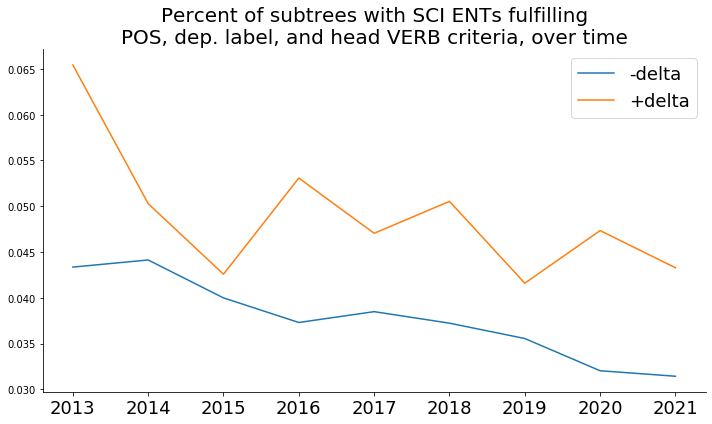

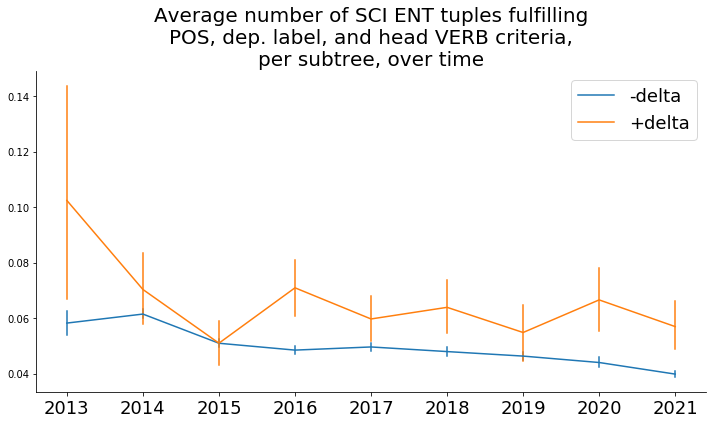

In [122]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='pct_subtrees',hue='outcome',
             data=to_plot_df2.loc[to_plot_df2['has_sci_ent']].sort_values('outcome',ascending=False),
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Percent of subtrees with SCI ENTs fulfilling\nPOS, dep. label, and head VERB criteria, over time',
             fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/pct_subtrees_w_noun_subj_verb_criteria_sci_ents_over_time.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_sci_ent_tuples',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of SCI ENT tuples fulfilling\nPOS, dep. label, and head VERB criteria,\nper subtree, over time',
             fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_noun_subj_sci_ents_verb_criteria_per_subtree_over_time.png',dpi=200)

Inspect head verbs in the set of "maybes" to see if we can relax criteria a bit and augment SCI ENT tups:

In [119]:
verbs_to_inspect = set(labeled_verb_candidates.loc[labeled_verb_candidates['label']=='i']['verb'].values)
df_to_inspect = pos_dep_verblike_sci_ent_utts.loc[
    pos_dep_verblike_sci_ent_utts['head'].isin(verbs_to_inspect)].copy()
df_to_inspect['context'] = df_to_inspect.apply(lambda x: 
                                               get_context(corp_to_analyze['full_cmv'],
                                                           x['id'],
                                                           x['sent_ix'],
                                                           x['word_ix']),
                                              axis=1)

KeyboardInterrupt: 

In [350]:
df_to_inspect

,id,sent_ix,word_ix,lemma,dep,pos,head,head_dep,head_pos,context
10,t1_dt09oqx,16,18,scholarship,nsubj,NOUN,be,conj,VERB,there are many scholarships and grants available to US citizens to help make it affordable which are not available for foreign students .
55,t1_dek731v,7,14,method,nsubj,NOUN,be,conj,VERB,are many proposed methods .
64,t1_cs5vl47,10,4,method,nsubj,NOUN,be,root,VERB,'s simply no method of action for it to occur .
80,t1_dyhji9c,0,8,evidence,nsubj,NOUN,be,ccomp,VERB,"'s not enough evidence to prove or disprove the existence of God , which technically is where we are ."
85,t1_dyhji9c,3,16,evidence,nsubj,NOUN,be,advcl,VERB,"there 's no evidence for God , but to be acceptable from a scientific perspective , you need evidence beyond reasonable doubt one"
...,...,...,...,...,...,...,...,...,...,...
132092,t1_h7v07qu,8,16,test,nsubj,NOUN,yield,root,VERB,"stupid , the test will still yield weird results ."
132100,t1_eqewkst,16,3,test,nsubj,NOUN,be,root,VERB,"... the ultimate test for such discussions is who would you save , between a psychopath and a normal person ."
132109,t1_cvrwpml,1,3,survey,nsubj,NOUN,have,root,VERB,"Correct , these surveys may have some statistical value , IF they are compared against / with surveys on other factors ."
132211,t1_etdizml,13,3,method,nsubj,NOUN,be,root,VERB,"There is no method to determine , without context , which of these is "" more "" correct than the other ."


### Criterion 3: Now restrict to tuples with VERB belonging to curated set

## Validation of measure

### Compare dep. label/POS-aware approach to lexicon-only approach for measuring empirical evidence

Retrieve examples of false positives retrieved via a lexicon-only approach:

## Cache measure in meta dict of corpus

In [125]:
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if (utt.id[:2]=='t1') and (not utt.meta['is_removed']):
        #utt.meta['sci_ent_tups'] = sci_ent_counts_per_utt[utt.id] if utt.id in sci_ent_counts_per_utt else []
        utt.meta['num_sci_ent_tups'] = sci_ent_counts_per_utt[utt.id] if utt.id in sci_ent_counts_per_utt else 0
        utt.meta['has_sci_ent_tup'] = utt.meta['num_sci_ent_tups'] > 0

3243830it [00:40, 80039.06it/s]


# Indirect empirical evidence: augment via texts corresponding to URLs

## Anchor texts

In [15]:
HYPERLINK_PATTERN = re.compile('\[(?P<anchor_text>.*?)\]\((?P<hyperlink>.*?)\)')
def get_anchor_texts(utt_text, pattern=HYPERLINK_PATTERN):
    return [m.groupdict() for m in pattern.finditer(utt_text)]
    
# test example
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if len(utt.meta['text_urls']) > 5:
        break
print(get_anchor_texts(utt.text))

1454it [00:00, 104532.28it/s]

[{'anchor_text': 'chatheads', 'hyperlink': 'https://www.youtube.com/watch?v=aeHfyPnu3C8'}, {'anchor_text': 'Flynx', 'hyperlink': 'https://www.youtube.com/watch?v=L4qLJdkN4Kk'}, {'anchor_text': 'my phone asks me with which app I would like to open it and gives me a list', 'hyperlink': 'http://imgur.com/gCuYsk7'}, {'anchor_text': 'Quick settings are awesome', 'hyperlink': 'http://imgur.com/0dM6sug'}, {'anchor_text': 'Google Now', 'hyperlink': 'https://www.youtube.com/watch?v=1JEXDBWehvI'}, {'anchor_text': '"Ok Google" can be used even when the phone is locked', 'hyperlink': 'https://www.youtube.com/watch?v=WRn5le4fSQc'}, {'anchor_text': 'Now on Tap', 'hyperlink': 'https://www.youtube.com/watch?v=DnZn4iLiB2k'}, {'anchor_text': 'Google Now Launcher', 'hyperlink': 'https://www.youtube.com/watch?v=ma-DGvCajWM'}, {'anchor_text': 'Badland', 'hyperlink': 'https://play.google.com/store/apps/details?id=com.frogmind.badland&hl=en'}, {'anchor_text': 'Tasker', 'hyperlink': 'https://www.youtube.com/w

In [23]:
# Iterate through corpus
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['anchor_texts_and_urls'] = get_anchor_texts(utt.text)
    
utt_ids_df, urls_df, url_domains_df, anchor_texts_df = [], [], [], []
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    for item in utt.meta['anchor_texts_and_urls']:
        url, anchor = item['hyperlink'], item['anchor_text']
        utt_ids_df.append(utt.id)
        urls_df.append(url)
        url_domains_df.append(get_url_domain(url))
        anchor_texts_df.append(anchor)
anchor_texts_df = pd.DataFrame({
    'id': utt_ids_df,
    'url': urls_df,
    'domain': url_domains_df,
    'anchor text': anchor_texts_df})

with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = set(f.read().splitlines())
    domains_to_exclude.add('')
anchor_texts_df['domain_to_exclude'] = anchor_texts_df['domain'].apply(
                    lambda x: (x[0] in domains_to_exclude) or (x[1] in domains_to_exclude))

print(anchor_texts_df.shape)
display(anchor_texts_df.head(10))

3243830it [00:33, 96896.00it/s] 
3243830it [00:22, 147192.22it/s]


(517598, 5)


,id,url,domain,anchor text,domain_to_exclude
0,t1_g99brae,/r/changemyview/wiki/user/ModaGamer,"(, )",1∆,True
1,t1_g99brae,https://www.reddit.com/r/changemyview/wiki/deltasystem,"(reddit.com, reddit)",Delta System Explained,True
2,t1_g99brae,https://www.reddit.com/r/changemyview/wiki/deltaboards,"(reddit.com, reddit)",Deltaboards,True
3,t1_filv1mm,https://old.reddit.com/r/dndnext/comments/f8bgjh/i_wish_my_table_looked_like_that_a_quick_guide_on/,"(old.reddit.com, reddit)",This,True
4,t1_e29z1mq,/r/changemyview/wiki/user/Adventurous_Fox,"(, )",6∆,True
5,t1_e29z1mq,https://www.reddit.com/r/changemyview/wiki/deltasystem,"(reddit.com, reddit)",Delta System Explained,True
6,t1_e29z1mq,https://www.reddit.com/r/changemyview/wiki/deltaboards,"(reddit.com, reddit)",Deltaboards,True
7,t1_gr4pj0y,https://www.reddit.com/r/changemyview/wiki/deltasystem?utm_source=reddit&utm_medium=usertext&utm_name=changemyview&utm_content=t5_2w2s8,"(reddit.com, reddit)",this link,True
8,t1_esb0myz,https://upload.wikimedia.org/wikipedia/commons/d/d5/David_von_Michelangelo.jpg,"(upload.wikimedia.org, wikimedia)",Nudity isn't inherently sexual.,False
9,t1_g6v9et3,https://www.axios.com/republican-party-demographics-threat-trump-racism-1524a8a1-c2f1-4183-896f-107420e2d50a.html,"(axios.com, axios)",This Axios article,False


In [24]:
domains_to_exclude

{'',
 '25.media.tumblr.com',
 '4.bp.blogspot',
 'addons.mozilla',
 'chrome.google',
 'duckduckgo.com',
 'encrypted-tbn0.gstatic.com',
 'facebook.com',
 'ff2ebook.com',
 'gfycat.com',
 'google',
 'greasyfork',
 'i.pinimg.com',
 'i.redd.it',
 'i.ytimg.com',
 'i0.kym-cdn.com',
 'i2.wp.com',
 'i216.photobucket.com',
 'images.app.goo.gl',
 'img1.wikia.nocookie.net',
 'imgur',
 'instagram.com',
 'knowyourmeme.com',
 'lh3.googleusercontent.com',
 'lmgtfy.com',
 'mashable.com',
 'media.giphy.com',
 'open.spotify.com',
 'pastebin',
 'qph.ec.quoracdn.net',
 'reddit',
 'redditenhacementsuite',
 'ri.search.yahoo.com',
 's-media-cache-ak0.pinimg',
 's3.amazonaws.com',
 'scribd.com',
 'soundcloud.com',
 'twitter',
 'vimeo.com',
 'voat.co',
 'www\\.fanfiction\\.net',
 'youtu',
 'youtube'}

In [25]:
display(anchor_texts_df.loc[~anchor_texts_df['domain_to_exclude']].head(30))

,id,url,domain,anchor text,domain_to_exclude
8,t1_esb0myz,https://upload.wikimedia.org/wikipedia/commons/d/d5/David_von_Michelangelo.jpg,"(upload.wikimedia.org, wikimedia)",Nudity isn't inherently sexual.,False
9,t1_g6v9et3,https://www.axios.com/republican-party-demographics-threat-trump-racism-1524a8a1-c2f1-4183-896f-107420e2d50a.html,"(axios.com, axios)",This Axios article,False
23,t1_dr0yfws,https://www.minuteearth.com/about/,"(minuteearth.com, minuteearth)",Minute Earth,False
26,t1_cxjar9b,https://en.wikipedia.org/wiki/Redlining,"(en.wikipedia.org, wikipedia)",redlining,False
27,t1_c9ve82p,http://en.wikipedia.org/wiki/Women_in_Arab_societies#Arab_women_before_Islam,"(en.wikipedia.org, wikipedia)",mostly resulted in an improvement,False
29,t1_d47gcu2,https://www.verywell.com/premature-babies-week-by-week-2748606,"(verywell.com, verywell)",Here,False
30,t1_ffylll7,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5797481/,"(ncbi.nlm.nih.gov, ncbi)",a lot of studies,False
31,t1_ffylll7,https://www.theatlantic.com/magazine/archive/2015/09/the-coddling-of-the-american-mind/399356/,"(theatlantic.com, theatlantic)",common mental distortions,False
32,t3_2gxwbi,http://www.nytimes.com/2009/09/06/magazine/06Economic-t.html?_r=0,"(nytimes.com, nytimes)",basically confess the cluelessness of people working in the field,False
33,t3_2gxwbi,http://mises.org/epofe/c1p2sec2.asp,"(mises.org, mises)",don't require empirical validation,False


In [ ]:
# # TO DO: most common ngrams range=(1,3), excluding blacklist domains

# from sklearn.feature_extraction.text import CountVectorizer
# def extract_ngrams(sample_str):
#     vect = CountVectorizer(ngram_range=(1,3))
#     try:
#         vect.fit([sample_str])
#     except ValueError:
#         return []
#     return vect.get_feature_names()

# print(anchor_texts_df['anchor text'].values[9])
# print("ngrams:",extract_ngrams(anchor_texts_df['anchor text'].values[9]))

# anchor_texts_df['ngrams'] = anchor_texts_df['anchor text'].apply(lambda x: extract_ngrams(x))
# display(anchor_texts_df.head(10))

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# stopwords_set = set(stopwords.words('english'))

# #ngram_counts = Counter(flatten(anchor_texts_df.loc[~anchor_texts_df['domain_to_exclude']]['ngrams'].values))
# # sorted_ngram_counts = sorted([x for x in ngram_counts.items() if x[0] not in stopwords_set],
# #                               key=lambda x: x[1], reverse=True)
# print(sorted_ngram_counts[:500])

In [ ]:
# # TO DO: most common ngrams range=(1,3) for top 10 most frequent domains
# ngrams_per_domain = defaultdict(list)
# for _,row in tqdm(anchor_texts_df.iterrows()):
#     domain, ngrams = row['domain'][1], row['ngrams']
#     ngrams_per_domain[domain].extend(ngrams)
    
# top_short_domains_to_plot = """wikipedia
# nytimes
# theguardian
# washingtonpost
# forbes
# cnn
# cdc
# ncbi
# npr
# bbc
# none"""
# top_short_domains_to_plot = top_short_domains_to_plot.split('\n')
# print(top_short_domains_to_plot)

# for domain in top_short_domains_to_plot:
#     print(f"{domain.upper()}: \
#           {sorted([x for x in Counter(ngrams_per_domain[domain]).items() if x[0] not in stopwords_set][:200],key=lambda x: x[1], reverse=True)}")

## Full sentences containing URLs

In [26]:
HYPERLINK_SENT_PATTERN = re.compile('. (?P<full_sent>.*?\[(?P<anchor_text>.*?)\]\((?P<hyperlink>.*?)\)).')
def get_URL_sentences(utt_text, pattern=HYPERLINK_SENT_PATTERN):
    return [m.groupdict() for m in pattern.finditer(utt_text)]

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if utt.meta['num_urls'] > 2:
        break

# print(utt.text)
# print(get_URL_sentences(utt.text))

338it [00:00, 87651.46it/s]


In [28]:
# # Iterate through corpus
# for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#     utt.meta['parsed_URL_sents'] = get_URL_sentences(utt.text)
    
# utt_ids_df, urls_df, url_domains_df, anchor_texts_df, full_sents_df = [], [], [], [], []
# for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#     for item in utt.meta['parsed_URL_sents']:
#         url, anchor, full_sent = item['hyperlink'], item['anchor_text'], item['full_sent']
#         utt_ids_df.append(utt.id)
#         urls_df.append(url)
#         url_domains_df.append(get_url_domain(url))
#         anchor_texts_df.append(anchor)
#         full_sents_df.append(full_sent)
# anchor_texts_df = pd.DataFrame({
#     'id': utt_ids_df,
#     'url': urls_df,
#     'domain': url_domains_df,
#     'anchor text': anchor_texts_df,
#     'full sent': full_sents_df})

# with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
#     domains_to_exclude = set(f.read().splitlines())
#     domains_to_exclude.add('')
# anchor_texts_df['domain_to_exclude'] = anchor_texts_df['domain'].apply(
#                     lambda x: (x[0] in domains_to_exclude) or (x[1] in domains_to_exclude))

print(anchor_texts_df.shape)
display(anchor_texts_df.loc[~anchor_texts_df['domain_to_exclude']].head(30))

(344664, 6)


,id,url,domain,anchor text,full sent,domain_to_exclude
4,t1_esb0myz,https://upload.wikimedia.org/wikipedia/commons/d/d5/David_von_Michelangelo.jpg,"(upload.wikimedia.org, wikimedia)",Nudity isn't inherently sexual.,"for nudity, this point seems to contradict the last. Drag queens, who wear clothes and make-up that aren't the ones society matches to their gender, and naked people, who forgo clothing entirely, somehow both create an association between sexuality and gender identity. [Nudity isn't inherently sexual.](https://upload.wikimedia.org/wikipedia/commons/d/d5/David_von_Michelangelo.jpg)",False
5,t1_g6v9et3,https://www.axios.com/republican-party-demographics-threat-trump-racism-1524a8a1-c2f1-4183-896f-107420e2d50a.html,"(axios.com, axios)",This Axios article,"if Trump wins, the demographics that would propel him to victory are rapidly shifting. The voting coalition supporting him and the current iteration of the Republican party is almost certainly temporary. [This Axios article](https://www.axios.com/republican-party-demographics-threat-trump-racism-1524a8a1-c2f1-4183-896f-107420e2d50a.html)",False
13,t1_cxjar9b,https://en.wikipedia.org/wiki/Redlining,"(en.wikipedia.org, wikipedia)",redlining,"you look at most major urban areas in the U.S., you'll see disproportionate poverty and crime statistics for the black population. This is true in large part because in many cases when those cities were built black people were explicitly denied housing in all but one neighborhood. (By the way, while housing discrimination laws are supposed to present this, these laws were put in place much later than most people think, and discriminatory housing practices continue to this day in the form of [redlining](https://en.wikipedia.org/wiki/Redlining)",False
14,t1_c9ve82p,http://en.wikipedia.org/wiki/Women_in_Arab_societies#Arab_women_before_Islam,"(en.wikipedia.org, wikipedia)",mostly resulted in an improvement,"rather irrelevant. My point was that by today's western standards, the culture and tradition in the Islamic world just don't live up to what we consider decent gender rights. Current Arab culture and tradition originates from Islam, but that's not saying the introduction of Islam 2000 years ago was a blow for women rights at the time, which as you say, [mostly resulted in an improvement](http://en.wikipedia.org/wiki/Women_in_Arab_societies#Arab_women_before_Islam)",False
16,t1_d47gcu2,https://www.verywell.com/premature-babies-week-by-week-2748606,"(verywell.com, verywell)",Here,"second part states that the third trimester it's still not possible. However, there has been documented cases. [Here](https://www.verywell.com/premature-babies-week-by-week-2748606)",False
17,t1_ffylll7,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5797481/,"(ncbi.nlm.nih.gov, ncbi)",a lot of studies,type of therapy which has had [a lot of studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5797481/),False
18,t3_2gxwbi,http://www.nytimes.com/2009/09/06/magazine/06Economic-t.html?_r=0,"(nytimes.com, nytimes)",basically confess the cluelessness of people working in the field,I read pieces by influential Economists that [basically confess the cluelessness of people working in the field](http://www.nytimes.com/2009/09/06/magazine/06Economic-t.html?_r=0),False
19,t3_2gxwbi,http://mises.org/epofe/c1p2sec2.asp,"(mises.org, mises)",don't require empirical validation,the one hand and on the other hand assert that their theories [don't require empirical validation](http://mises.org/epofe/c1p2sec2.asp),False
20,t3_2gxwbi,http://ineteconomics.org/blog/inet/economics-not-math,"(ineteconomics.org, ineteconomics)",A Mathematician put out a critique about Economists' use of mathematics a few years back that I really enjoyed.,"I can't help but think ""Wow, the emperor has no clothes."" While Economists (hilariously) try to create an air of credibility to their work by expressing their theories with mathematical formulas, the doesn't change the fact that the basic ideas tha

# Direct empirical evidence: URLs

Extract top domains, both long and shortened versions:

In [5]:
long_domains = [x[0] for utt in corp_to_analyze['full_cmv'].iter_utterances()
                                for x in utt.meta['url_domains']]
counted_long_domains = Counter(long_domains)
sorted_long_domains = sorted(counted_long_domains.items(),key=lambda x: x[1],reverse=True)
top_long_domains = [item for item in sorted_long_domains if item[1] >= 5]
print(len(top_long_domains))

short_domains = [x[1] for utt in corp_to_analyze['full_cmv'].iter_utterances()
                                for x in utt.meta['url_domains']]
counted_short_domains = Counter(short_domains)
sorted_short_domains = sorted(counted_short_domains.items(),key=lambda x: x[1],reverse=True)
top_short_domains = [item for item in sorted_short_domains if item[1] >= 5]
print(len(top_short_domains))

short_domain2long_domain_dict = dict(zip(short_domains, long_domains))

4117
3749


## Experiment 1: Manually curate domains (with some heuristics)

Apply simple heuristics to label .gov, .edu, and news websites: 

In [213]:
domain2label = {x[0]: 'govt' for x in top_short_domains 
                if short_domain2long_domain_dict[x[0]].endswith('.gov')}
domain2label.update({
    x[0]: 'edu' for x in top_short_domains 
                if short_domain2long_domain_dict[x[0]].endswith('.edu')
})
domain2label.update({
    x[0]: 'news' for x in top_short_domains 
                if 'news' in x[0]
})
len(domain2label)

565

Label all other domains manually:

In [251]:
# top_short_domains

In [219]:
# # Write to csv to label
# pd.DataFrame({
#     'short domain': [x[0] for x in top_short_domains if x[0] not in domain2label],
#     'long domain': [short_domain2long_domain_dict[x[0]] for x in top_short_domains if x[0] not in domain2label],
#     'label': [-1 for x in top_short_domains if x[0] not in domain2label]
# }).to_csv('url_domains_to_label.tsv',sep='\t',header=True,index=False)

In [223]:
labeled_domains1 = pd.read_csv('url_domains_LABELED.tsv',sep='\t')
labeled_domains2 = pd.read_csv('url_domains_LABELED_2.tsv',sep='\t')
labeled_domains3 = pd.read_csv('url_domains_LABELED_3.tsv',sep='\t')
labeled_domains = pd.concat([labeled_domains1,labeled_domains2,
                             labeled_domains3])
labeled_domains = labeled_domains.loc[labeled_domains['label'] != '-1']
labeled_domains.shape

(533, 3)

In [224]:
domain2label.update(dict(zip(labeled_domains['short domain'].values, 
                             labeled_domains['label'].values)))
len(domain2label)

1062

In [225]:
# Examine coverage of labeled domains to see if I need to label some more

def get_url_domain_cats(utt):
    return [domain2label[dom[1]] 
            for dom in utt.meta['url_domains']
            if dom[1] in domain2label]

for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt.meta['url_domain_cats'] = get_url_domain_cats(utt)
        
Counter([len(utt.meta['url_domain_cats'])==0 
         for utt in corp_to_analyze['full_cmv'].iter_utterances()
         if utt.meta['has_url']])

3243830it [00:27, 116667.97it/s]


Counter({False: 261354, True: 32383})

In [249]:
# There are 32823 utterances for which none of the URLs have been labeled
# and 261354 utterances with at least one labeled, or 11%

32383/(32823+261354)

0.11007998585885369

In [229]:
# Of those to which coverage does not extend, X are in +delta subtrees

Counter([utt.meta['outcome'] 
         for utt in corp_to_analyze['full_cmv'].iter_utterances()
         if (utt.id[:2]=='t1')
         and (utt.meta['has_url'])
         and (len(utt.meta['url_domain_cats'])==0)])

Counter({-1: 18728, '-delta': 12817, '+delta': 128})

In [222]:
counted_short_domains['avoiceformen']

37

In [250]:
#labeled_domains.loc[labeled_domains['label']=='o']

In [32]:
# # Examine URLs in-situ

# bernie_utts = []
# for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#     if 'filer.case.edu' in utt.text:
#         bernie_utts.append(utt)
# print(len(bernie_utts))
# print([x.text for x in bernie_utts[:15]])

Conclusion: all URLs are potentially relevant speech acts corresponding to invoking evidence,
    better to go about identifying high-frequency domains to exclude (e.g. giphy, Youtube)

## Experiment 2: Manually identify high-freq domains to exclude

In [259]:
labeled_domains1 = pd.read_csv('url_domains_LABELED.tsv',sep='\t')
labeled_domains2 = pd.read_csv('url_domains_LABELED_2.tsv',sep='\t')
labeled_domains3 = pd.read_csv('url_domains_LABELED_3.tsv',sep='\t')
labeled_domains = pd.concat([labeled_domains1,labeled_domains2,
                             labeled_domains3])
domains_to_exclude = labeled_domains.loc[
    labeled_domains['label'].isin({'o','g','sm'})]
print(domains_to_exclude.shape)

domains_to_exclude.head()

(75, 3)


,short domain,long domain,label
0,reddit,reddit,sm
3,google,google,g
6,imgur,imgur,g
15,pastebin,pastebin,o
31,twitter,twitter,sm


While some domains (spotify, youtube) may be links to explanation videos or podcasts, it is safer to exclude these domains entirely since there is little guarantee of that being always the case.

In [41]:
# with open('URL_DOMAINS_TO_EXCLUDE.txt','w') as f:
#     for d in domains_to_exclude:
#         f.write(d+'\n')
        
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = f.read().splitlines()
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

Excluding URLs from 43 domains:
['', 'addons.mozilla', 'vimeo.com', 'scribd.com', 'i2.wp.com', 'gfycat.com', 'redditenhacementsuite', 'www\\.fanfiction\\.net', 'ri.search.yahoo.com', 'i0.kym-cdn.com', 'qph.ec.quoracdn.net', 'youtu', 'ff2ebook.com', 'open.spotify.com', 'i.ytimg.com', 'voat.co', 'soundcloud.com', 'twitter', '25.media.tumblr.com', 'lmgtfy.com', 'encrypted-tbn0.gstatic.com', 's-media-cache-ak0.pinimg', 's3.amazonaws.com', 'instagram.com', 'i216.photobucket.com', 'greasyfork', 'media.giphy.com', 'img1.wikia.nocookie.net', 'pastebin', 'images.app.goo.gl', '4.bp.blogspot', 'reddit', 'i.pinimg.com', 'facebook.com', 'youtube', 'duckduckgo.com', 'i.redd.it', 'google', 'lh3.googleusercontent.com', 'knowyourmeme.com', 'mashable.com', 'chrome.google', 'imgur']


In [279]:
# for d in domains_to_exclude:
#     bernie_utts = []
#     for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#         if d in utt.text:
#             bernie_utts.append(utt)
#     print(len(bernie_utts))
#     print(d)
#     print([x.text for x in bernie_utts[:5]])
#     print('******')

## Visualize feature once measurement is finalized

In [22]:
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = set(f.read().splitlines())
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

Excluding URLs from 43 domains:
{'', 'imgur', 'addons.mozilla', 'vimeo.com', 'scribd.com', 'i2.wp.com', 'gfycat.com', 'redditenhacementsuite', 'www\\.fanfiction\\.net', 'ri.search.yahoo.com', 'i0.kym-cdn.com', 'qph.ec.quoracdn.net', 'youtu', 'ff2ebook.com', 'open.spotify.com', 'i.ytimg.com', 'voat.co', 'soundcloud.com', 'twitter', '25.media.tumblr.com', 'lmgtfy.com', 's-media-cache-ak0.pinimg', 's3.amazonaws.com', 'instagram.com', 'i216.photobucket.com', 'greasyfork', 'media.giphy.com', 'img1.wikia.nocookie.net', 'pastebin', 'images.app.goo.gl', '4.bp.blogspot', 'reddit', 'i.pinimg.com', 'facebook.com', 'youtube', 'duckduckgo.com', 'i.redd.it', 'google', 'lh3.googleusercontent.com', 'knowyourmeme.com', 'mashable.com', 'chrome.google', 'encrypted-tbn0.gstatic.com'}


In [9]:
domains_to_exclude.difference(set(long_domains) | set(short_domains))

{'4.bp.blogspot',
 'addons.mozilla',
 'chrome.google',
 'redditenhacementsuite',
 's-media-cache-ak0.pinimg'}

In [7]:
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = set(f.read().splitlines())
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

# Re-compute feature (`num_urls`; `has_url`) excluding above domains
for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt.meta['text_urls'] = get_urls(utt.text)
        utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
        utt.meta['num_urls'] = len([x for x in utt.meta['url_domains'] 
                                    if (x[0] not in domains_to_exclude)
                                    and (x[1] not in domains_to_exclude)])
        utt.meta['has_url'] = utt.meta['num_urls'] > 0

3243830it [01:38, 32980.87it/s]


Examine distribution *in subtrees* over time:

In [8]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]

In [9]:
to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],
    'num_urls': [sum([corp_to_analyze['full_cmv'].get_utterance(u_id).meta['num_urls']
                      for u_id in utt.meta['path_to_outcome_OP_removed']
                      if not corp_to_analyze['full_cmv'].get_utterance(u_id).meta['is_removed']]) 
                 for utt in subtree_outcome_utts],
})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df['has_url'] = to_plot_df['num_urls'].apply(lambda x: x > 0)

In [10]:
to_plot_df.loc[to_plot_df['outcome']=='+delta']['has_url'].value_counts()/\
sum(to_plot_df.loc[to_plot_df['outcome']=='+delta']['has_url'].value_counts())

False    0.816814
True     0.183186
Name: has_url, dtype: float64

In [11]:
to_plot_df.loc[to_plot_df['outcome']=='-delta']['has_url'].value_counts()/\
sum(to_plot_df.loc[to_plot_df['outcome']=='-delta']['has_url'].value_counts())

False    0.868738
True     0.131262
Name: has_url, dtype: float64

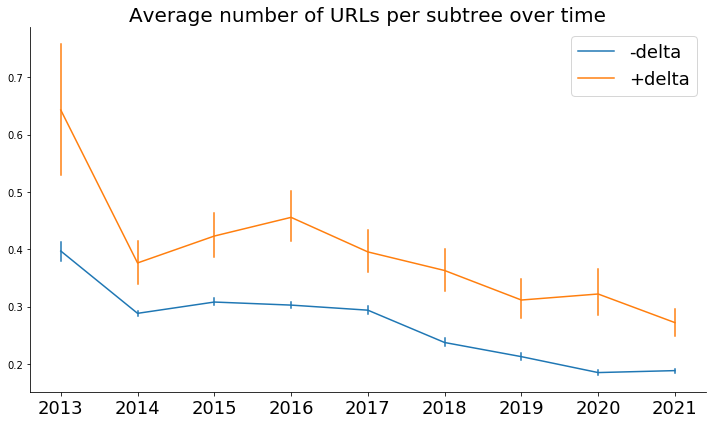

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_urls',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of URLs per subtree over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_URLs_per_subtree_over_time.png',dpi=200)

In [13]:
# # Plot of most frequent URL domains over time, in addition to "other" and "none" categories

# First retrieve most frequent domains per year
subtrees_per_year = to_plot_df.groupby('year')
domain_counts_per_subtree_by_year = defaultdict(lambda: defaultdict(int))
for year in subtrees_per_year.first().index:
    outcome_utt_ids_ = subtrees_per_year.get_group(year)['subtree_outcome_utt_id'].values
    for utt_id in outcome_utt_ids_: # Iterate through all subtrees
        comment_url_domains = set() # Maintain set of unique domains occurring throughout the entire subtree
        for u_id in corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['path_to_outcome_OP_removed']:
            comment_url_domains |= set(corp_to_analyze['full_cmv'].get_utterance(u_id).meta['url_domains'])
        for d in comment_url_domains: # Update counter
            if (d[0] not in domains_to_exclude) and (d[1] not in domains_to_exclude):
                domain_counts_per_subtree_by_year[year][d[1]] += 1
        if len(comment_url_domains) == 0: # Update counter to increment the category "None" by 1 (subtree)
            domain_counts_per_subtree_by_year[year]['none'] += 1
#     url_domains = flatten([corp_to_analyze['full_cmv'].get_utterance(u_id).meta['url_domains']
#                            for utt_id in outcome_utt_ids_
#                            for u_id in corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['path_to_outcome']])
    url_domain_counts = domain_counts_per_subtree_by_year[year]
#     filtered_url_domain_counts = {d: url_domain_counts[d] for d in url_domain_counts
#                                   if d not in domains_to_exclude}
    top15 = sorted(url_domain_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    print(year)
    print(top15)
    print('****************')

2013
[('none', 15947), ('wikipedia', 1605), ('filer', 237), ('thefutureofourworld', 234), ('supporters', 155), ('generalmills', 121), ('miami', 121), ('time', 95), ('ncbi', 64), ('huffingtonpost', 60), ('nytimes', 54), ('livescience', 51), ('businessinsider', 51), ('economist', 50), ('cdc', 49)]
****************
2014
[('none', 117772), ('wikipedia', 7993), ('nytimes', 614), ('ncbi', 477), ('washingtonpost', 428), ('theguardian', 414), ('huffingtonpost', 384), ('amazon', 347), ('cdc', 270), ('forbes', 253), ('tvtropes', 212), ('cnn', 198), ('slate', 190), ('chicagobooth', 174), ('wikimedia', 168)]
****************
2015
[('none', 112241), ('wikipedia', 6888), ('washingtonpost', 807), ('nytimes', 711), ('theguardian', 496), ('ncbi', 464), ('huffingtonpost', 409), ('cdc', 396), ('forbes', 362), ('npr', 357), ('archive', 252), ('time', 251), ('wikimedia', 236), ('cnn', 233), ('theatlantic', 222)]
****************
2016
[('none', 105130), ('wikipedia', 5960), ('washingtonpost', 880), ('nytime

In [14]:
# Do we see the same top domains when subsetting to +delta subtrees?
subtrees_per_year = to_plot_df.loc[to_plot_df['outcome']=='+delta'].groupby('year')
domain_counts_per_subtree_by_year = defaultdict(lambda: defaultdict(int))
for year in subtrees_per_year.first().index:
    outcome_utt_ids_ = subtrees_per_year.get_group(year)['subtree_outcome_utt_id'].values
    for utt_id in outcome_utt_ids_: # Iterate through all subtrees
        comment_url_domains = set() # Maintain set of unique domains occurring throughout the entire subtree
        for u_id in corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['path_to_outcome_OP_removed']:
            comment_url_domains |= set(corp_to_analyze['full_cmv'].get_utterance(u_id).meta['url_domains'])
        for d in comment_url_domains: # Update counter
            if (d[0] not in domains_to_exclude) and (d[1] not in domains_to_exclude):
                domain_counts_per_subtree_by_year[year][d[1]] += 1
        if len(comment_url_domains) == 0: # Update counter to increment the category "None" by 1 (subtree)
            domain_counts_per_subtree_by_year[year]['none'] += 1
#     url_domains = flatten([corp_to_analyze['full_cmv'].get_utterance(u_id).meta['url_domains']
#                            for utt_id in outcome_utt_ids_
#                            for u_id in corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['path_to_outcome']])
    url_domain_counts = domain_counts_per_subtree_by_year[year]
#     filtered_url_domain_counts = {d: url_domain_counts[d] for d in url_domain_counts
#                                   if d not in domains_to_exclude}
    top15 = sorted(url_domain_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    print(year)
    print(top15)
    print('****************')

2013
[('none', 465), ('wikipedia', 69), ('generalmills', 27), ('miami', 27), ('time', 20), ('filer', 12), ('thefutureofourworld', 12), ('livescience', 12), ('supporters', 9), ('skepticalscience', 6), ('tumblr', 4), ('postimg', 4), ('ncbi', 4), ('amazon', 3), ('patheos', 3)]
****************
2014
[('none', 2445), ('wikipedia', 202), ('tvtropes', 17), ('nytimes', 16), ('ncbi', 15), ('amazon', 12), ('washingtonpost', 10), ('chicagobooth', 10), ('cdc', 9), ('wikimedia', 9), ('phys', 8), ('theguardian', 8), ('newscientist', 7), ('huffingtonpost', 7), ('npr', 7)]
****************
2015
[('none', 2915), ('wikipedia', 240), ('washingtonpost', 22), ('archive', 18), ('huffingtonpost', 18), ('nytimes', 15), ('ncbi', 15), ('theguardian', 14), ('tvtropes', 13), ('wikimedia', 10), ('sagepub', 10), ('forbes', 10), ('sciencedirect', 9), ('amazon', 9), ('theatlantic', 8)]
****************
2016
[('none', 3160), ('wikipedia', 243), ('washingtonpost', 48), ('nytimes', 31), ('ncbi', 25), ('huffingtonpost', 

In [ ]:
wikipedia
theguardian
ncbi
nytimes
npr
bbc
theatlantic
wapo
huffpo
--somewhat the same

In [22]:
top_short_domains_to_plot = """wikipedia
nytimes
theguardian
washingtonpost
forbes
cnn
cdc
ncbi
npr
bbc
none"""
top_short_domains_to_plot = top_short_domains_to_plot.split('\n')
top_short_domains_to_plot

['wikipedia',
 'nytimes',
 'theguardian',
 'washingtonpost',
 'forbes',
 'cnn',
 'cdc',
 'ncbi',
 'npr',
 'bbc',
 'none']

In [25]:
years_df, domains_df, counts_df = [], [], []
for year in tqdm(domain_counts_per_subtree_by_year):
    for domain in top_short_domains_to_plot:
        years_df.append(year)
        domains_df.append(domain)
        counts_df.append(domain_counts_per_subtree_by_year[year][domain])
    years_df.append(year)
    domains_df.append('other')
    counts_df.append(sum([domain_counts_per_subtree_by_year[year][d]
                          for d in domain_counts_per_subtree_by_year[year]
                          if d not in top_short_domains_to_plot]))
    
to_plot_df2 = pd.DataFrame({
    'year': years_df,
    'domain': domains_df,
    'count': counts_df})
to_plot_df2['log_count'] = to_plot_df2['count'].apply(lambda x: np.log(x))
to_plot_df2.head()

100%|██████████| 9/9 [00:00<00:00, 183.92it/s]


,year,domain,count,log_count
0,2013,wikipedia,1605,7.380879
1,2013,nytimes,54,3.988984
2,2013,theguardian,10,2.302585
3,2013,washingtonpost,19,2.944439
4,2013,forbes,42,3.737670


In [26]:
to_plot_df2 = to_plot_df2.pivot(index='year', columns='domain', values='count')
to_plot_df2

domain,bbc,cdc,cnn,forbes,ncbi,none,npr,nytimes,other,theguardian,washingtonpost,wikipedia
year,,,,,,,,,,,,
2013,15,49,19,42,64,16932,25,54,5250,10,19,1605
2014,151,270,198,253,477,124617,159,614,25845,414,428,7993
2015,147,396,233,362,464,117564,357,711,27956,496,807,6888
2016,302,136,249,181,394,110261,412,853,27404,456,880,5960
2017,183,181,299,375,599,111519,328,732,27223,406,908,5527
2018,153,124,182,237,710,111759,319,535,20643,333,612,4773
2019,163,184,212,187,758,111466,318,534,18925,418,402,3803
2020,245,573,162,135,462,116874,263,457,17761,284,288,3660
2021,245,588,190,248,516,155157,422,357,23856,325,404,5029


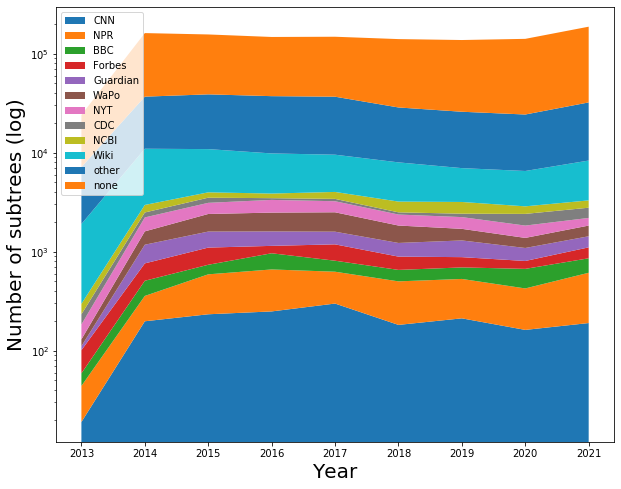

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plt.stackplot(to_plot_df2.index, 
              to_plot_df2.cnn,
              to_plot_df2.npr,
              to_plot_df2.bbc,
              to_plot_df2.forbes,
              to_plot_df2.theguardian,
              to_plot_df2.washingtonpost,
              to_plot_df2.nytimes,
              to_plot_df2.cdc,
              to_plot_df2.ncbi,
              to_plot_df2.wikipedia,
              to_plot_df2.other,
              to_plot_df2.none,
              labels=['CNN', 'NPR', 'BBC', 'Forbes', 'Guardian', 'WaPo', 
                      'NYT', 'CDC', 'NCBI', 'Wiki', 'other', 'none'])
              #colors=color_map)

#add legend
plt.legend(loc='upper left')

#add axis labels
plt.xlabel('Year',fontsize=20)
plt.ylabel('Number of subtrees (log)',fontsize=20)
plt.yscale('log')

#display area chart
plt.show()

In [28]:
to_plot_df3 = to_plot_df2.div(to_plot_df2.sum(axis=1), axis=0)
to_plot_df3

domain,bbc,cdc,cnn,forbes,ncbi,none,npr,nytimes,other,theguardian,washingtonpost,wikipedia
year,,,,,,,,,,,,
2013,0.000623,0.002035,0.000789,0.001744,0.002657,0.703039,0.001038,0.002242,0.217987,0.000415,0.000789,0.066642
2014,0.000935,0.001673,0.001227,0.001567,0.002955,0.772009,0.000985,0.003804,0.160111,0.002565,0.002651,0.049517
2015,0.000940,0.002532,0.001490,0.002315,0.002967,0.751779,0.002283,0.004547,0.178769,0.003172,0.005160,0.044046
2016,0.002048,0.000922,0.001688,0.001227,0.002671,0.747593,0.002793,0.005784,0.185805,0.003092,0.005967,0.040410
2017,0.001234,0.001221,0.002016,0.002529,0.004040,0.752084,0.002212,0.004937,0.183592,0.002738,0.006124,0.037274
2018,0.001090,0.000883,0.001296,0.001688,0.005058,0.796118,0.002272,0.003811,0.147051,0.002372,0.004360,0.034001
2019,0.001187,0.001339,0.001543,0.001361,0.005518,0.811429,0.002315,0.003887,0.137767,0.003043,0.002926,0.027684
2020,0.001736,0.004059,0.001148,0.000956,0.003273,0.827931,0.001863,0.003237,0.125818,0.002012,0.002040,0.025927
2021,0.001308,0.003139,0.001014,0.001324,0.002754,0.828224,0.002253,0.001906,0.127343,0.001735,0.002157,0.026845


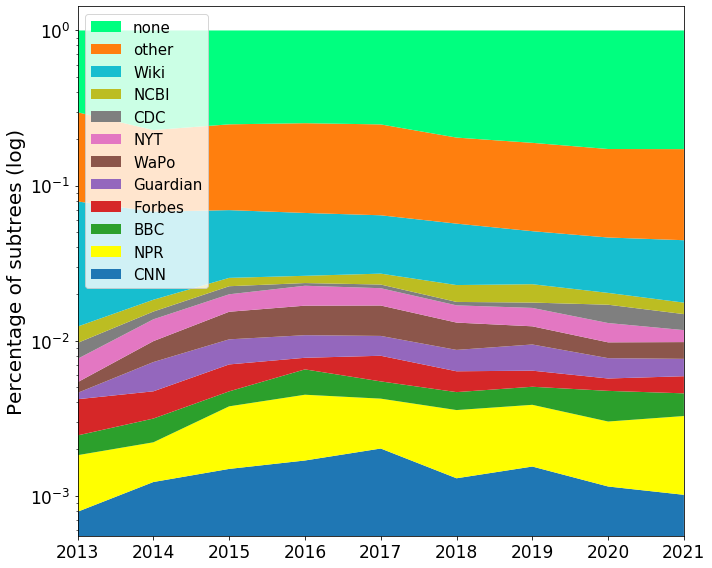

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
plt.stackplot(to_plot_df3.index, 
              to_plot_df3.cnn,
              to_plot_df3.npr,
              to_plot_df3.bbc,
              to_plot_df3.forbes,
              to_plot_df3.theguardian,
              to_plot_df3.washingtonpost,
              to_plot_df3.nytimes,
              to_plot_df3.cdc,
              to_plot_df3.ncbi,
              to_plot_df3.wikipedia,
              to_plot_df3.other,
              to_plot_df3.none,
              labels=['CNN', 'NPR', 'BBC', 'Forbes', 'Guardian', 'WaPo', 
                      'NYT', 'CDC', 'NCBI', 'Wiki', 'other', 'none'],
              colors=['tab:blue','yellow','tab:green','tab:red','tab:purple',
                      'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan',
                      'tab:orange','springgreen'])

#add legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],labels[::-1],loc='upper left',fontsize=15)

#add axis labels
plt.xlabel('')
plt.ylabel('Percentage of subtrees (log)',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim([2013,2021])
plt.yscale('log')

#display area chart
plt.tight_layout()
plt.savefig('figs/top_URL_domains_over_time.png',dpi=200)

# Correlation b/w measures

Populate a comment-level dataframe for plotting:

In [249]:
# corr_plot_df = pd.DataFrame({
#     'id': [utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
#            if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])],
#     'conversation_id': [utt.conversation_id for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                         if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])],
#     'has_url': [utt.meta['has_url'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                 if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])],
#     'num_urls': [utt.meta['num_urls'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                  if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])],
#     'has_sci_ent_tup': [utt.meta['has_sci_ent_tup'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                         if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])],
#     'num_sci_ent_tups': [utt.meta['num_sci_ent_tups'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                          if (utt.id[:2]=='t1') and (not utt.meta['is_removed'])]})
# corr_plot_df['log_num_urls'] = corr_plot_df['num_urls'].apply(lambda x: np.log(x+0.5))
# corr_plot_df['log_num_sci_ent_tups'] = corr_plot_df['num_sci_ent_tups'].apply(lambda x: np.log(x+0.5))
corr_plot_df['log_log_num_urls'] = corr_plot_df['log_num_urls'].apply(lambda x: np.log(x+0.5))
corr_plot_df['log_log_num_sci_ent_tups'] = corr_plot_df['log_num_sci_ent_tups'].apply(lambda x: np.log(x+0.5))

Let's examine the correlation b/w first the indicator variables: `has_url` (excluding blacklist domains) and `has_sci_ent_tup`.

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


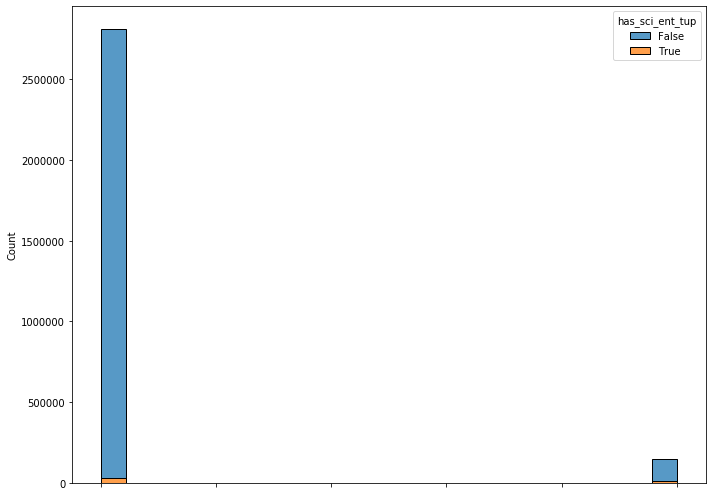

In [131]:
# TO DO: stacked distplot w/ x-axis=`has_url` and hue=`has_sci_ent_tup` 
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(x='has_url',hue='has_sci_ent_tup',data=corr_plot_df,
             multiple='stack',ax=ax)
ax.set_xlabel('')
ax.set_xticklabels([],fontsize=20)
plt.tight_layout()
#plt.savefig('figs/has_url_vs_has_sci_ent_tup.png',dpi=200)

Hard to tell in this plot, but a higher pct of comments w/ URLs have SCI ENT tuples compared to comments w/o URLs. Good.

In [136]:
corr_plot_df.loc[corr_plot_df['has_url']]['has_sci_ent_tup'].value_counts()/\
sum(corr_plot_df.loc[corr_plot_df['has_url']]['has_sci_ent_tup'].value_counts())

False    0.93378
True     0.06622
Name: has_sci_ent_tup, dtype: float64

In [137]:
corr_plot_df.loc[~corr_plot_df['has_url']]['has_sci_ent_tup'].value_counts()/\
sum(corr_plot_df.loc[~corr_plot_df['has_url']]['has_sci_ent_tup'].value_counts())

False    0.988473
True     0.011527
Name: has_sci_ent_tup, dtype: float64

Now let's look at the continuous variables: `num_urls` (again excluding blacklist domains) and `num_sci_ent_tups`.

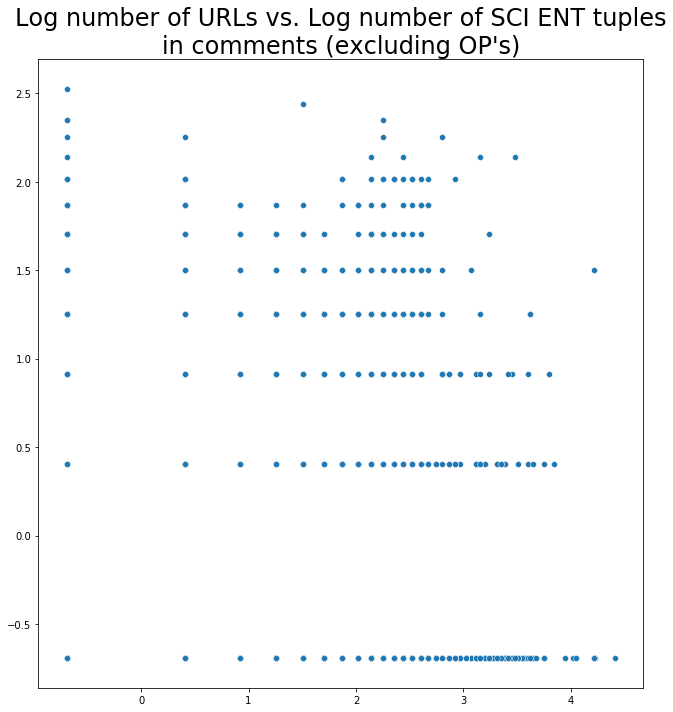

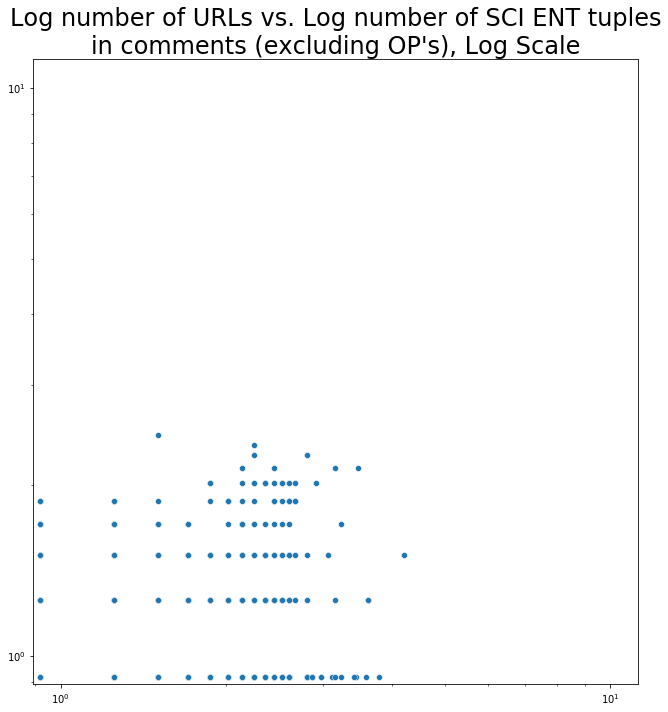

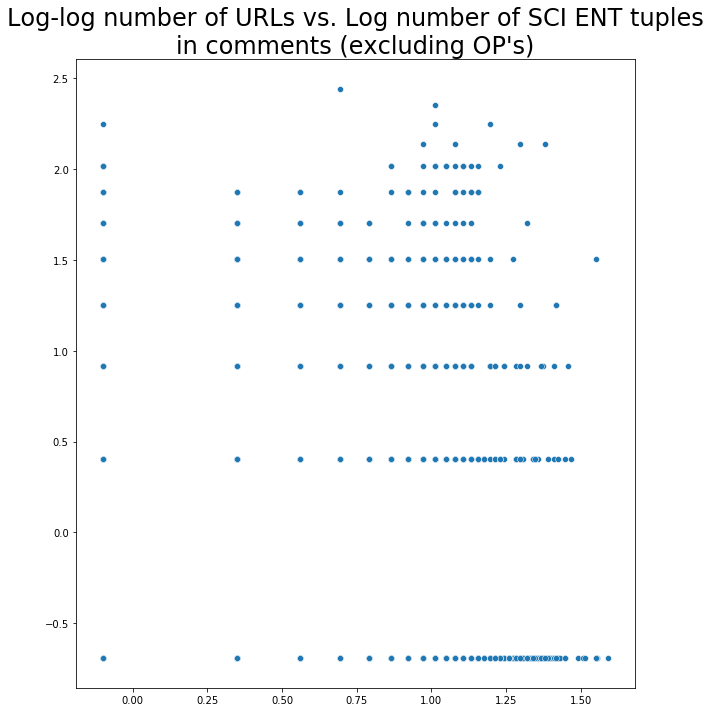

In [253]:
# TO DO: scatterplot
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='log_num_urls',y='log_num_sci_ent_tups',data=corr_plot_df,
             ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Log number of URLs vs. Log number of SCI ENT tuples\nin comments (excluding OP's)",
             fontsize=24)
plt.tight_layout()
#plt.savefig('figs/num_urls_vs_num_sci_ent_tups.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='log_num_urls',y='log_num_sci_ent_tups',data=corr_plot_df,
             ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Log number of URLs vs. Log number of SCI ENT tuples\nin comments (excluding OP's), Log Scale",
             fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='log_log_num_urls',y='log_num_sci_ent_tups',data=corr_plot_df,
             ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Log-log number of URLs vs. Log number of SCI ENT tuples\nin comments (excluding OP's)",
             fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()

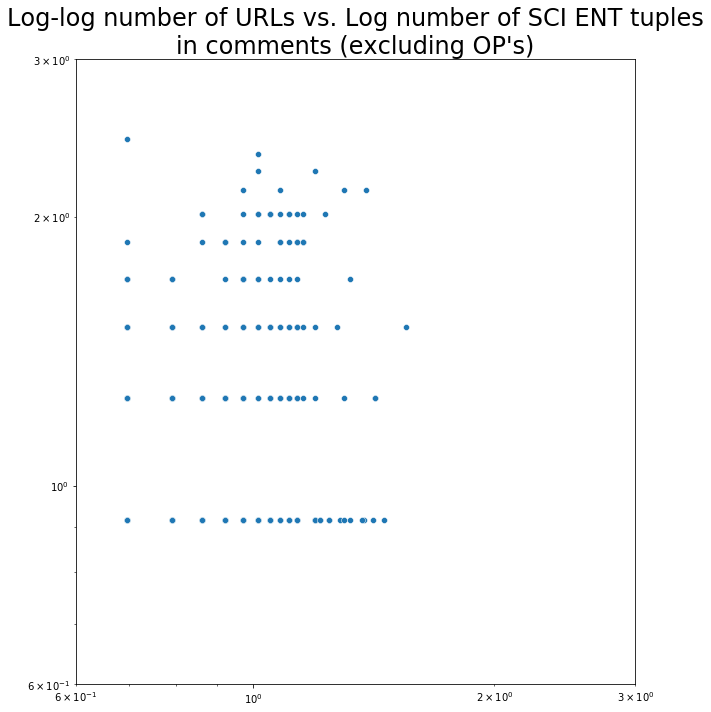

In [264]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='log_log_num_urls',y='log_num_sci_ent_tups',data=corr_plot_df,
             ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim([0.6,3])
ax.set_ylim([0.6,3])
ax.set_title("Log-log number of URLs vs. Log number of SCI ENT tuples\nin comments (excluding OP's)",
             fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()

The two are highly correlated as count variables (Spearman's rank correlation is appropriate here):

In [265]:
# TO DO: statistical test
print(stats.spearmanr(corr_plot_df['num_urls'].values,
                      corr_plot_df['num_sci_ent_tups'].values))
print(stats.spearmanr(corr_plot_df['log_num_urls'].values,
                      corr_plot_df['log_num_sci_ent_tups'].values))
print(stats.spearmanr(corr_plot_df['log_log_num_urls'].values,
                      corr_plot_df['log_log_num_sci_ent_tups'].values))

SpearmanrResult(correlation=0.10089876885100027, pvalue=0.0)
SpearmanrResult(correlation=0.10089876885100027, pvalue=0.0)
SpearmanrResult(correlation=nan, pvalue=nan)


In [266]:
res = stats.spearmanr(corr_plot_df['num_urls'].values,
                      corr_plot_df['num_sci_ent_tups'].values)
res.pvalue

0.0

In [267]:
# excluding zero values:
nonzero_df = corr_plot_df.loc[(corr_plot_df['has_url']) & (corr_plot_df['has_sci_ent_tup'])]
display(nonzero_df.describe())
res = stats.spearmanr(nonzero_df['num_urls'].values,
                      nonzero_df['num_sci_ent_tups'].values)
print(res)

,num_urls,num_sci_ent_tups,log_num_urls,log_num_sci_ent_tups,log_log_num_urls,log_log_num_sci_ent_tups
count,9608.000000,9608.000000,9608.000000,9608.000000,9608.000000,9608.000000
mean,2.133222,1.267798,0.770182,0.520885,0.169097,-0.005805
std,2.648199,0.737122,0.535382,0.275135,0.354779,0.213137
min,1.000000,1.000000,0.405465,0.405465,-0.099307,-0.099307
25%,1.000000,1.000000,0.405465,0.405465,-0.099307,-0.099307
50%,1.000000,1.000000,0.405465,0.405465,-0.099307,-0.099307
75%,2.000000,1.000000,0.916291,0.405465,0.348041,-0.099307
max,67.000000,11.000000,4.212128,2.442347,1.550140,1.079208


SpearmanrResult(correlation=0.18507147357746853, pvalue=8.793363319672012e-75)


In [ ]:
# TO DO: heatmap showing 

# Current: Apply ML model

PIPELINE: Divide subtree into comments > divide each comment into chunks > apply keyword filter to all chunks > apply ML model to keyword-containing chunks > extract binary feature (`has_evidence`) or count feature (# evidence-containing chunks/comments)

In [23]:
# for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#     utt.meta['meets_datapoint_criteria'] = meets_datapoint_criteria(utt)
print(f"Found {Counter([utt.meta['meets_datapoint_criteria'] for utt in corp_to_analyze['full_cmv'].iter_utterances()])[True]} comments meeting analysis criteria.")

Found 2227490 comments meeting analysis criteria.


## Linking subtrees to component comments

In [13]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if (is_outcome_leaf(utt)) and (not is_removed_subtree(utt))]
Counter([utt.meta['outcome'] for utt in subtree_outcome_utts])

Counter({'-delta': 1169691, '+delta': 33818})

In [14]:
subtree_outcome_utts[0].meta['path_to_outcome_OP_removed']

['t1_djhcrq8']

## Dividing comments into chunks

In [24]:
def strip_nonalnum_re(word):
    return re.sub(r"^\W+|\W+$", "", word)

def chunk_comment_text(s, min_num_words=40, verbose=False):
    # replace '\n\n' before URLs w/ single '\t'
    s = s.replace('\n\nhttp:','\thttp:')
    pars = s.split('\n\n')
    pars = [p.strip() for p in pars if len(p.strip()) > 0]
    
    # do merging based on #words per par
    merged_pars = []
    curr_ix = 0
    while curr_ix < len(pars):
        curr_p = pars[curr_ix]
        #print('Current par:',curr_ix, curr_p)
        curr_len = len(curr_p.split())
        moved_on = False
        while curr_len < min_num_words:
            moved_on = True
            #print('too short:',curr_len,curr_len < min_num_words)
            next_ix = curr_ix+1
            #print('next index in range:',next_ix < len(pars))
            if next_ix < len(pars): # add next par to current chunk
                next_par = pars[next_ix]
                #print('Next par:',next_ix,next_par)
                curr_p = curr_p + '\n' + next_par
                #print('new curr par:',curr_p)
                curr_len = len(curr_p.split())
            else:
                if len(merged_pars) > 0: # add current par to previous chunk
                    last_par = merged_pars[-1]
                    merged_pars.pop()
                    curr_p = last_par + '\n' + curr_p
                    curr_len = len(curr_p.split())
                else:
                    curr_len = min_num_words # nothing to do about it
                    #print('curr len:',curr_len)
            curr_ix = next_ix + 1 # move on
        if not moved_on:
            curr_ix += 1
        merged_pars.append(curr_p)
        #print('merged pars:',merged_pars)
        #print('curr ix:',curr_ix)
    return merged_pars

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt):
        # do chunking
        utt.meta['chunks'] = chunk_comment_text(utt.text)

3243830it [01:40, 32298.77it/s]


## Apply keyword filter to chunks

In [3]:
import re
with open('../2_data_exploration/sci_ents.txt','r') as f:
    sci_ents = f.read().splitlines()
sci_ents.append('doctor')
KWS = set([e.replace('_',' ') for e in sci_ents if e not in {'Dr.'}])
#KWS.remove
print(f"Using {len(KWS)} science/evidence-related keywords for search.")
KW_PATT = re.compile('|'.join(['\\b'+kw for kw in KWS]), re.IGNORECASE)

def contains_kw(s, patt=KW_PATT, verbose=False):
    res = re.search(patt, s)
    if verbose:
        print(res)
    return res != None

def count_kws(s, patt=KW_PATT, verbose=False):
    res = re.findall(patt, s)
    if verbose:
        print(res)
    return len(res)

print(contains_kw('sample test with a scientists and studies', verbose=True))
print(contains_kw('sample sentence with a scientists and studies', verbose=True))
print(contains_kw('sample sentence with no keywords', verbose=True))

Using 104 science/evidence-related keywords for search.
<_sre.SRE_Match object; span=(7, 11), match='test'>
True
<_sre.SRE_Match object; span=(23, 32), match='scientist'>
True
None
False


In [5]:
count_kws('sample test with a scientists and studies', verbose=True)

['test', 'scientist']


2

In [19]:
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt):
        utt.meta['chunks_contains_sci_ent'] = [contains_kw(chunk_text) for chunk_text in utt.meta['chunks']]

3243830it [25:17, 2137.40it/s]


## Apply ML model to chunks containing keywords

In [4]:
# kw_chunks_dict = {}
# for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
#     if meets_datapoint_criteria(utt):
#         kw_chunks_dict.update({f"{utt.id}|{chunk_no}": chunk_text
#                                for chunk_no, chunk_text in enumerate(utt.meta['chunks'])
#                                if utt.meta['chunks_contains_sci_ent'][chunk_no]})
# print(f"Found {len(kw_chunks_dict)} chunks containing evidential keywords among comments meeting analysis criteria.")

In [3]:
# #to_predict_df = pd.DataFrame(kw_chunks_dict,index=[0]).T
# to_predict_df.columns=['text']
# to_predict_df.head()

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_metric, Dataset
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", device='cuda')

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def do_predict(cached_model, pred_data, device):
    
    eval_args = TrainingArguments("eval", do_train=False, do_eval=True)
    evaler = Trainer(
        model=cached_model,
        args=eval_args,
        train_dataset=None,
        eval_dataset=pred_data)
    preds = evaler.predict(pred_data)
    pred_labels = np.argmax(preds[0],axis=-1)
    preds_dict = dict(zip(pred_data['id'], pred_labels))
    
    return preds_dict

In [2]:
to_predict_df = pd.read_csv('full_cmv_kw_chunks_to_predict.tsv',sep='\t')#header=True,index=True)
to_predict_df.columns = ['id', 'text']
to_predict_df.head()

,id,text
0,t1_czbzlk5|0,"Evolution is provable in the same way that Newton's laws are provable: not at all. In science, we have a body of facts, based on observations. Those observations can sometimes be wrong, but if they're not, then all we have for certain is a body of facts. Theories help us explain a large set of facts, allowing us to predict and sometimes control. These theories need to be able to make testable, falsifiable predictions in order to be scientific."
1,t1_czbzlk5|1,"Here's the problem though, we can have contrary evidence that shows our theories are wrong, but we can never have enough evidence that our theory is _proven_ true. The word proof has its place in logic, and in mathematics: not in science. There is a reason why the term evidence is used in science, and not proof: because even if all the evidence currently supports the theory, new evidence could come up that causes us to modify, or even abandon the old theory. We don't prove theories are true in science, we provide evidence that is consistent with them. It turns out Newton's Laws aren't really laws at all, though they are a fair approximation for the conditions we're in."
2,t1_crvejsc|0,"I'll share some of the experiences that I learned from starting work when I was 16. As some background, I did go to college on a full scholarship -- I mention this because some posts have pointed out that working hard in school may be a better use of time -- but I also worked through summers. Balancing work with school was part of the lesson I learned."
3,t1_ctpi602|0,That article expressly states that a far higher proportion of black people are poor than white people.
4,t1_eq40xxy|1,"Laws have to have these time frames because of the economic ramifications. Stronger protections deprecate faster and weaker protections can be 'infinite' which in legal terms is around 100 years.\nThe times are pinned to the time and place when these laws were originally made. Should the be changed? Actually that's what my research is about at the moment.\nIt's also worth noting that IP has a 'probabilistic' quality, which means that just because you have the right doesn't mean you have the want or means to enforce it."


In [48]:
# Load model and make predictions; save them
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda')
print('Using device:',device)

best_model_dir = '../claim_identification/model_training_output/\
end2end-bert-base-cased_train=manual_MACE-manual-kw-chunk_sci-ent-tup_url_\
eval=manual_MACE-manual-kw-chunk_sci-ent-tup'
print(f"\nLoading cached model from {best_model_dir}...")
cache_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
cache_model.to(device)

to_predict = Dataset.from_pandas(to_predict_df).map(tokenize_function, batched=True)
pred_batch_size = 1000
print(f"Making predictions on {len(to_predict)} samples in batches of {pred_batch_size}...")

all_preds = {}
for batch_no in tqdm(range(int(len(to_predict_df)/pred_batch_size))):
    batch_ixs = (batch_no*pred_batch_size, min(batch_no*pred_batch_size+pred_batch_size, len(to_predict_df)))
    batch = to_predict.select(range(batch_ixs[0],batch_ixs[1]))
    print('Current batch indices:',batch_ixs)
    print('Current batch size:',len(batch['id']))
    batch_preds = do_predict(cache_model, batch, device)
    all_preds.update(batch_preds)
    print('New size of preds dict:',len(all_preds))

#all_preds = do_predict(best_model_dir, to_predict, device)
pickle.dump(all_preds, open('model_preds_kw_chunks_full_cmv.pkl','wb'))

Using device: cuda

Loading cached model from ../claim_identification/model_training_output/end2end-bert-base-cased_train=manual_MACE-manual-kw-chunk_sci-ent-tup_url_eval=manual_MACE-manual-kw-chunk_sci-ent-tup...


  0%|          | 0/473 [00:00<?, ?ba/s]

Making predictions on 472597 samples in batches of 1000...


  0%|          | 0/472 [00:00<?, ?it/s]

Current batch indices: (0, 1000)
Current batch size: 1000


  0%|          | 1/472 [00:35<4:40:57, 35.79s/it]

New size of preds dict: 1000
Current batch indices: (1000, 2000)
Current batch size: 1000


  0%|          | 2/472 [01:12<4:44:26, 36.31s/it]

New size of preds dict: 2000
Current batch indices: (2000, 3000)
Current batch size: 1000


  1%|          | 3/472 [01:50<4:48:25, 36.90s/it]

New size of preds dict: 3000
Current batch indices: (3000, 4000)
Current batch size: 1000


  1%|          | 4/472 [02:27<4:50:22, 37.23s/it]

New size of preds dict: 4000
Current batch indices: (4000, 5000)
Current batch size: 1000


  1%|          | 5/472 [03:05<4:51:32, 37.46s/it]

New size of preds dict: 5000
Current batch indices: (5000, 6000)
Current batch size: 1000


  1%|▏         | 6/472 [03:43<4:52:48, 37.70s/it]

New size of preds dict: 6000
Current batch indices: (6000, 7000)
Current batch size: 1000


  1%|▏         | 7/472 [04:21<4:52:14, 37.71s/it]

New size of preds dict: 7000
Current batch indices: (7000, 8000)
Current batch size: 1000


  2%|▏         | 8/472 [04:59<4:52:04, 37.77s/it]

New size of preds dict: 8000
Current batch indices: (8000, 9000)
Current batch size: 1000


  2%|▏         | 9/472 [05:37<4:52:34, 37.91s/it]

New size of preds dict: 9000
Current batch indices: (9000, 10000)
Current batch size: 1000


  2%|▏         | 10/472 [06:15<4:51:24, 37.84s/it]

New size of preds dict: 10000
Current batch indices: (10000, 11000)
Current batch size: 1000


  2%|▏         | 11/472 [06:54<4:52:38, 38.09s/it]

New size of preds dict: 11000
Current batch indices: (11000, 12000)
Current batch size: 1000


  3%|▎         | 12/472 [07:32<4:53:40, 38.30s/it]

New size of preds dict: 12000
Current batch indices: (12000, 13000)
Current batch size: 1000


  3%|▎         | 13/472 [08:11<4:53:51, 38.41s/it]

New size of preds dict: 13000
Current batch indices: (13000, 14000)
Current batch size: 1000


  3%|▎         | 14/472 [08:50<4:54:48, 38.62s/it]

New size of preds dict: 14000
Current batch indices: (14000, 15000)
Current batch size: 1000


  3%|▎         | 15/472 [09:29<4:54:06, 38.61s/it]

New size of preds dict: 15000
Current batch indices: (15000, 16000)
Current batch size: 1000


  3%|▎         | 16/472 [10:07<4:53:47, 38.66s/it]

New size of preds dict: 16000
Current batch indices: (16000, 17000)
Current batch size: 1000


  4%|▎         | 17/472 [10:47<4:54:15, 38.80s/it]

New size of preds dict: 17000
Current batch indices: (17000, 18000)
Current batch size: 1000


  4%|▍         | 18/472 [11:25<4:53:05, 38.73s/it]

New size of preds dict: 18000
Current batch indices: (18000, 19000)
Current batch size: 1000


  4%|▍         | 19/472 [12:04<4:52:13, 38.70s/it]

New size of preds dict: 19000
Current batch indices: (19000, 20000)
Current batch size: 1000


  4%|▍         | 20/472 [12:42<4:51:27, 38.69s/it]

New size of preds dict: 20000
Current batch indices: (20000, 21000)
Current batch size: 1000


  4%|▍         | 21/472 [13:21<4:51:26, 38.77s/it]

New size of preds dict: 21000
Current batch indices: (21000, 22000)
Current batch size: 1000


  5%|▍         | 22/472 [14:00<4:50:33, 38.74s/it]

New size of preds dict: 22000
Current batch indices: (22000, 23000)
Current batch size: 1000


  5%|▍         | 23/472 [14:38<4:49:04, 38.63s/it]

New size of preds dict: 23000
Current batch indices: (23000, 24000)
Current batch size: 1000


  5%|▌         | 24/472 [15:18<4:49:45, 38.81s/it]

New size of preds dict: 24000
Current batch indices: (24000, 25000)
Current batch size: 1000


  5%|▌         | 25/472 [15:56<4:48:23, 38.71s/it]

New size of preds dict: 25000
Current batch indices: (25000, 26000)
Current batch size: 1000


  6%|▌         | 26/472 [16:35<4:47:21, 38.66s/it]

New size of preds dict: 26000
Current batch indices: (26000, 27000)
Current batch size: 1000


  6%|▌         | 27/472 [17:14<4:47:26, 38.76s/it]

New size of preds dict: 27000
Current batch indices: (27000, 28000)
Current batch size: 1000


  6%|▌         | 28/472 [17:52<4:46:20, 38.70s/it]

New size of preds dict: 28000
Current batch indices: (28000, 29000)
Current batch size: 1000


  6%|▌         | 29/472 [18:31<4:45:27, 38.66s/it]

New size of preds dict: 29000
Current batch indices: (29000, 30000)
Current batch size: 1000


  6%|▋         | 30/472 [19:10<4:45:25, 38.74s/it]

New size of preds dict: 30000
Current batch indices: (30000, 31000)
Current batch size: 1000


  7%|▋         | 31/472 [19:48<4:44:16, 38.68s/it]

New size of preds dict: 31000
Current batch indices: (31000, 32000)
Current batch size: 1000


  7%|▋         | 32/472 [20:27<4:43:06, 38.61s/it]

New size of preds dict: 32000
Current batch indices: (32000, 33000)
Current batch size: 1000


  7%|▋         | 33/472 [21:06<4:44:08, 38.83s/it]

New size of preds dict: 33000
Current batch indices: (33000, 34000)
Current batch size: 1000


  7%|▋         | 34/472 [21:45<4:42:39, 38.72s/it]

New size of preds dict: 34000
Current batch indices: (34000, 35000)
Current batch size: 1000


  7%|▋         | 35/472 [22:23<4:41:25, 38.64s/it]

New size of preds dict: 35000
Current batch indices: (35000, 36000)
Current batch size: 1000


  8%|▊         | 36/472 [23:02<4:41:47, 38.78s/it]

New size of preds dict: 36000
Current batch indices: (36000, 37000)
Current batch size: 1000


  8%|▊         | 37/472 [23:42<4:43:08, 39.05s/it]

New size of preds dict: 37000
Current batch indices: (37000, 38000)
Current batch size: 1000


  8%|▊         | 38/472 [24:20<4:40:57, 38.84s/it]

New size of preds dict: 38000
Current batch indices: (38000, 39000)
Current batch size: 1000


  8%|▊         | 39/472 [24:59<4:40:37, 38.89s/it]

New size of preds dict: 39000
Current batch indices: (39000, 40000)
Current batch size: 1000


  8%|▊         | 40/472 [25:38<4:39:25, 38.81s/it]

New size of preds dict: 40000
Current batch indices: (40000, 41000)
Current batch size: 1000


  9%|▊         | 41/472 [26:16<4:37:47, 38.67s/it]

New size of preds dict: 41000
Current batch indices: (41000, 42000)
Current batch size: 1000


  9%|▉         | 42/472 [26:55<4:37:53, 38.78s/it]

New size of preds dict: 42000
Current batch indices: (42000, 43000)
Current batch size: 1000


  9%|▉         | 43/472 [27:34<4:36:58, 38.74s/it]

New size of preds dict: 43000
Current batch indices: (43000, 44000)
Current batch size: 1000


  9%|▉         | 44/472 [28:12<4:35:53, 38.68s/it]

New size of preds dict: 44000
Current batch indices: (44000, 45000)
Current batch size: 1000


 10%|▉         | 45/472 [28:51<4:36:17, 38.82s/it]

New size of preds dict: 45000
Current batch indices: (45000, 46000)
Current batch size: 1000


 10%|▉         | 46/472 [29:30<4:35:09, 38.75s/it]

New size of preds dict: 46000
Current batch indices: (46000, 47000)
Current batch size: 1000


 10%|▉         | 47/472 [30:09<4:34:10, 38.71s/it]

New size of preds dict: 47000
Current batch indices: (47000, 48000)
Current batch size: 1000


 10%|█         | 48/472 [30:48<4:34:20, 38.82s/it]

New size of preds dict: 48000
Current batch indices: (48000, 49000)
Current batch size: 1000


 10%|█         | 49/472 [31:26<4:33:04, 38.73s/it]

New size of preds dict: 49000
Current batch indices: (49000, 50000)
Current batch size: 1000


 11%|█         | 50/472 [32:05<4:32:20, 38.72s/it]

New size of preds dict: 50000
Current batch indices: (50000, 51000)
Current batch size: 1000


 11%|█         | 51/472 [32:44<4:32:41, 38.86s/it]

New size of preds dict: 51000
Current batch indices: (51000, 52000)
Current batch size: 1000


 11%|█         | 52/472 [33:23<4:31:22, 38.77s/it]

New size of preds dict: 52000
Current batch indices: (52000, 53000)
Current batch size: 1000


 11%|█         | 53/472 [34:01<4:30:29, 38.73s/it]

New size of preds dict: 53000
Current batch indices: (53000, 54000)
Current batch size: 1000


 11%|█▏        | 54/472 [34:40<4:29:47, 38.73s/it]

New size of preds dict: 54000
Current batch indices: (54000, 55000)
Current batch size: 1000


 12%|█▏        | 55/472 [35:19<4:30:19, 38.89s/it]

New size of preds dict: 55000
Current batch indices: (55000, 56000)
Current batch size: 1000


 12%|█▏        | 56/472 [35:58<4:28:42, 38.76s/it]

New size of preds dict: 56000
Current batch indices: (56000, 57000)
Current batch size: 1000


 12%|█▏        | 57/472 [36:36<4:27:18, 38.65s/it]

New size of preds dict: 57000
Current batch indices: (57000, 58000)
Current batch size: 1000


 12%|█▏        | 58/472 [37:15<4:27:07, 38.71s/it]

New size of preds dict: 58000
Current batch indices: (58000, 59000)
Current batch size: 1000


 12%|█▎        | 59/472 [37:54<4:25:59, 38.64s/it]

New size of preds dict: 59000
Current batch indices: (59000, 60000)
Current batch size: 1000


 13%|█▎        | 60/472 [38:32<4:24:58, 38.59s/it]

New size of preds dict: 60000
Current batch indices: (60000, 61000)
Current batch size: 1000


 13%|█▎        | 61/472 [39:11<4:24:57, 38.68s/it]

New size of preds dict: 61000
Current batch indices: (61000, 62000)
Current batch size: 1000


 13%|█▎        | 62/472 [39:49<4:23:46, 38.60s/it]

New size of preds dict: 62000
Current batch indices: (62000, 63000)
Current batch size: 1000


 13%|█▎        | 63/472 [40:28<4:22:41, 38.54s/it]

New size of preds dict: 63000
Current batch indices: (63000, 64000)
Current batch size: 1000


 14%|█▎        | 64/472 [41:06<4:22:10, 38.56s/it]

New size of preds dict: 64000
Current batch indices: (64000, 65000)
Current batch size: 1000


 14%|█▍        | 65/472 [41:45<4:22:36, 38.71s/it]

New size of preds dict: 65000
Current batch indices: (65000, 66000)
Current batch size: 1000


 14%|█▍        | 66/472 [42:24<4:21:02, 38.58s/it]

New size of preds dict: 66000
Current batch indices: (66000, 67000)
Current batch size: 1000


 14%|█▍        | 67/472 [43:02<4:20:14, 38.55s/it]

New size of preds dict: 67000
Current batch indices: (67000, 68000)
Current batch size: 1000


 14%|█▍        | 68/472 [43:41<4:20:58, 38.76s/it]

New size of preds dict: 68000
Current batch indices: (68000, 69000)
Current batch size: 1000


 15%|█▍        | 69/472 [44:20<4:19:41, 38.66s/it]

New size of preds dict: 69000
Current batch indices: (69000, 70000)
Current batch size: 1000


 15%|█▍        | 70/472 [44:59<4:20:13, 38.84s/it]

New size of preds dict: 70000
Current batch indices: (70000, 71000)
Current batch size: 1000


 15%|█▌        | 71/472 [45:37<4:18:36, 38.69s/it]

New size of preds dict: 71000
Current batch indices: (71000, 72000)
Current batch size: 1000


 15%|█▌        | 72/472 [46:16<4:17:19, 38.60s/it]

New size of preds dict: 72000
Current batch indices: (72000, 73000)
Current batch size: 1000


 15%|█▌        | 73/472 [46:55<4:17:46, 38.76s/it]

New size of preds dict: 73000
Current batch indices: (73000, 74000)
Current batch size: 1000


 16%|█▌        | 74/472 [47:33<4:16:41, 38.70s/it]

New size of preds dict: 74000
Current batch indices: (74000, 75000)
Current batch size: 1000


 16%|█▌        | 75/472 [48:12<4:15:22, 38.60s/it]

New size of preds dict: 75000
Current batch indices: (75000, 76000)
Current batch size: 1000


 16%|█▌        | 76/472 [48:51<4:15:51, 38.77s/it]

New size of preds dict: 76000
Current batch indices: (76000, 77000)
Current batch size: 1000


 16%|█▋        | 77/472 [49:29<4:14:37, 38.68s/it]

New size of preds dict: 77000
Current batch indices: (77000, 78000)
Current batch size: 1000


 17%|█▋        | 78/472 [50:08<4:13:40, 38.63s/it]

New size of preds dict: 78000
Current batch indices: (78000, 79000)
Current batch size: 1000


 17%|█▋        | 79/472 [50:47<4:14:05, 38.79s/it]

New size of preds dict: 79000
Current batch indices: (79000, 80000)
Current batch size: 1000


 17%|█▋        | 80/472 [51:26<4:12:42, 38.68s/it]

New size of preds dict: 80000
Current batch indices: (80000, 81000)
Current batch size: 1000


 17%|█▋        | 81/472 [52:04<4:11:31, 38.60s/it]

New size of preds dict: 81000
Current batch indices: (81000, 82000)
Current batch size: 1000


 17%|█▋        | 82/472 [52:42<4:10:26, 38.53s/it]

New size of preds dict: 82000
Current batch indices: (82000, 83000)
Current batch size: 1000


 18%|█▊        | 83/472 [53:21<4:10:16, 38.60s/it]

New size of preds dict: 83000
Current batch indices: (83000, 84000)
Current batch size: 1000


 18%|█▊        | 84/472 [54:00<4:09:32, 38.59s/it]

New size of preds dict: 84000
Current batch indices: (84000, 85000)
Current batch size: 1000


 18%|█▊        | 85/472 [54:38<4:08:37, 38.55s/it]

New size of preds dict: 85000
Current batch indices: (85000, 86000)
Current batch size: 1000


 18%|█▊        | 86/472 [55:17<4:09:20, 38.76s/it]

New size of preds dict: 86000
Current batch indices: (86000, 87000)
Current batch size: 1000


 18%|█▊        | 87/472 [55:56<4:08:20, 38.70s/it]

New size of preds dict: 87000
Current batch indices: (87000, 88000)
Current batch size: 1000


 19%|█▊        | 88/472 [56:35<4:07:27, 38.67s/it]

New size of preds dict: 88000
Current batch indices: (88000, 89000)
Current batch size: 1000


 19%|█▉        | 89/472 [57:14<4:07:55, 38.84s/it]

New size of preds dict: 89000
Current batch indices: (89000, 90000)
Current batch size: 1000


 19%|█▉        | 90/472 [57:52<4:06:37, 38.74s/it]

New size of preds dict: 90000
Current batch indices: (90000, 91000)
Current batch size: 1000


 19%|█▉        | 91/472 [58:31<4:05:37, 38.68s/it]

New size of preds dict: 91000
Current batch indices: (91000, 92000)
Current batch size: 1000


 19%|█▉        | 92/472 [59:10<4:05:49, 38.81s/it]

New size of preds dict: 92000
Current batch indices: (92000, 93000)
Current batch size: 1000


 20%|█▉        | 93/472 [59:48<4:04:22, 38.69s/it]

New size of preds dict: 93000
Current batch indices: (93000, 94000)
Current batch size: 1000


 20%|█▉        | 94/472 [1:00:27<4:03:04, 38.58s/it]

New size of preds dict: 94000
Current batch indices: (94000, 95000)
Current batch size: 1000


 20%|██        | 95/472 [1:01:05<4:02:01, 38.52s/it]

New size of preds dict: 95000
Current batch indices: (95000, 96000)
Current batch size: 1000


 20%|██        | 96/472 [1:01:44<4:02:45, 38.74s/it]

New size of preds dict: 96000
Current batch indices: (96000, 97000)
Current batch size: 1000


 21%|██        | 97/472 [1:02:23<4:01:21, 38.62s/it]

New size of preds dict: 97000
Current batch indices: (97000, 98000)
Current batch size: 1000


 21%|██        | 98/472 [1:03:02<4:01:39, 38.77s/it]

New size of preds dict: 98000
Current batch indices: (98000, 99000)
Current batch size: 1000


 21%|██        | 99/472 [1:03:40<4:00:08, 38.63s/it]

New size of preds dict: 99000
Current batch indices: (99000, 100000)
Current batch size: 1000


 21%|██        | 100/472 [1:04:18<3:58:47, 38.51s/it]

New size of preds dict: 100000
Current batch indices: (100000, 101000)
Current batch size: 1000


 21%|██▏       | 101/472 [1:04:57<3:59:02, 38.66s/it]

New size of preds dict: 101000
Current batch indices: (101000, 102000)
Current batch size: 1000


 22%|██▏       | 102/472 [1:05:36<3:57:57, 38.59s/it]

New size of preds dict: 102000
Current batch indices: (102000, 103000)
Current batch size: 1000


 22%|██▏       | 103/472 [1:06:14<3:56:50, 38.51s/it]

New size of preds dict: 103000
Current batch indices: (103000, 104000)
Current batch size: 1000


 22%|██▏       | 104/472 [1:06:53<3:57:24, 38.71s/it]

New size of preds dict: 104000
Current batch indices: (104000, 105000)
Current batch size: 1000


 22%|██▏       | 105/472 [1:07:31<3:55:55, 38.57s/it]

New size of preds dict: 105000
Current batch indices: (105000, 106000)
Current batch size: 1000


 22%|██▏       | 106/472 [1:08:10<3:54:52, 38.50s/it]

New size of preds dict: 106000
Current batch indices: (106000, 107000)
Current batch size: 1000


 23%|██▎       | 107/472 [1:08:49<3:55:15, 38.67s/it]

New size of preds dict: 107000
Current batch indices: (107000, 108000)
Current batch size: 1000


 23%|██▎       | 108/472 [1:09:27<3:53:52, 38.55s/it]

New size of preds dict: 108000
Current batch indices: (108000, 109000)
Current batch size: 1000


 23%|██▎       | 109/472 [1:10:05<3:52:43, 38.47s/it]

New size of preds dict: 109000
Current batch indices: (109000, 110000)
Current batch size: 1000


 23%|██▎       | 110/472 [1:10:45<3:53:18, 38.67s/it]

New size of preds dict: 110000
Current batch indices: (110000, 111000)
Current batch size: 1000


 24%|██▎       | 111/472 [1:11:23<3:51:50, 38.53s/it]

New size of preds dict: 111000
Current batch indices: (111000, 112000)
Current batch size: 1000


 24%|██▎       | 112/472 [1:12:01<3:51:22, 38.56s/it]

New size of preds dict: 112000
Current batch indices: (112000, 113000)
Current batch size: 1000


 24%|██▍       | 113/472 [1:12:40<3:49:57, 38.43s/it]

New size of preds dict: 113000
Current batch indices: (113000, 114000)
Current batch size: 1000


 24%|██▍       | 114/472 [1:13:19<3:50:24, 38.61s/it]

New size of preds dict: 114000
Current batch indices: (114000, 115000)
Current batch size: 1000


 24%|██▍       | 115/472 [1:13:57<3:49:05, 38.50s/it]

New size of preds dict: 115000
Current batch indices: (115000, 116000)
Current batch size: 1000


 25%|██▍       | 116/472 [1:14:35<3:48:22, 38.49s/it]

New size of preds dict: 116000
Current batch indices: (116000, 117000)
Current batch size: 1000


 25%|██▍       | 117/472 [1:15:14<3:48:51, 38.68s/it]

New size of preds dict: 117000
Current batch indices: (117000, 118000)
Current batch size: 1000


 25%|██▌       | 118/472 [1:15:53<3:47:32, 38.57s/it]

New size of preds dict: 118000
Current batch indices: (118000, 119000)
Current batch size: 1000


 25%|██▌       | 119/472 [1:16:31<3:46:37, 38.52s/it]

New size of preds dict: 119000
Current batch indices: (119000, 120000)
Current batch size: 1000


 25%|██▌       | 120/472 [1:17:10<3:46:49, 38.66s/it]

New size of preds dict: 120000
Current batch indices: (120000, 121000)
Current batch size: 1000


 26%|██▌       | 121/472 [1:17:48<3:45:39, 38.57s/it]

New size of preds dict: 121000
Current batch indices: (121000, 122000)
Current batch size: 1000


 26%|██▌       | 122/472 [1:18:27<3:44:33, 38.49s/it]

New size of preds dict: 122000
Current batch indices: (122000, 123000)
Current batch size: 1000


 26%|██▌       | 123/472 [1:19:06<3:45:04, 38.70s/it]

New size of preds dict: 123000
Current batch indices: (123000, 124000)
Current batch size: 1000


 26%|██▋       | 124/472 [1:19:44<3:43:37, 38.56s/it]

New size of preds dict: 124000
Current batch indices: (124000, 125000)
Current batch size: 1000


 26%|██▋       | 125/472 [1:20:22<3:42:12, 38.42s/it]

New size of preds dict: 125000
Current batch indices: (125000, 126000)
Current batch size: 1000


 27%|██▋       | 126/472 [1:21:01<3:42:45, 38.63s/it]

New size of preds dict: 126000
Current batch indices: (126000, 127000)
Current batch size: 1000


 27%|██▋       | 127/472 [1:21:40<3:41:21, 38.50s/it]

New size of preds dict: 127000
Current batch indices: (127000, 128000)
Current batch size: 1000


 27%|██▋       | 128/472 [1:22:18<3:40:02, 38.38s/it]

New size of preds dict: 128000
Current batch indices: (128000, 129000)
Current batch size: 1000


 27%|██▋       | 129/472 [1:22:57<3:40:28, 38.57s/it]

New size of preds dict: 129000
Current batch indices: (129000, 130000)
Current batch size: 1000


 28%|██▊       | 130/472 [1:23:35<3:39:22, 38.49s/it]

New size of preds dict: 130000
Current batch indices: (130000, 131000)
Current batch size: 1000


 28%|██▊       | 131/472 [1:24:13<3:38:07, 38.38s/it]

New size of preds dict: 131000
Current batch indices: (131000, 132000)
Current batch size: 1000


 28%|██▊       | 132/472 [1:24:51<3:37:09, 38.32s/it]

New size of preds dict: 132000
Current batch indices: (132000, 133000)
Current batch size: 1000


 28%|██▊       | 133/472 [1:25:30<3:37:54, 38.57s/it]

New size of preds dict: 133000
Current batch indices: (133000, 134000)
Current batch size: 1000


 28%|██▊       | 134/472 [1:26:09<3:36:49, 38.49s/it]

New size of preds dict: 134000
Current batch indices: (134000, 135000)
Current batch size: 1000


 29%|██▊       | 135/472 [1:26:48<3:37:19, 38.69s/it]

New size of preds dict: 135000
Current batch indices: (135000, 136000)
Current batch size: 1000


 29%|██▉       | 136/472 [1:27:26<3:35:47, 38.54s/it]

New size of preds dict: 136000
Current batch indices: (136000, 137000)
Current batch size: 1000


 29%|██▉       | 137/472 [1:28:04<3:34:38, 38.44s/it]

New size of preds dict: 137000
Current batch indices: (137000, 138000)
Current batch size: 1000


 29%|██▉       | 138/472 [1:28:43<3:34:03, 38.45s/it]

New size of preds dict: 138000
Current batch indices: (138000, 139000)
Current batch size: 1000


 29%|██▉       | 139/472 [1:29:21<3:33:41, 38.50s/it]

New size of preds dict: 139000
Current batch indices: (139000, 140000)
Current batch size: 1000


 30%|██▉       | 140/472 [1:30:00<3:32:54, 38.48s/it]

New size of preds dict: 140000
Current batch indices: (140000, 141000)
Current batch size: 1000


 30%|██▉       | 141/472 [1:30:38<3:32:11, 38.46s/it]

New size of preds dict: 141000
Current batch indices: (141000, 142000)
Current batch size: 1000


 30%|███       | 142/472 [1:31:17<3:32:40, 38.67s/it]

New size of preds dict: 142000
Current batch indices: (142000, 143000)
Current batch size: 1000


 30%|███       | 143/472 [1:31:56<3:31:33, 38.58s/it]

New size of preds dict: 143000
Current batch indices: (143000, 144000)
Current batch size: 1000


 31%|███       | 144/472 [1:32:34<3:30:32, 38.51s/it]

New size of preds dict: 144000
Current batch indices: (144000, 145000)
Current batch size: 1000


 31%|███       | 145/472 [1:33:13<3:30:56, 38.71s/it]

New size of preds dict: 145000
Current batch indices: (145000, 146000)
Current batch size: 1000


 31%|███       | 146/472 [1:33:52<3:29:46, 38.61s/it]

New size of preds dict: 146000
Current batch indices: (146000, 147000)
Current batch size: 1000


 31%|███       | 147/472 [1:34:30<3:28:42, 38.53s/it]

New size of preds dict: 147000
Current batch indices: (147000, 148000)
Current batch size: 1000


 31%|███▏      | 148/472 [1:35:09<3:29:10, 38.73s/it]

New size of preds dict: 148000
Current batch indices: (148000, 149000)
Current batch size: 1000


 32%|███▏      | 149/472 [1:35:48<3:28:16, 38.69s/it]

New size of preds dict: 149000
Current batch indices: (149000, 150000)
Current batch size: 1000


 32%|███▏      | 150/472 [1:36:26<3:27:07, 38.60s/it]

New size of preds dict: 150000
Current batch indices: (150000, 151000)
Current batch size: 1000


 32%|███▏      | 151/472 [1:37:06<3:27:47, 38.84s/it]

New size of preds dict: 151000
Current batch indices: (151000, 152000)
Current batch size: 1000


 32%|███▏      | 152/472 [1:37:44<3:26:31, 38.72s/it]

New size of preds dict: 152000
Current batch indices: (152000, 153000)
Current batch size: 1000


 32%|███▏      | 153/472 [1:38:22<3:25:14, 38.60s/it]

New size of preds dict: 153000
Current batch indices: (153000, 154000)
Current batch size: 1000


 33%|███▎      | 154/472 [1:39:02<3:25:41, 38.81s/it]

New size of preds dict: 154000
Current batch indices: (154000, 155000)
Current batch size: 1000


 33%|███▎      | 155/472 [1:39:40<3:24:23, 38.69s/it]

New size of preds dict: 155000
Current batch indices: (155000, 156000)
Current batch size: 1000


 33%|███▎      | 156/472 [1:40:19<3:23:18, 38.60s/it]

New size of preds dict: 156000
Current batch indices: (156000, 157000)
Current batch size: 1000


 33%|███▎      | 157/472 [1:40:58<3:23:51, 38.83s/it]

New size of preds dict: 157000
Current batch indices: (157000, 158000)
Current batch size: 1000


 33%|███▎      | 158/472 [1:41:37<3:23:01, 38.79s/it]

New size of preds dict: 158000
Current batch indices: (158000, 159000)
Current batch size: 1000


 34%|███▎      | 159/472 [1:42:15<3:21:56, 38.71s/it]

New size of preds dict: 159000
Current batch indices: (159000, 160000)
Current batch size: 1000


 34%|███▍      | 160/472 [1:42:55<3:22:31, 38.95s/it]

New size of preds dict: 160000
Current batch indices: (160000, 161000)
Current batch size: 1000


 34%|███▍      | 161/472 [1:43:34<3:23:15, 39.21s/it]

New size of preds dict: 161000
Current batch indices: (161000, 162000)
Current batch size: 1000


 34%|███▍      | 162/472 [1:44:13<3:21:25, 38.99s/it]

New size of preds dict: 162000
Current batch indices: (162000, 163000)
Current batch size: 1000


 35%|███▍      | 163/472 [1:44:52<3:21:21, 39.10s/it]

New size of preds dict: 163000
Current batch indices: (163000, 164000)
Current batch size: 1000


 35%|███▍      | 164/472 [1:45:31<3:19:43, 38.91s/it]

New size of preds dict: 164000
Current batch indices: (164000, 165000)
Current batch size: 1000


 35%|███▍      | 165/472 [1:46:09<3:18:11, 38.73s/it]

New size of preds dict: 165000
Current batch indices: (165000, 166000)
Current batch size: 1000


 35%|███▌      | 166/472 [1:46:48<3:18:24, 38.90s/it]

New size of preds dict: 166000
Current batch indices: (166000, 167000)
Current batch size: 1000


 35%|███▌      | 167/472 [1:47:27<3:16:45, 38.71s/it]

New size of preds dict: 167000
Current batch indices: (167000, 168000)
Current batch size: 1000


 36%|███▌      | 168/472 [1:48:05<3:15:40, 38.62s/it]

New size of preds dict: 168000
Current batch indices: (168000, 169000)
Current batch size: 1000


 36%|███▌      | 169/472 [1:48:44<3:16:21, 38.88s/it]

New size of preds dict: 169000
Current batch indices: (169000, 170000)
Current batch size: 1000


 36%|███▌      | 170/472 [1:49:23<3:14:53, 38.72s/it]

New size of preds dict: 170000
Current batch indices: (170000, 171000)
Current batch size: 1000


 36%|███▌      | 171/472 [1:50:01<3:13:37, 38.60s/it]

New size of preds dict: 171000
Current batch indices: (171000, 172000)
Current batch size: 1000


 36%|███▋      | 172/472 [1:50:39<3:12:36, 38.52s/it]

New size of preds dict: 172000
Current batch indices: (172000, 173000)
Current batch size: 1000


 37%|███▋      | 173/472 [1:51:19<3:13:04, 38.75s/it]

New size of preds dict: 173000
Current batch indices: (173000, 174000)
Current batch size: 1000


 37%|███▋      | 174/472 [1:51:57<3:11:49, 38.62s/it]

New size of preds dict: 174000
Current batch indices: (174000, 175000)
Current batch size: 1000


 37%|███▋      | 175/472 [1:52:35<3:10:44, 38.53s/it]

New size of preds dict: 175000
Current batch indices: (175000, 176000)
Current batch size: 1000


 37%|███▋      | 176/472 [1:53:14<3:09:40, 38.45s/it]

New size of preds dict: 176000
Current batch indices: (176000, 177000)
Current batch size: 1000


 38%|███▊      | 177/472 [1:53:53<3:09:52, 38.62s/it]

New size of preds dict: 177000
Current batch indices: (177000, 178000)
Current batch size: 1000


 38%|███▊      | 178/472 [1:54:31<3:08:39, 38.50s/it]

New size of preds dict: 178000
Current batch indices: (178000, 179000)
Current batch size: 1000


 38%|███▊      | 179/472 [1:55:10<3:08:58, 38.70s/it]

New size of preds dict: 179000
Current batch indices: (179000, 180000)
Current batch size: 1000


 38%|███▊      | 180/472 [1:55:48<3:07:45, 38.58s/it]

New size of preds dict: 180000
Current batch indices: (180000, 181000)
Current batch size: 1000


 38%|███▊      | 181/472 [1:56:27<3:07:00, 38.56s/it]

New size of preds dict: 181000
Current batch indices: (181000, 182000)
Current batch size: 1000


 39%|███▊      | 182/472 [1:57:06<3:07:12, 38.73s/it]

New size of preds dict: 182000
Current batch indices: (182000, 183000)
Current batch size: 1000


 39%|███▉      | 183/472 [1:57:44<3:05:02, 38.42s/it]

New size of preds dict: 183000
Current batch indices: (183000, 184000)
Current batch size: 1000


 39%|███▉      | 184/472 [1:58:22<3:03:40, 38.26s/it]

New size of preds dict: 184000
Current batch indices: (184000, 185000)
Current batch size: 1000


 39%|███▉      | 185/472 [1:59:00<3:03:49, 38.43s/it]

New size of preds dict: 185000
Current batch indices: (185000, 186000)
Current batch size: 1000


 39%|███▉      | 186/472 [1:59:38<3:02:03, 38.20s/it]

New size of preds dict: 186000
Current batch indices: (186000, 187000)
Current batch size: 1000


 40%|███▉      | 187/472 [2:00:16<3:00:35, 38.02s/it]

New size of preds dict: 187000
Current batch indices: (187000, 188000)
Current batch size: 1000


 40%|███▉      | 188/472 [2:00:53<2:59:27, 37.91s/it]

New size of preds dict: 188000
Current batch indices: (188000, 189000)
Current batch size: 1000


 40%|████      | 189/472 [2:01:32<3:00:14, 38.21s/it]

New size of preds dict: 189000
Current batch indices: (189000, 190000)
Current batch size: 1000


 40%|████      | 190/472 [2:02:10<2:58:59, 38.08s/it]

New size of preds dict: 190000
Current batch indices: (190000, 191000)
Current batch size: 1000


 40%|████      | 191/472 [2:02:48<2:57:56, 37.99s/it]

New size of preds dict: 191000
Current batch indices: (191000, 192000)
Current batch size: 1000


 41%|████      | 192/472 [2:03:27<2:58:24, 38.23s/it]

New size of preds dict: 192000
Current batch indices: (192000, 193000)
Current batch size: 1000


 41%|████      | 193/472 [2:04:04<2:57:11, 38.11s/it]

New size of preds dict: 193000
Current batch indices: (193000, 194000)
Current batch size: 1000


 41%|████      | 194/472 [2:04:42<2:56:10, 38.02s/it]

New size of preds dict: 194000
Current batch indices: (194000, 195000)
Current batch size: 1000


 41%|████▏     | 195/472 [2:05:20<2:54:56, 37.89s/it]

New size of preds dict: 195000
Current batch indices: (195000, 196000)
Current batch size: 1000


 42%|████▏     | 196/472 [2:05:59<2:55:41, 38.19s/it]

New size of preds dict: 196000
Current batch indices: (196000, 197000)
Current batch size: 1000


 42%|████▏     | 197/472 [2:06:36<2:54:24, 38.05s/it]

New size of preds dict: 197000
Current batch indices: (197000, 198000)
Current batch size: 1000


 42%|████▏     | 198/472 [2:07:14<2:53:25, 37.97s/it]

New size of preds dict: 198000
Current batch indices: (198000, 199000)
Current batch size: 1000


 42%|████▏     | 199/472 [2:07:53<2:53:59, 38.24s/it]

New size of preds dict: 199000
Current batch indices: (199000, 200000)
Current batch size: 1000


 42%|████▏     | 200/472 [2:08:31<2:53:03, 38.17s/it]

New size of preds dict: 200000
Current batch indices: (200000, 201000)
Current batch size: 1000


 43%|████▎     | 201/472 [2:09:09<2:51:56, 38.07s/it]

New size of preds dict: 201000
Current batch indices: (201000, 202000)
Current batch size: 1000


 43%|████▎     | 202/472 [2:09:48<2:52:23, 38.31s/it]

New size of preds dict: 202000
Current batch indices: (202000, 203000)
Current batch size: 1000


 43%|████▎     | 203/472 [2:10:26<2:51:11, 38.18s/it]

New size of preds dict: 203000
Current batch indices: (203000, 204000)
Current batch size: 1000


 43%|████▎     | 204/472 [2:11:05<2:51:36, 38.42s/it]

New size of preds dict: 204000
Current batch indices: (204000, 205000)
Current batch size: 1000


 43%|████▎     | 205/472 [2:11:42<2:50:08, 38.23s/it]

New size of preds dict: 205000
Current batch indices: (205000, 206000)
Current batch size: 1000


 44%|████▎     | 206/472 [2:12:20<2:48:55, 38.10s/it]

New size of preds dict: 206000
Current batch indices: (206000, 207000)
Current batch size: 1000


 44%|████▍     | 207/472 [2:12:59<2:49:27, 38.37s/it]

New size of preds dict: 207000
Current batch indices: (207000, 208000)
Current batch size: 1000


 44%|████▍     | 208/472 [2:13:37<2:47:54, 38.16s/it]

New size of preds dict: 208000
Current batch indices: (208000, 209000)
Current batch size: 1000


 44%|████▍     | 209/472 [2:14:15<2:47:26, 38.20s/it]

New size of preds dict: 209000
Current batch indices: (209000, 210000)
Current batch size: 1000


 44%|████▍     | 210/472 [2:14:57<2:51:34, 39.29s/it]

New size of preds dict: 210000
Current batch indices: (210000, 211000)
Current batch size: 1000


 45%|████▍     | 211/472 [2:15:35<2:49:38, 39.00s/it]

New size of preds dict: 211000
Current batch indices: (211000, 212000)
Current batch size: 1000


 45%|████▍     | 212/472 [2:16:16<2:51:20, 39.54s/it]

New size of preds dict: 212000
Current batch indices: (212000, 213000)
Current batch size: 1000


 45%|████▌     | 213/472 [2:16:57<2:52:33, 39.98s/it]

New size of preds dict: 213000
Current batch indices: (213000, 214000)
Current batch size: 1000


 45%|████▌     | 214/472 [2:17:35<2:49:41, 39.47s/it]

New size of preds dict: 214000
Current batch indices: (214000, 215000)
Current batch size: 1000


 46%|████▌     | 215/472 [2:18:14<2:47:51, 39.19s/it]

New size of preds dict: 215000
Current batch indices: (215000, 216000)
Current batch size: 1000


 46%|████▌     | 216/472 [2:18:54<2:47:55, 39.36s/it]

New size of preds dict: 216000
Current batch indices: (216000, 217000)
Current batch size: 1000


 46%|████▌     | 217/472 [2:19:32<2:45:55, 39.04s/it]

New size of preds dict: 217000
Current batch indices: (217000, 218000)
Current batch size: 1000


 46%|████▌     | 218/472 [2:20:10<2:44:03, 38.75s/it]

New size of preds dict: 218000
Current batch indices: (218000, 219000)
Current batch size: 1000


 46%|████▋     | 219/472 [2:20:49<2:43:30, 38.78s/it]

New size of preds dict: 219000
Current batch indices: (219000, 220000)
Current batch size: 1000


 47%|████▋     | 220/472 [2:21:28<2:43:10, 38.85s/it]

New size of preds dict: 220000
Current batch indices: (220000, 221000)
Current batch size: 1000


 47%|████▋     | 221/472 [2:22:06<2:41:07, 38.52s/it]

New size of preds dict: 221000
Current batch indices: (221000, 222000)
Current batch size: 1000


 47%|████▋     | 222/472 [2:22:44<2:40:42, 38.57s/it]

New size of preds dict: 222000
Current batch indices: (222000, 223000)
Current batch size: 1000


 47%|████▋     | 223/472 [2:23:23<2:40:27, 38.67s/it]

New size of preds dict: 223000
Current batch indices: (223000, 224000)
Current batch size: 1000


 47%|████▋     | 224/472 [2:24:01<2:38:40, 38.39s/it]

New size of preds dict: 224000
Current batch indices: (224000, 225000)
Current batch size: 1000


 48%|████▊     | 225/472 [2:24:39<2:37:16, 38.21s/it]

New size of preds dict: 225000
Current batch indices: (225000, 226000)
Current batch size: 1000


 48%|████▊     | 226/472 [2:25:18<2:37:27, 38.40s/it]

New size of preds dict: 226000
Current batch indices: (226000, 227000)
Current batch size: 1000


 48%|████▊     | 227/472 [2:25:55<2:36:02, 38.22s/it]

New size of preds dict: 227000
Current batch indices: (227000, 228000)
Current batch size: 1000


 48%|████▊     | 228/472 [2:26:33<2:35:02, 38.12s/it]

New size of preds dict: 228000
Current batch indices: (228000, 229000)
Current batch size: 1000


 49%|████▊     | 229/472 [2:27:11<2:33:41, 37.95s/it]

New size of preds dict: 229000
Current batch indices: (229000, 230000)
Current batch size: 1000


 49%|████▊     | 230/472 [2:27:49<2:33:33, 38.07s/it]

New size of preds dict: 230000
Current batch indices: (230000, 231000)
Current batch size: 1000


 49%|████▉     | 231/472 [2:28:27<2:32:11, 37.89s/it]

New size of preds dict: 231000
Current batch indices: (231000, 232000)
Current batch size: 1000


 49%|████▉     | 232/472 [2:29:04<2:31:17, 37.82s/it]

New size of preds dict: 232000
Current batch indices: (232000, 233000)
Current batch size: 1000


 49%|████▉     | 233/472 [2:29:43<2:31:59, 38.16s/it]

New size of preds dict: 233000
Current batch indices: (233000, 234000)
Current batch size: 1000


 50%|████▉     | 234/472 [2:30:21<2:30:58, 38.06s/it]

New size of preds dict: 234000
Current batch indices: (234000, 235000)
Current batch size: 1000


 50%|████▉     | 235/472 [2:30:59<2:30:05, 38.00s/it]

New size of preds dict: 235000
Current batch indices: (235000, 236000)
Current batch size: 1000


 50%|█████     | 236/472 [2:31:38<2:30:34, 38.28s/it]

New size of preds dict: 236000
Current batch indices: (236000, 237000)
Current batch size: 1000


 50%|█████     | 237/472 [2:32:16<2:29:16, 38.11s/it]

New size of preds dict: 237000
Current batch indices: (237000, 238000)
Current batch size: 1000


 50%|█████     | 238/472 [2:32:53<2:28:14, 38.01s/it]

New size of preds dict: 238000
Current batch indices: (238000, 239000)
Current batch size: 1000


 51%|█████     | 239/472 [2:33:32<2:28:41, 38.29s/it]

New size of preds dict: 239000
Current batch indices: (239000, 240000)
Current batch size: 1000


 51%|█████     | 240/472 [2:34:10<2:27:27, 38.14s/it]

New size of preds dict: 240000
Current batch indices: (240000, 241000)
Current batch size: 1000


 51%|█████     | 241/472 [2:34:48<2:26:17, 38.00s/it]

New size of preds dict: 241000
Current batch indices: (241000, 242000)
Current batch size: 1000


 51%|█████▏    | 242/472 [2:35:27<2:26:41, 38.27s/it]

New size of preds dict: 242000
Current batch indices: (242000, 243000)
Current batch size: 1000


 51%|█████▏    | 243/472 [2:36:05<2:25:36, 38.15s/it]

New size of preds dict: 243000
Current batch indices: (243000, 244000)
Current batch size: 1000


 52%|█████▏    | 244/472 [2:36:42<2:24:28, 38.02s/it]

New size of preds dict: 244000
Current batch indices: (244000, 245000)
Current batch size: 1000


 52%|█████▏    | 245/472 [2:37:20<2:23:26, 37.91s/it]

New size of preds dict: 245000
Current batch indices: (245000, 246000)
Current batch size: 1000


 52%|█████▏    | 246/472 [2:37:59<2:23:57, 38.22s/it]

New size of preds dict: 246000
Current batch indices: (246000, 247000)
Current batch size: 1000


 52%|█████▏    | 247/472 [2:38:37<2:22:40, 38.05s/it]

New size of preds dict: 247000
Current batch indices: (247000, 248000)
Current batch size: 1000


 53%|█████▎    | 248/472 [2:39:14<2:21:43, 37.96s/it]

New size of preds dict: 248000
Current batch indices: (248000, 249000)
Current batch size: 1000


 53%|█████▎    | 249/472 [2:39:53<2:22:06, 38.24s/it]

New size of preds dict: 249000
Current batch indices: (249000, 250000)
Current batch size: 1000


 53%|█████▎    | 250/472 [2:40:31<2:20:56, 38.09s/it]

New size of preds dict: 250000
Current batch indices: (250000, 251000)
Current batch size: 1000


 53%|█████▎    | 251/472 [2:41:09<2:19:46, 37.95s/it]

New size of preds dict: 251000
Current batch indices: (251000, 252000)
Current batch size: 1000


 53%|█████▎    | 252/472 [2:41:48<2:20:16, 38.26s/it]

New size of preds dict: 252000
Current batch indices: (252000, 253000)
Current batch size: 1000


 54%|█████▎    | 253/472 [2:42:25<2:19:10, 38.13s/it]

New size of preds dict: 253000
Current batch indices: (253000, 254000)
Current batch size: 1000


 54%|█████▍    | 254/472 [2:43:03<2:18:02, 37.99s/it]

New size of preds dict: 254000
Current batch indices: (254000, 255000)
Current batch size: 1000


 54%|█████▍    | 255/472 [2:43:42<2:18:27, 38.28s/it]

New size of preds dict: 255000
Current batch indices: (255000, 256000)
Current batch size: 1000


 54%|█████▍    | 256/472 [2:44:20<2:17:05, 38.08s/it]

New size of preds dict: 256000
Current batch indices: (256000, 257000)
Current batch size: 1000


 54%|█████▍    | 257/472 [2:44:57<2:16:02, 37.97s/it]

New size of preds dict: 257000
Current batch indices: (257000, 258000)
Current batch size: 1000


 55%|█████▍    | 258/472 [2:45:36<2:16:20, 38.23s/it]

New size of preds dict: 258000
Current batch indices: (258000, 259000)
Current batch size: 1000


 55%|█████▍    | 259/472 [2:46:14<2:15:14, 38.10s/it]

New size of preds dict: 259000
Current batch indices: (259000, 260000)
Current batch size: 1000


 55%|█████▌    | 260/472 [2:46:52<2:14:30, 38.07s/it]

New size of preds dict: 260000
Current batch indices: (260000, 261000)
Current batch size: 1000


 55%|█████▌    | 261/472 [2:47:31<2:14:50, 38.34s/it]

New size of preds dict: 261000
Current batch indices: (261000, 262000)
Current batch size: 1000


 56%|█████▌    | 262/472 [2:48:09<2:13:28, 38.14s/it]

New size of preds dict: 262000
Current batch indices: (262000, 263000)
Current batch size: 1000


 56%|█████▌    | 263/472 [2:48:46<2:12:30, 38.04s/it]

New size of preds dict: 263000
Current batch indices: (263000, 264000)
Current batch size: 1000


 56%|█████▌    | 264/472 [2:49:25<2:12:47, 38.31s/it]

New size of preds dict: 264000
Current batch indices: (264000, 265000)
Current batch size: 1000


 56%|█████▌    | 265/472 [2:50:03<2:11:36, 38.15s/it]

New size of preds dict: 265000
Current batch indices: (265000, 266000)
Current batch size: 1000


 56%|█████▋    | 266/472 [2:50:41<2:10:29, 38.01s/it]

New size of preds dict: 266000
Current batch indices: (266000, 267000)
Current batch size: 1000


 57%|█████▋    | 267/472 [2:51:19<2:09:37, 37.94s/it]

New size of preds dict: 267000
Current batch indices: (267000, 268000)
Current batch size: 1000


 57%|█████▋    | 268/472 [2:51:57<2:09:52, 38.20s/it]

New size of preds dict: 268000
Current batch indices: (268000, 269000)
Current batch size: 1000


 57%|█████▋    | 269/472 [2:52:35<2:08:39, 38.02s/it]

New size of preds dict: 269000
Current batch indices: (269000, 270000)
Current batch size: 1000


 57%|█████▋    | 270/472 [2:53:13<2:07:33, 37.89s/it]

New size of preds dict: 270000
Current batch indices: (270000, 271000)
Current batch size: 1000


 57%|█████▋    | 271/472 [2:53:52<2:07:58, 38.20s/it]

New size of preds dict: 271000
Current batch indices: (271000, 272000)
Current batch size: 1000


 58%|█████▊    | 272/472 [2:54:29<2:06:52, 38.06s/it]

New size of preds dict: 272000
Current batch indices: (272000, 273000)
Current batch size: 1000


 58%|█████▊    | 273/472 [2:55:07<2:05:54, 37.96s/it]

New size of preds dict: 273000
Current batch indices: (273000, 274000)
Current batch size: 1000


 58%|█████▊    | 274/472 [2:55:46<2:06:19, 38.28s/it]

New size of preds dict: 274000
Current batch indices: (274000, 275000)
Current batch size: 1000


 58%|█████▊    | 275/472 [2:56:24<2:05:12, 38.14s/it]

New size of preds dict: 275000
Current batch indices: (275000, 276000)
Current batch size: 1000


 58%|█████▊    | 276/472 [2:57:02<2:04:11, 38.02s/it]

New size of preds dict: 276000
Current batch indices: (276000, 277000)
Current batch size: 1000


 59%|█████▊    | 277/472 [2:57:41<2:04:28, 38.30s/it]

New size of preds dict: 277000
Current batch indices: (277000, 278000)
Current batch size: 1000


 59%|█████▉    | 278/472 [2:58:18<2:03:09, 38.09s/it]

New size of preds dict: 278000
Current batch indices: (278000, 279000)
Current batch size: 1000


 59%|█████▉    | 279/472 [2:58:55<2:01:39, 37.82s/it]

New size of preds dict: 279000
Current batch indices: (279000, 280000)
Current batch size: 1000


 59%|█████▉    | 280/472 [2:59:34<2:01:43, 38.04s/it]

New size of preds dict: 280000
Current batch indices: (280000, 281000)
Current batch size: 1000


 60%|█████▉    | 281/472 [3:00:11<2:00:19, 37.80s/it]

New size of preds dict: 281000
Current batch indices: (281000, 282000)
Current batch size: 1000


 60%|█████▉    | 282/472 [3:00:48<1:59:02, 37.59s/it]

New size of preds dict: 282000
Current batch indices: (282000, 283000)
Current batch size: 1000


 60%|█████▉    | 283/472 [3:01:27<1:59:10, 37.83s/it]

New size of preds dict: 283000
Current batch indices: (283000, 284000)
Current batch size: 1000


 60%|██████    | 284/472 [3:02:04<1:58:17, 37.75s/it]

New size of preds dict: 284000
Current batch indices: (284000, 285000)
Current batch size: 1000


 60%|██████    | 285/472 [3:02:41<1:57:09, 37.59s/it]

New size of preds dict: 285000
Current batch indices: (285000, 286000)
Current batch size: 1000


 61%|██████    | 286/472 [3:03:20<1:57:15, 37.83s/it]

New size of preds dict: 286000
Current batch indices: (286000, 287000)
Current batch size: 1000


 61%|██████    | 287/472 [3:03:57<1:56:03, 37.64s/it]

New size of preds dict: 287000
Current batch indices: (287000, 288000)
Current batch size: 1000


 61%|██████    | 288/472 [3:04:34<1:55:02, 37.51s/it]

New size of preds dict: 288000
Current batch indices: (288000, 289000)
Current batch size: 1000


 61%|██████    | 289/472 [3:05:13<1:55:19, 37.81s/it]

New size of preds dict: 289000
Current batch indices: (289000, 290000)
Current batch size: 1000


 61%|██████▏   | 290/472 [3:05:50<1:54:04, 37.61s/it]

New size of preds dict: 290000
Current batch indices: (290000, 291000)
Current batch size: 1000


 62%|██████▏   | 291/472 [3:06:27<1:52:58, 37.45s/it]

New size of preds dict: 291000
Current batch indices: (291000, 292000)
Current batch size: 1000


 62%|██████▏   | 292/472 [3:07:04<1:52:04, 37.36s/it]

New size of preds dict: 292000
Current batch indices: (292000, 293000)
Current batch size: 1000


 62%|██████▏   | 293/472 [3:07:42<1:52:24, 37.68s/it]

New size of preds dict: 293000
Current batch indices: (293000, 294000)
Current batch size: 1000


 62%|██████▏   | 294/472 [3:08:20<1:51:25, 37.56s/it]

New size of preds dict: 294000
Current batch indices: (294000, 295000)
Current batch size: 1000


 62%|██████▎   | 295/472 [3:08:57<1:50:24, 37.42s/it]

New size of preds dict: 295000
Current batch indices: (295000, 296000)
Current batch size: 1000


 63%|██████▎   | 296/472 [3:09:36<1:51:20, 37.95s/it]

New size of preds dict: 296000
Current batch indices: (296000, 297000)
Current batch size: 1000


 63%|██████▎   | 297/472 [3:10:14<1:50:19, 37.83s/it]

New size of preds dict: 297000
Current batch indices: (297000, 298000)
Current batch size: 1000


 63%|██████▎   | 298/472 [3:10:51<1:49:30, 37.76s/it]

New size of preds dict: 298000
Current batch indices: (298000, 299000)
Current batch size: 1000


 63%|██████▎   | 299/472 [3:11:31<1:51:02, 38.51s/it]

New size of preds dict: 299000
Current batch indices: (299000, 300000)
Current batch size: 1000


 64%|██████▎   | 300/472 [3:12:10<1:50:45, 38.63s/it]

New size of preds dict: 300000
Current batch indices: (300000, 301000)
Current batch size: 1000


 64%|██████▍   | 301/472 [3:12:49<1:50:19, 38.71s/it]

New size of preds dict: 301000
Current batch indices: (301000, 302000)
Current batch size: 1000


 64%|██████▍   | 302/472 [3:13:30<1:51:12, 39.25s/it]

New size of preds dict: 302000
Current batch indices: (302000, 303000)
Current batch size: 1000


 64%|██████▍   | 303/472 [3:14:08<1:49:59, 39.05s/it]

New size of preds dict: 303000
Current batch indices: (303000, 304000)
Current batch size: 1000


 64%|██████▍   | 304/472 [3:14:48<1:49:30, 39.11s/it]

New size of preds dict: 304000
Current batch indices: (304000, 305000)
Current batch size: 1000


 65%|██████▍   | 305/472 [3:15:28<1:49:54, 39.49s/it]

New size of preds dict: 305000
Current batch indices: (305000, 306000)
Current batch size: 1000


 65%|██████▍   | 306/472 [3:16:08<1:49:22, 39.53s/it]

New size of preds dict: 306000
Current batch indices: (306000, 307000)
Current batch size: 1000


 65%|██████▌   | 307/472 [3:16:47<1:48:16, 39.37s/it]

New size of preds dict: 307000
Current batch indices: (307000, 308000)
Current batch size: 1000


 65%|██████▌   | 308/472 [3:17:26<1:47:41, 39.40s/it]

New size of preds dict: 308000
Current batch indices: (308000, 309000)
Current batch size: 1000


 65%|██████▌   | 309/472 [3:18:04<1:45:44, 38.92s/it]

New size of preds dict: 309000
Current batch indices: (309000, 310000)
Current batch size: 1000


 66%|██████▌   | 310/472 [3:18:42<1:44:10, 38.58s/it]

New size of preds dict: 310000
Current batch indices: (310000, 311000)
Current batch size: 1000


 66%|██████▌   | 311/472 [3:19:19<1:42:53, 38.34s/it]

New size of preds dict: 311000
Current batch indices: (311000, 312000)
Current batch size: 1000


 66%|██████▌   | 312/472 [3:19:59<1:43:00, 38.63s/it]

New size of preds dict: 312000
Current batch indices: (312000, 313000)
Current batch size: 1000


 66%|██████▋   | 313/472 [3:20:37<1:41:40, 38.37s/it]

New size of preds dict: 313000
Current batch indices: (313000, 314000)
Current batch size: 1000


 67%|██████▋   | 314/472 [3:21:14<1:40:33, 38.19s/it]

New size of preds dict: 314000
Current batch indices: (314000, 315000)
Current batch size: 1000


 67%|██████▋   | 315/472 [3:21:53<1:40:33, 38.43s/it]

New size of preds dict: 315000
Current batch indices: (315000, 316000)
Current batch size: 1000


 67%|██████▋   | 316/472 [3:22:31<1:39:27, 38.25s/it]

New size of preds dict: 316000
Current batch indices: (316000, 317000)
Current batch size: 1000


 67%|██████▋   | 317/472 [3:23:09<1:38:21, 38.08s/it]

New size of preds dict: 317000
Current batch indices: (317000, 318000)
Current batch size: 1000


 67%|██████▋   | 318/472 [3:23:48<1:38:48, 38.50s/it]

New size of preds dict: 318000
Current batch indices: (318000, 319000)
Current batch size: 1000


 68%|██████▊   | 319/472 [3:24:26<1:37:32, 38.25s/it]

New size of preds dict: 319000
Current batch indices: (319000, 320000)
Current batch size: 1000


 68%|██████▊   | 320/472 [3:25:04<1:36:29, 38.09s/it]

New size of preds dict: 320000
Current batch indices: (320000, 321000)
Current batch size: 1000


 68%|██████▊   | 321/472 [3:25:43<1:36:38, 38.40s/it]

New size of preds dict: 321000
Current batch indices: (321000, 322000)
Current batch size: 1000


 68%|██████▊   | 322/472 [3:26:20<1:35:26, 38.18s/it]

New size of preds dict: 322000
Current batch indices: (322000, 323000)
Current batch size: 1000


 68%|██████▊   | 323/472 [3:26:58<1:34:27, 38.04s/it]

New size of preds dict: 323000
Current batch indices: (323000, 324000)
Current batch size: 1000


 69%|██████▊   | 324/472 [3:27:37<1:34:30, 38.31s/it]

New size of preds dict: 324000
Current batch indices: (324000, 325000)
Current batch size: 1000


 69%|██████▉   | 325/472 [3:28:15<1:33:26, 38.14s/it]

New size of preds dict: 325000
Current batch indices: (325000, 326000)
Current batch size: 1000


 69%|██████▉   | 326/472 [3:28:53<1:32:30, 38.02s/it]

New size of preds dict: 326000
Current batch indices: (326000, 327000)
Current batch size: 1000


 69%|██████▉   | 327/472 [3:29:32<1:32:40, 38.35s/it]

New size of preds dict: 327000
Current batch indices: (327000, 328000)
Current batch size: 1000


 69%|██████▉   | 328/472 [3:30:09<1:31:32, 38.14s/it]

New size of preds dict: 328000
Current batch indices: (328000, 329000)
Current batch size: 1000


 70%|██████▉   | 329/472 [3:30:49<1:31:41, 38.47s/it]

New size of preds dict: 329000
Current batch indices: (329000, 330000)
Current batch size: 1000


 70%|██████▉   | 330/472 [3:31:26<1:30:21, 38.18s/it]

New size of preds dict: 330000
Current batch indices: (330000, 331000)
Current batch size: 1000


 70%|███████   | 331/472 [3:32:04<1:29:20, 38.02s/it]

New size of preds dict: 331000
Current batch indices: (331000, 332000)
Current batch size: 1000


 70%|███████   | 332/472 [3:32:41<1:28:18, 37.84s/it]

New size of preds dict: 332000
Current batch indices: (332000, 333000)
Current batch size: 1000


 71%|███████   | 333/472 [3:33:20<1:28:19, 38.12s/it]

New size of preds dict: 333000
Current batch indices: (333000, 334000)
Current batch size: 1000


 71%|███████   | 334/472 [3:33:57<1:27:13, 37.92s/it]

New size of preds dict: 334000
Current batch indices: (334000, 335000)
Current batch size: 1000


 71%|███████   | 335/472 [3:34:35<1:26:11, 37.75s/it]

New size of preds dict: 335000
Current batch indices: (335000, 336000)
Current batch size: 1000


 71%|███████   | 336/472 [3:35:13<1:26:13, 38.04s/it]

New size of preds dict: 336000
Current batch indices: (336000, 337000)
Current batch size: 1000


 71%|███████▏  | 337/472 [3:35:51<1:25:08, 37.84s/it]

New size of preds dict: 337000
Current batch indices: (337000, 338000)
Current batch size: 1000


 72%|███████▏  | 338/472 [3:36:28<1:24:13, 37.71s/it]

New size of preds dict: 338000
Current batch indices: (338000, 339000)
Current batch size: 1000


 72%|███████▏  | 339/472 [3:37:07<1:24:14, 38.00s/it]

New size of preds dict: 339000
Current batch indices: (339000, 340000)
Current batch size: 1000


 72%|███████▏  | 340/472 [3:37:45<1:23:21, 37.89s/it]

New size of preds dict: 340000
Current batch indices: (340000, 341000)
Current batch size: 1000


 72%|███████▏  | 341/472 [3:38:22<1:22:25, 37.75s/it]

New size of preds dict: 341000
Current batch indices: (341000, 342000)
Current batch size: 1000


 72%|███████▏  | 342/472 [3:39:01<1:22:25, 38.04s/it]

New size of preds dict: 342000
Current batch indices: (342000, 343000)
Current batch size: 1000


 73%|███████▎  | 343/472 [3:39:38<1:21:12, 37.77s/it]

New size of preds dict: 343000
Current batch indices: (343000, 344000)
Current batch size: 1000


 73%|███████▎  | 344/472 [3:40:15<1:20:11, 37.59s/it]

New size of preds dict: 344000
Current batch indices: (344000, 345000)
Current batch size: 1000


 73%|███████▎  | 345/472 [3:40:54<1:20:13, 37.90s/it]

New size of preds dict: 345000
Current batch indices: (345000, 346000)
Current batch size: 1000


 73%|███████▎  | 346/472 [3:41:31<1:19:10, 37.70s/it]

New size of preds dict: 346000
Current batch indices: (346000, 347000)
Current batch size: 1000


 74%|███████▎  | 347/472 [3:42:08<1:18:14, 37.56s/it]

New size of preds dict: 347000
Current batch indices: (347000, 348000)
Current batch size: 1000


 74%|███████▎  | 348/472 [3:42:47<1:18:13, 37.85s/it]

New size of preds dict: 348000
Current batch indices: (348000, 349000)
Current batch size: 1000


 74%|███████▍  | 349/472 [3:43:24<1:17:07, 37.62s/it]

New size of preds dict: 349000
Current batch indices: (349000, 350000)
Current batch size: 1000


 74%|███████▍  | 350/472 [3:44:01<1:16:20, 37.54s/it]

New size of preds dict: 350000
Current batch indices: (350000, 351000)
Current batch size: 1000


 74%|███████▍  | 351/472 [3:44:38<1:15:32, 37.45s/it]

New size of preds dict: 351000
Current batch indices: (351000, 352000)
Current batch size: 1000


 75%|███████▍  | 352/472 [3:45:17<1:15:29, 37.74s/it]

New size of preds dict: 352000
Current batch indices: (352000, 353000)
Current batch size: 1000


 75%|███████▍  | 353/472 [3:45:54<1:14:29, 37.56s/it]

New size of preds dict: 353000
Current batch indices: (353000, 354000)
Current batch size: 1000


 75%|███████▌  | 354/472 [3:46:31<1:13:35, 37.42s/it]

New size of preds dict: 354000
Current batch indices: (354000, 355000)
Current batch size: 1000


 75%|███████▌  | 355/472 [3:47:08<1:12:50, 37.35s/it]

New size of preds dict: 355000
Current batch indices: (355000, 356000)
Current batch size: 1000


 75%|███████▌  | 356/472 [3:47:47<1:12:50, 37.67s/it]

New size of preds dict: 356000
Current batch indices: (356000, 357000)
Current batch size: 1000


 76%|███████▌  | 357/472 [3:48:24<1:11:54, 37.52s/it]

New size of preds dict: 357000
Current batch indices: (357000, 358000)
Current batch size: 1000


 76%|███████▌  | 358/472 [3:49:01<1:11:06, 37.43s/it]

New size of preds dict: 358000
Current batch indices: (358000, 359000)
Current batch size: 1000


 76%|███████▌  | 359/472 [3:49:40<1:11:07, 37.77s/it]

New size of preds dict: 359000
Current batch indices: (359000, 360000)
Current batch size: 1000


 76%|███████▋  | 360/472 [3:50:17<1:10:06, 37.56s/it]

New size of preds dict: 360000
Current batch indices: (360000, 361000)
Current batch size: 1000


 76%|███████▋  | 361/472 [3:50:55<1:09:48, 37.73s/it]

New size of preds dict: 361000
Current batch indices: (361000, 362000)
Current batch size: 1000


 77%|███████▋  | 362/472 [3:51:33<1:09:34, 37.95s/it]

New size of preds dict: 362000
Current batch indices: (362000, 363000)
Current batch size: 1000


 77%|███████▋  | 363/472 [3:52:10<1:08:26, 37.67s/it]

New size of preds dict: 363000
Current batch indices: (363000, 364000)
Current batch size: 1000


 77%|███████▋  | 364/472 [3:52:49<1:08:17, 37.94s/it]

New size of preds dict: 364000
Current batch indices: (364000, 365000)
Current batch size: 1000


 77%|███████▋  | 365/472 [3:53:26<1:07:13, 37.70s/it]

New size of preds dict: 365000
Current batch indices: (365000, 366000)
Current batch size: 1000


 78%|███████▊  | 366/472 [3:54:03<1:06:21, 37.56s/it]

New size of preds dict: 366000
Current batch indices: (366000, 367000)
Current batch size: 1000


 78%|███████▊  | 367/472 [3:54:40<1:05:34, 37.47s/it]

New size of preds dict: 367000
Current batch indices: (367000, 368000)
Current batch size: 1000


 78%|███████▊  | 368/472 [3:55:19<1:05:35, 37.84s/it]

New size of preds dict: 368000
Current batch indices: (368000, 369000)
Current batch size: 1000


 78%|███████▊  | 369/472 [3:55:56<1:04:41, 37.68s/it]

New size of preds dict: 369000
Current batch indices: (369000, 370000)
Current batch size: 1000


 78%|███████▊  | 370/472 [3:56:34<1:03:50, 37.56s/it]

New size of preds dict: 370000
Current batch indices: (370000, 371000)
Current batch size: 1000


 79%|███████▊  | 371/472 [3:57:12<1:03:47, 37.89s/it]

New size of preds dict: 371000
Current batch indices: (371000, 372000)
Current batch size: 1000


 79%|███████▉  | 372/472 [3:57:50<1:02:50, 37.71s/it]

New size of preds dict: 372000
Current batch indices: (372000, 373000)
Current batch size: 1000


 79%|███████▉  | 373/472 [3:58:27<1:01:55, 37.53s/it]

New size of preds dict: 373000
Current batch indices: (373000, 374000)
Current batch size: 1000


 79%|███████▉  | 374/472 [3:59:05<1:01:49, 37.85s/it]

New size of preds dict: 374000
Current batch indices: (374000, 375000)
Current batch size: 1000


 79%|███████▉  | 375/472 [3:59:43<1:00:51, 37.65s/it]

New size of preds dict: 375000
Current batch indices: (375000, 376000)
Current batch size: 1000


 80%|███████▉  | 376/472 [4:00:20<1:00:06, 37.57s/it]

New size of preds dict: 376000
Current batch indices: (376000, 377000)
Current batch size: 1000


 80%|███████▉  | 377/472 [4:00:59<1:00:00, 37.90s/it]

New size of preds dict: 377000
Current batch indices: (377000, 378000)
Current batch size: 1000


 80%|████████  | 378/472 [4:01:36<59:01, 37.68s/it]  

New size of preds dict: 378000
Current batch indices: (378000, 379000)
Current batch size: 1000


 80%|████████  | 379/472 [4:02:13<58:11, 37.55s/it]

New size of preds dict: 379000
Current batch indices: (379000, 380000)
Current batch size: 1000


 81%|████████  | 380/472 [4:02:52<58:04, 37.88s/it]

New size of preds dict: 380000
Current batch indices: (380000, 381000)
Current batch size: 1000


 81%|████████  | 381/472 [4:03:29<57:10, 37.70s/it]

New size of preds dict: 381000
Current batch indices: (381000, 382000)
Current batch size: 1000


 81%|████████  | 382/472 [4:04:06<56:20, 37.56s/it]

New size of preds dict: 382000
Current batch indices: (382000, 383000)
Current batch size: 1000


 81%|████████  | 383/472 [4:04:44<55:49, 37.64s/it]

New size of preds dict: 383000
Current batch indices: (383000, 384000)
Current batch size: 1000


 81%|████████▏ | 384/472 [4:05:21<55:07, 37.58s/it]

New size of preds dict: 384000
Current batch indices: (384000, 385000)
Current batch size: 1000


 82%|████████▏ | 385/472 [4:05:59<54:22, 37.50s/it]

New size of preds dict: 385000
Current batch indices: (385000, 386000)
Current batch size: 1000


 82%|████████▏ | 386/472 [4:06:36<53:39, 37.43s/it]

New size of preds dict: 386000
Current batch indices: (386000, 387000)
Current batch size: 1000


 82%|████████▏ | 387/472 [4:07:15<53:31, 37.78s/it]

New size of preds dict: 387000
Current batch indices: (387000, 388000)
Current batch size: 1000


 82%|████████▏ | 388/472 [4:07:52<52:40, 37.62s/it]

New size of preds dict: 388000
Current batch indices: (388000, 389000)
Current batch size: 1000


 82%|████████▏ | 389/472 [4:08:29<51:53, 37.51s/it]

New size of preds dict: 389000
Current batch indices: (389000, 390000)
Current batch size: 1000


 83%|████████▎ | 390/472 [4:09:08<51:41, 37.83s/it]

New size of preds dict: 390000
Current batch indices: (390000, 391000)
Current batch size: 1000


 83%|████████▎ | 391/472 [4:09:45<50:46, 37.61s/it]

New size of preds dict: 391000
Current batch indices: (391000, 392000)
Current batch size: 1000


 83%|████████▎ | 392/472 [4:10:22<49:57, 37.46s/it]

New size of preds dict: 392000
Current batch indices: (392000, 393000)
Current batch size: 1000


 83%|████████▎ | 393/472 [4:11:01<49:47, 37.81s/it]

New size of preds dict: 393000
Current batch indices: (393000, 394000)
Current batch size: 1000


 83%|████████▎ | 394/472 [4:11:38<48:52, 37.59s/it]

New size of preds dict: 394000
Current batch indices: (394000, 395000)
Current batch size: 1000


 84%|████████▎ | 395/472 [4:12:15<48:04, 37.46s/it]

New size of preds dict: 395000
Current batch indices: (395000, 396000)
Current batch size: 1000


 84%|████████▍ | 396/472 [4:12:54<47:56, 37.85s/it]

New size of preds dict: 396000
Current batch indices: (396000, 397000)
Current batch size: 1000


 84%|████████▍ | 397/472 [4:13:31<47:02, 37.64s/it]

New size of preds dict: 397000
Current batch indices: (397000, 398000)
Current batch size: 1000


 84%|████████▍ | 398/472 [4:14:08<46:15, 37.50s/it]

New size of preds dict: 398000
Current batch indices: (398000, 399000)
Current batch size: 1000


 85%|████████▍ | 399/472 [4:14:45<45:30, 37.40s/it]

New size of preds dict: 399000
Current batch indices: (399000, 400000)
Current batch size: 1000


 85%|████████▍ | 400/472 [4:15:22<44:54, 37.43s/it]

New size of preds dict: 400000
Current batch indices: (400000, 401000)
Current batch size: 1000


 85%|████████▍ | 401/472 [4:16:00<44:22, 37.50s/it]

New size of preds dict: 401000
Current batch indices: (401000, 402000)
Current batch size: 1000


 85%|████████▌ | 402/472 [4:16:38<43:48, 37.55s/it]

New size of preds dict: 402000
Current batch indices: (402000, 403000)
Current batch size: 1000


 85%|████████▌ | 403/472 [4:17:16<43:33, 37.88s/it]

New size of preds dict: 403000
Current batch indices: (403000, 404000)
Current batch size: 1000


 86%|████████▌ | 404/472 [4:17:54<42:40, 37.65s/it]

New size of preds dict: 404000
Current batch indices: (404000, 405000)
Current batch size: 1000


 86%|████████▌ | 405/472 [4:18:31<41:54, 37.53s/it]

New size of preds dict: 405000
Current batch indices: (405000, 406000)
Current batch size: 1000


 86%|████████▌ | 406/472 [4:19:09<41:37, 37.85s/it]

New size of preds dict: 406000
Current batch indices: (406000, 407000)
Current batch size: 1000


 86%|████████▌ | 407/472 [4:19:47<40:46, 37.64s/it]

New size of preds dict: 407000
Current batch indices: (407000, 408000)
Current batch size: 1000


 86%|████████▋ | 408/472 [4:20:24<39:59, 37.50s/it]

New size of preds dict: 408000
Current batch indices: (408000, 409000)
Current batch size: 1000


 87%|████████▋ | 409/472 [4:21:02<39:45, 37.86s/it]

New size of preds dict: 409000
Current batch indices: (409000, 410000)
Current batch size: 1000


 87%|████████▋ | 410/472 [4:21:40<38:53, 37.64s/it]

New size of preds dict: 410000
Current batch indices: (410000, 411000)
Current batch size: 1000


 87%|████████▋ | 411/472 [4:22:17<38:06, 37.49s/it]

New size of preds dict: 411000
Current batch indices: (411000, 412000)
Current batch size: 1000


 87%|████████▋ | 412/472 [4:22:55<37:51, 37.85s/it]

New size of preds dict: 412000
Current batch indices: (412000, 413000)
Current batch size: 1000


 88%|████████▊ | 413/472 [4:23:33<37:07, 37.76s/it]

New size of preds dict: 413000
Current batch indices: (413000, 414000)
Current batch size: 1000


 88%|████████▊ | 414/472 [4:24:11<36:34, 37.83s/it]

New size of preds dict: 414000
Current batch indices: (414000, 415000)
Current batch size: 1000


 88%|████████▊ | 415/472 [4:24:50<36:16, 38.19s/it]

New size of preds dict: 415000
Current batch indices: (415000, 416000)
Current batch size: 1000


 88%|████████▊ | 416/472 [4:25:27<35:24, 37.94s/it]

New size of preds dict: 416000
Current batch indices: (416000, 417000)
Current batch size: 1000


 88%|████████▊ | 417/472 [4:26:05<34:39, 37.80s/it]

New size of preds dict: 417000
Current batch indices: (417000, 418000)
Current batch size: 1000


 89%|████████▊ | 418/472 [4:26:42<33:53, 37.66s/it]

New size of preds dict: 418000
Current batch indices: (418000, 419000)
Current batch size: 1000


 89%|████████▉ | 419/472 [4:27:21<33:37, 38.06s/it]

New size of preds dict: 419000
Current batch indices: (419000, 420000)
Current batch size: 1000


 89%|████████▉ | 420/472 [4:27:58<32:46, 37.83s/it]

New size of preds dict: 420000
Current batch indices: (420000, 421000)
Current batch size: 1000


 89%|████████▉ | 421/472 [4:28:36<32:01, 37.67s/it]

New size of preds dict: 421000
Current batch indices: (421000, 422000)
Current batch size: 1000


 89%|████████▉ | 422/472 [4:29:15<31:41, 38.04s/it]

New size of preds dict: 422000
Current batch indices: (422000, 423000)
Current batch size: 1000


 90%|████████▉ | 423/472 [4:29:52<30:52, 37.81s/it]

New size of preds dict: 423000
Current batch indices: (423000, 424000)
Current batch size: 1000


 90%|████████▉ | 424/472 [4:30:29<30:06, 37.64s/it]

New size of preds dict: 424000
Current batch indices: (424000, 425000)
Current batch size: 1000


 90%|█████████ | 425/472 [4:31:08<29:44, 37.98s/it]

New size of preds dict: 425000
Current batch indices: (425000, 426000)
Current batch size: 1000


 90%|█████████ | 426/472 [4:31:45<28:59, 37.81s/it]

New size of preds dict: 426000
Current batch indices: (426000, 427000)
Current batch size: 1000


 90%|█████████ | 427/472 [4:32:23<28:13, 37.64s/it]

New size of preds dict: 427000
Current batch indices: (427000, 428000)
Current batch size: 1000


 91%|█████████ | 428/472 [4:33:02<27:54, 38.07s/it]

New size of preds dict: 428000
Current batch indices: (428000, 429000)
Current batch size: 1000


 91%|█████████ | 429/472 [4:33:39<27:06, 37.83s/it]

New size of preds dict: 429000
Current batch indices: (429000, 430000)
Current batch size: 1000


 91%|█████████ | 430/472 [4:34:16<26:22, 37.67s/it]

New size of preds dict: 430000
Current batch indices: (430000, 431000)
Current batch size: 1000


 91%|█████████▏| 431/472 [4:34:54<25:40, 37.56s/it]

New size of preds dict: 431000
Current batch indices: (431000, 432000)
Current batch size: 1000


 92%|█████████▏| 432/472 [4:35:31<25:00, 37.52s/it]

New size of preds dict: 432000
Current batch indices: (432000, 433000)
Current batch size: 1000


 92%|█████████▏| 433/472 [4:36:10<24:39, 37.95s/it]

New size of preds dict: 433000
Current batch indices: (433000, 434000)
Current batch size: 1000


 92%|█████████▏| 434/472 [4:36:47<23:54, 37.75s/it]

New size of preds dict: 434000
Current batch indices: (434000, 435000)
Current batch size: 1000


 92%|█████████▏| 435/472 [4:37:25<23:12, 37.64s/it]

New size of preds dict: 435000
Current batch indices: (435000, 436000)
Current batch size: 1000


 92%|█████████▏| 436/472 [4:38:02<22:32, 37.56s/it]

New size of preds dict: 436000
Current batch indices: (436000, 437000)
Current batch size: 1000


 93%|█████████▎| 437/472 [4:38:41<22:07, 37.94s/it]

New size of preds dict: 437000
Current batch indices: (437000, 438000)
Current batch size: 1000


 93%|█████████▎| 438/472 [4:39:18<21:22, 37.71s/it]

New size of preds dict: 438000
Current batch indices: (438000, 439000)
Current batch size: 1000


 93%|█████████▎| 439/472 [4:39:55<20:39, 37.55s/it]

New size of preds dict: 439000
Current batch indices: (439000, 440000)
Current batch size: 1000


 93%|█████████▎| 440/472 [4:40:32<19:59, 37.47s/it]

New size of preds dict: 440000
Current batch indices: (440000, 441000)
Current batch size: 1000


 93%|█████████▎| 441/472 [4:41:10<19:25, 37.61s/it]

New size of preds dict: 441000
Current batch indices: (441000, 442000)
Current batch size: 1000


 94%|█████████▎| 442/472 [4:41:48<18:47, 37.60s/it]

New size of preds dict: 442000
Current batch indices: (442000, 443000)
Current batch size: 1000


 94%|█████████▍| 443/472 [4:42:26<18:17, 37.83s/it]

New size of preds dict: 443000
Current batch indices: (443000, 444000)
Current batch size: 1000


 94%|█████████▍| 444/472 [4:43:04<17:35, 37.70s/it]

New size of preds dict: 444000
Current batch indices: (444000, 445000)
Current batch size: 1000


 94%|█████████▍| 445/472 [4:43:42<17:01, 37.85s/it]

New size of preds dict: 445000
Current batch indices: (445000, 446000)
Current batch size: 1000


 94%|█████████▍| 446/472 [4:44:23<16:45, 38.68s/it]

New size of preds dict: 446000
Current batch indices: (446000, 447000)
Current batch size: 1000


 95%|█████████▍| 447/472 [4:45:01<16:06, 38.64s/it]

New size of preds dict: 447000
Current batch indices: (447000, 448000)
Current batch size: 1000


 95%|█████████▍| 448/472 [4:45:39<15:25, 38.57s/it]

New size of preds dict: 448000
Current batch indices: (448000, 449000)
Current batch size: 1000


 95%|█████████▌| 449/472 [4:46:18<14:45, 38.51s/it]

New size of preds dict: 449000
Current batch indices: (449000, 450000)
Current batch size: 1000


 95%|█████████▌| 450/472 [4:46:59<14:22, 39.21s/it]

New size of preds dict: 450000
Current batch indices: (450000, 451000)
Current batch size: 1000


 96%|█████████▌| 451/472 [4:47:37<13:36, 38.89s/it]

New size of preds dict: 451000
Current batch indices: (451000, 452000)
Current batch size: 1000


 96%|█████████▌| 452/472 [4:48:15<12:56, 38.82s/it]

New size of preds dict: 452000
Current batch indices: (452000, 453000)
Current batch size: 1000


 96%|█████████▌| 453/472 [4:48:54<12:16, 38.76s/it]

New size of preds dict: 453000
Current batch indices: (453000, 454000)
Current batch size: 1000


 96%|█████████▌| 454/472 [4:49:34<11:46, 39.24s/it]

New size of preds dict: 454000
Current batch indices: (454000, 455000)
Current batch size: 1000


 96%|█████████▋| 455/472 [4:50:12<10:59, 38.81s/it]

New size of preds dict: 455000
Current batch indices: (455000, 456000)
Current batch size: 1000


 97%|█████████▋| 456/472 [4:50:50<10:16, 38.50s/it]

New size of preds dict: 456000
Current batch indices: (456000, 457000)
Current batch size: 1000


 97%|█████████▋| 457/472 [4:51:28<09:34, 38.32s/it]

New size of preds dict: 457000
Current batch indices: (457000, 458000)
Current batch size: 1000


 97%|█████████▋| 458/472 [4:52:08<09:01, 38.70s/it]

New size of preds dict: 458000
Current batch indices: (458000, 459000)
Current batch size: 1000


 97%|█████████▋| 459/472 [4:52:45<08:19, 38.44s/it]

New size of preds dict: 459000
Current batch indices: (459000, 460000)
Current batch size: 1000


 97%|█████████▋| 460/472 [4:53:23<07:39, 38.28s/it]

New size of preds dict: 460000
Current batch indices: (460000, 461000)
Current batch size: 1000


 98%|█████████▊| 461/472 [4:54:01<06:59, 38.16s/it]

New size of preds dict: 461000
Current batch indices: (461000, 462000)
Current batch size: 1000


 98%|█████████▊| 462/472 [4:54:41<06:26, 38.64s/it]

New size of preds dict: 462000
Current batch indices: (462000, 463000)
Current batch size: 1000


 98%|█████████▊| 463/472 [4:55:19<05:45, 38.42s/it]

New size of preds dict: 463000
Current batch indices: (463000, 464000)
Current batch size: 1000


 98%|█████████▊| 464/472 [4:55:57<05:06, 38.28s/it]

New size of preds dict: 464000
Current batch indices: (464000, 465000)
Current batch size: 1000


 99%|█████████▊| 465/472 [4:56:35<04:27, 38.17s/it]

New size of preds dict: 465000
Current batch indices: (465000, 466000)
Current batch size: 1000


 99%|█████████▊| 466/472 [4:57:14<03:51, 38.60s/it]

New size of preds dict: 466000
Current batch indices: (466000, 467000)
Current batch size: 1000


 99%|█████████▉| 467/472 [4:57:52<03:11, 38.36s/it]

New size of preds dict: 467000
Current batch indices: (467000, 468000)
Current batch size: 1000


 99%|█████████▉| 468/472 [4:58:30<02:32, 38.20s/it]

New size of preds dict: 468000
Current batch indices: (468000, 469000)
Current batch size: 1000


 99%|█████████▉| 469/472 [4:59:08<01:54, 38.06s/it]

New size of preds dict: 469000
Current batch indices: (469000, 470000)
Current batch size: 1000


100%|█████████▉| 470/472 [4:59:47<01:17, 38.52s/it]

New size of preds dict: 470000
Current batch indices: (470000, 471000)
Current batch size: 1000


100%|█████████▉| 471/472 [5:00:25<00:38, 38.30s/it]

New size of preds dict: 471000
Current batch indices: (471000, 472000)
Current batch size: 1000


100%|██████████| 472/472 [5:01:03<00:00, 38.27s/it]

New size of preds dict: 472000


In [51]:
model_preds_dict['t1_cnslscp|2']

0

In [10]:
# {utt.id|chunk_no: model_pred, ...}
model_preds_dict = pickle.load(open('model_preds_kw_chunks_full_cmv.pkl','rb'))

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt):
        utt.meta['evidence_in_chunks?'] = {}

for key in model_preds_dict:
    utt_id, chunk_no = key.split('|')
    utt = get_utt(utt_id)
    utt.meta['evidence_in_chunks?'][chunk_no] = model_preds_dict[key]

3243830it [01:05, 49802.46it/s]


## Extract binary and count features

In [11]:
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt):
        utt.meta['num_evidence_chunks'] = sum([int(b) for b in utt.meta['evidence_in_chunks?'].values()])
        utt.meta['has_evidence'] = utt.meta['num_evidence_chunks'] > 0

3243830it [01:20, 40274.13it/s]


## Visualize features

In [17]:
to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts],
    'num_evidence_chunks': [sum([get_utt(u_id).meta['num_evidence_chunks']
                                  for u_id in utt.meta['path_to_outcome_OP_removed']
                                  if meets_datapoint_criteria(get_utt(u_id))]) 
                                 for utt in subtree_outcome_utts],})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)
to_plot_df['has_evidence'] = to_plot_df['num_evidence_chunks'].apply(lambda x: x > 0)

In [18]:
d = defaultdict(lambda: defaultdict(dict))
year_groups = to_plot_df.groupby('year')
for year in year_groups.first().index:
    for outcome in ['+delta', '-delta']:
        df_ = year_groups.get_group(year)
        df_ = df_.loc[df_['outcome'] == outcome]
        counts = df_['has_evidence'].value_counts()
        for bool_ in [True, False]:
            d[year][outcome][bool_] = counts[bool_]

years_df, outcomes_df, has_sci_ent_df, counts_df = [], [], [], []
for year in d:
    for outcome in d[year]:
        for bool_ in d[year][outcome]:
            years_df.append(year)
            outcomes_df.append(outcome)
            has_sci_ent_df.append(bool_)
            counts_df.append(d[year][outcome][bool_])
to_plot_df2 = pd.DataFrame({
    'year': years_df,
    'outcome': outcomes_df,
    'has_evidence': has_sci_ent_df,
    'num_subtrees': counts_df})
sum_df = to_plot_df2.groupby(['year','outcome']).sum()
to_plot_df2['pct_subtrees'] = to_plot_df2.apply(
    lambda x: x['num_subtrees']/sum_df.loc[(x['year'], x['outcome'])]['num_subtrees'], axis=1)
to_plot_df2.head()

,year,outcome,has_evidence,num_subtrees,pct_subtrees
0,2013,+delta,True,131,0.186344
1,2013,+delta,False,572,0.813656
2,2013,-delta,True,3186,0.156954
3,2013,-delta,False,17113,0.843046
4,2014,+delta,True,476,0.151496


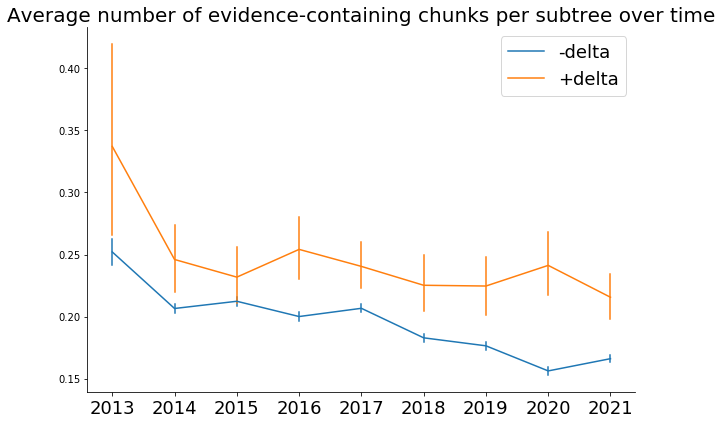

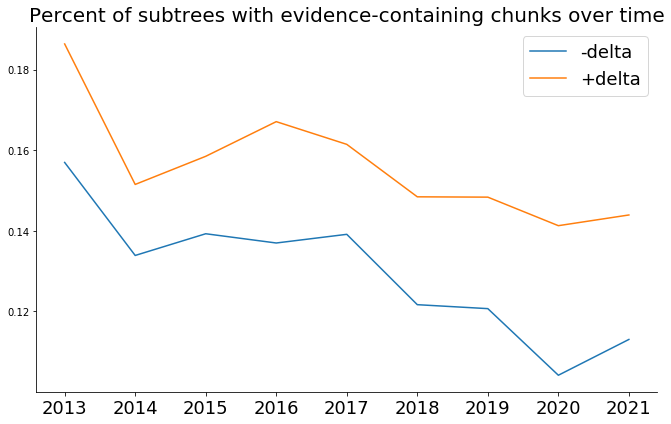

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_evidence_chunks',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of evidence-containing chunks per subtree over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_num_evidence_chunks_per_subtree_over_time.png',dpi=200)

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='pct_subtrees',hue='outcome',
             data=to_plot_df2.loc[to_plot_df2['has_evidence']].sort_values('outcome',ascending=False),
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Percent of subtrees with evidence-containing chunks over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/pct_subtrees_w_evidence_chunks_over_time.png',dpi=200)

## Manual inspection of +/-evidence comments

In [27]:
examples_per_label = defaultdict(list)
for key in tqdm(model_preds_dict):
    utt_id, chunk_no = key.split('|')
    utt = get_utt(utt_id)
    utt_chunks = utt.meta['chunks']
    text = utt_chunks[int(chunk_no)]
    pred = model_preds_dict[key]
    examples_per_label[pred].append(text)
for label in examples_per_label:
    print(label, len(examples_per_label[label]))

100%|██████████| 472000/472000 [00:03<00:00, 123229.02it/s]

1 162260
0 309740


In [30]:
np.random.choice(a=examples_per_label[1], size=100, replace=False)

array(["Somehow I feel like you havnt actually looked into this much. You claim to want scientific stances, research, or information a teacher could use so here is a place to start.\nhttps://www.google.com/url?sa=t&source=web&rct=j&url=https://www.apa.org/about/policy/resolution-gender-identity-change-efforts.pdf&ved=2ahUKEwiYuIW31MLxAhUUPH0KHbJtDHcQFjABegQIBBAG&usg=AOvVaw1Y9WOuG0mdpLRaB4Y-nsDT\nAnd\nIf you want a specific example of a decision well...here's here's apa page.",
       'Even science is corrupt. Look at the top doctor in America mr Fauci.',
       'That\'s contradictory. The GameJurnoPros mailing list shows a very worryingly close and secretive relationship between all of these outlets, which is what the problem was in the first place. The developers were very close friends with the journalists themselves, and when they got called on it, they used that very mailing list to coordinate the "gamers are dead" articles to try and bury the issue in the ensuing chaos.',
       '

In [31]:
np.random.choice(a=examples_per_label[0], size=100, replace=False)

array(['The whole "we are wired through evolution" argument is really pseudo-science that feels rational but isn\'t. I see it used a little too often on Reddit.\nAnd in any case, you\'ll note that I did say "Western society".\nBut as long as we can act decently, why shouldn\'t we?',
       "1. It's not Zero-Sum.\nYour mistake is to assume we live in a zero-sum society .This would be true if it were 800 years ago, and lords were battling eachother for land and serfs. But despite what your Liberal Arts Professor probabaly told you, the modern world is demonstrably a positive-sum.  Having a billion dollars doesn't mean you took a billion dollars, it means people gave you a billion dollars in exchange for goods or services they valued equally or greater than a billion dollars. Now a days, our goods are manufactured or replaced by services, only a few are found and extracted directly from nature.",
       '"that none of the information critical to finding him was solely retrieved via waterb

# Further correlation studies on comment-level data to understand how evidence features differ

In [5]:
BIN_EV_FEATS = ['has_url','has_evidence_kw','has_evidence']
COUNT_EV_FEATS = ['num_urls','num_evidence_kws','num_evidence_chunks']

In [6]:
import re
with open('../2_data_exploration/sci_ents.txt','r') as f:
    sci_ents = f.read().splitlines()
sci_ents.append('doctor')
KWS = set([e.replace('_',' ') for e in sci_ents if e not in {'Dr.'}])
#KWS.remove
print(f"Using {len(KWS)} science/evidence-related keywords for search.")
KW_PATT = re.compile('|'.join(['\\b'+kw for kw in KWS]), re.IGNORECASE)

def contains_kw(s, patt=KW_PATT, verbose=False):
    res = re.search(patt, s)
    if verbose:
        print(res)
    return res != None

def count_kws(s, patt=KW_PATT, verbose=False):
    res = re.findall(patt, s)
    if verbose:
        print(res)
    return len(res)

Using 104 science/evidence-related keywords for search.


In [8]:
# ADD KEYWORD-BASED AND MODEL-PREDICTED EVIDENTIALITY FEATURES

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['evidence_in_chunks?'] = {}

model_preds_dict = pickle.load(open('model_preds_kw_chunks_full_cmv.pkl','rb'))
for key in model_preds_dict:
    utt_id, chunk_no = key.split('|')
    utt = get_utt(utt_id)
    utt.meta['evidence_in_chunks?'][chunk_no] = model_preds_dict[key]
del model_preds_dict

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if meets_datapoint_criteria(utt): # exclude OP by default
        utt.meta['num_evidence_chunks'] = sum([int(b) 
                                                            for b in utt.meta['evidence_in_chunks?'].values()])
        utt.meta['has_evidence'] = utt.meta['num_evidence_chunks'] > 0
        utt.meta['num_evidence_kws'] = count_kws(utt.text)
        utt.meta['has_evidence_kw'] = utt.meta['num_evidence_kws'] > 0

3243830it [00:24, 131137.18it/s]
3243830it [24:54, 2170.60it/s]


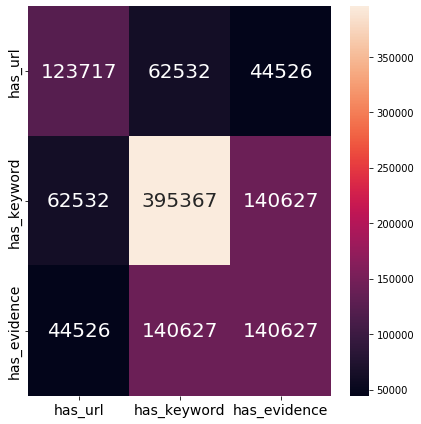

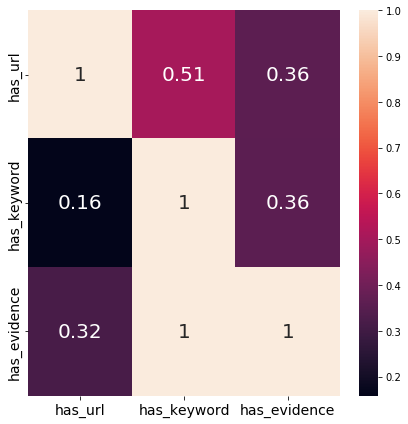

In [43]:
# CHECK QUANTITATIVE DIFFERENCES/OVERLAP IN COMMENTS DETECTED BY `has_evidence`, `has_evidence_kw`, `has_url`

utts_per_feat = {
    feat: {utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
           if meets_datapoint_criteria(utt) and (utt.meta[feat]==True)}
    for feat in BIN_EV_FEATS}

def get_amt_overlap(feat1_utts,feat2_utts):
    overlap = feat1_utts.intersection(feat2_utts)
    return {'raw':len(overlap), 'norm1':len(overlap)/len(feat1_utts), 'norm2':len(overlap)/len(feat2_utts)}

pairwise_overlaps = {
    feat1: {feat2: get_amt_overlap(utts_per_feat[feat1],utts_per_feat[feat2]) for feat2 in BIN_EV_FEATS}
    for feat1 in BIN_EV_FEATS}
to_plot = pd.DataFrame(pairwise_overlaps)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(to_plot.applymap(lambda x: x['raw']).T,annot=True,fmt="d",ax=ax,annot_kws={'fontsize':20})
ax.set_xticklabels(['has_url','has_keyword','has_evidence'],fontsize=14)
ax.set_yticklabels(['has_url','has_keyword','has_evidence'],fontsize=14)
plt.tight_layout()
plt.savefig('figs/raw_overlap_evidence_features.png',dpi=200)

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(to_plot.applymap(lambda x: x['norm1']).T,annot=True,ax=ax,annot_kws={'fontsize':20})
ax.set_xticklabels(['has_url','has_keyword','has_evidence'],fontsize=14)
ax.set_yticklabels(['has_url','has_keyword','has_evidence'],fontsize=14)
plt.tight_layout()
plt.savefig('figs/normalized_overlap_evidence_features.png',dpi=200)

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 61185 valid corpus components. class2_func returned 332835 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


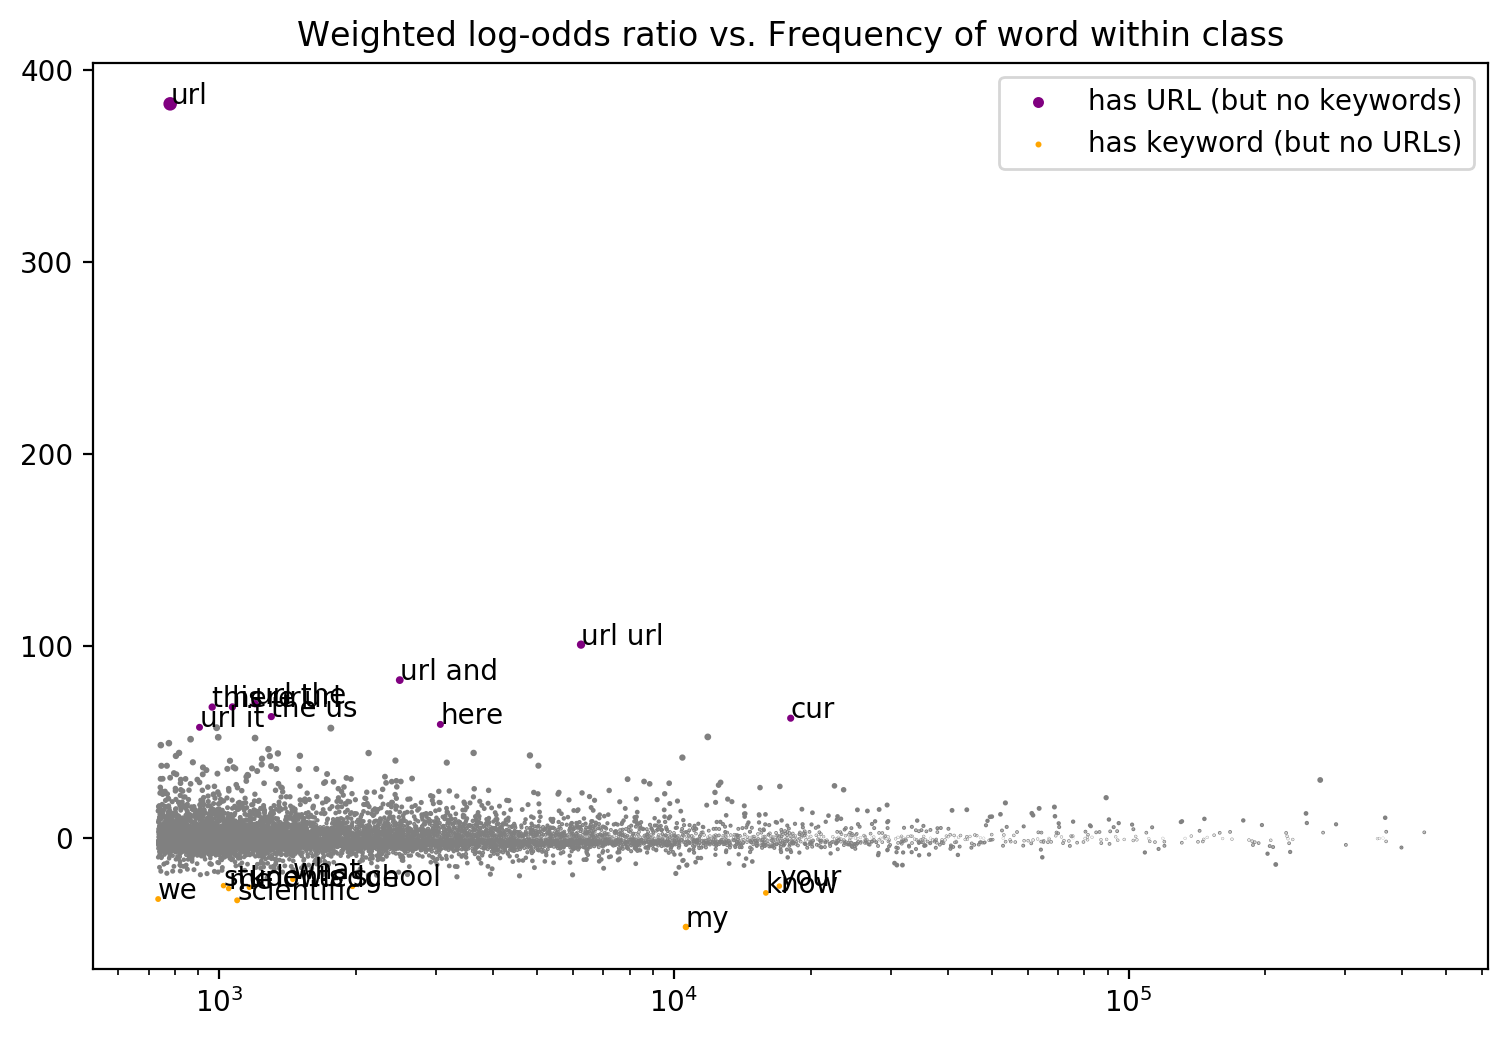

,z-score,class
ngram,,
my,-46.360668,has keyword (but no URLs)
scientific,-32.494430,has keyword (but no URLs)
we,-31.815814,has keyword (but no URLs)
know,-28.634544,has keyword (but no URLs)
me,-26.342439,has keyword (but no URLs)
knowledge,-25.695944,has keyword (but no URLs)
school,-25.227865,has keyword (but no URLs)
your,-25.079999,has keyword (but no URLs)
students,-24.856853,has keyword (but no URLs)


,z-score,class
ngram,,
url it,57.604228,has URL (but no keywords)
here,59.105587,has URL (but no keywords)
cur,62.350803,has URL (but no keywords)
the us,63.172553,has URL (but no keywords)
this url,68.130083,has URL (but no keywords)
here url,68.208349,has URL (but no keywords)
url the,69.901469,has URL (but no keywords)
url and,82.182478,has URL (but no keywords)
url url,100.651856,has URL (but no keywords)


In [9]:
# CHECK DIFFERENCES IN WORDS DETECTED BY `has_evidence`, `has_evidence_kw`, `has_url`

# Do pairwise comparisons w/ LOR for every feature pair, where one is True and other is False
from convokit import FightingWords

url_vs_kw = FightingWords(ngram_range=(1,3))
url_vs_kw.fit(corp_to_analyze['full_cmv'], 
       class1_func=lambda utt: meets_datapoint_criteria(utt) and \
                               (utt.meta['has_url']==True) and (utt.meta['has_evidence_kw']==False), 
       class2_func=lambda utt: meets_datapoint_criteria(utt) and \
                               (utt.meta['has_url']==False) and (utt.meta['has_evidence_kw']==True),)
url_vs_kw_df = url_vs_kw.summarize(corp_to_analyze['full_cmv'], plot=True, 
                  class1_name='has URL (but no keywords)', 
                  class2_name='has keyword (but no URLs)')
c1, c2 = url_vs_kw.get_ngrams_past_threshold(threshold=1)
display(url_vs_kw_df.head(10))
display(url_vs_kw_df.tail(10))

In [21]:
pd.set_option('display.max_rows', None)
url_vs_kw_df.tail(100)

,z-score,class
ngram,,
germany,25.733400,has URL (but no keywords)
to promote,26.060618,has URL (but no keywords)
be found,26.162955,has URL (but no keywords)
slavery,26.193668,has URL (but no keywords)
uk,26.324552,has URL (but no keywords)
republican,26.463382,has URL (but no keywords)
vote,26.478340,has URL (but no keywords)
wiki,26.518036,has URL (but no keywords)
websites,26.602772,has URL (but no keywords)


Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 79191 valid corpus components. class2_func returned 96101 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


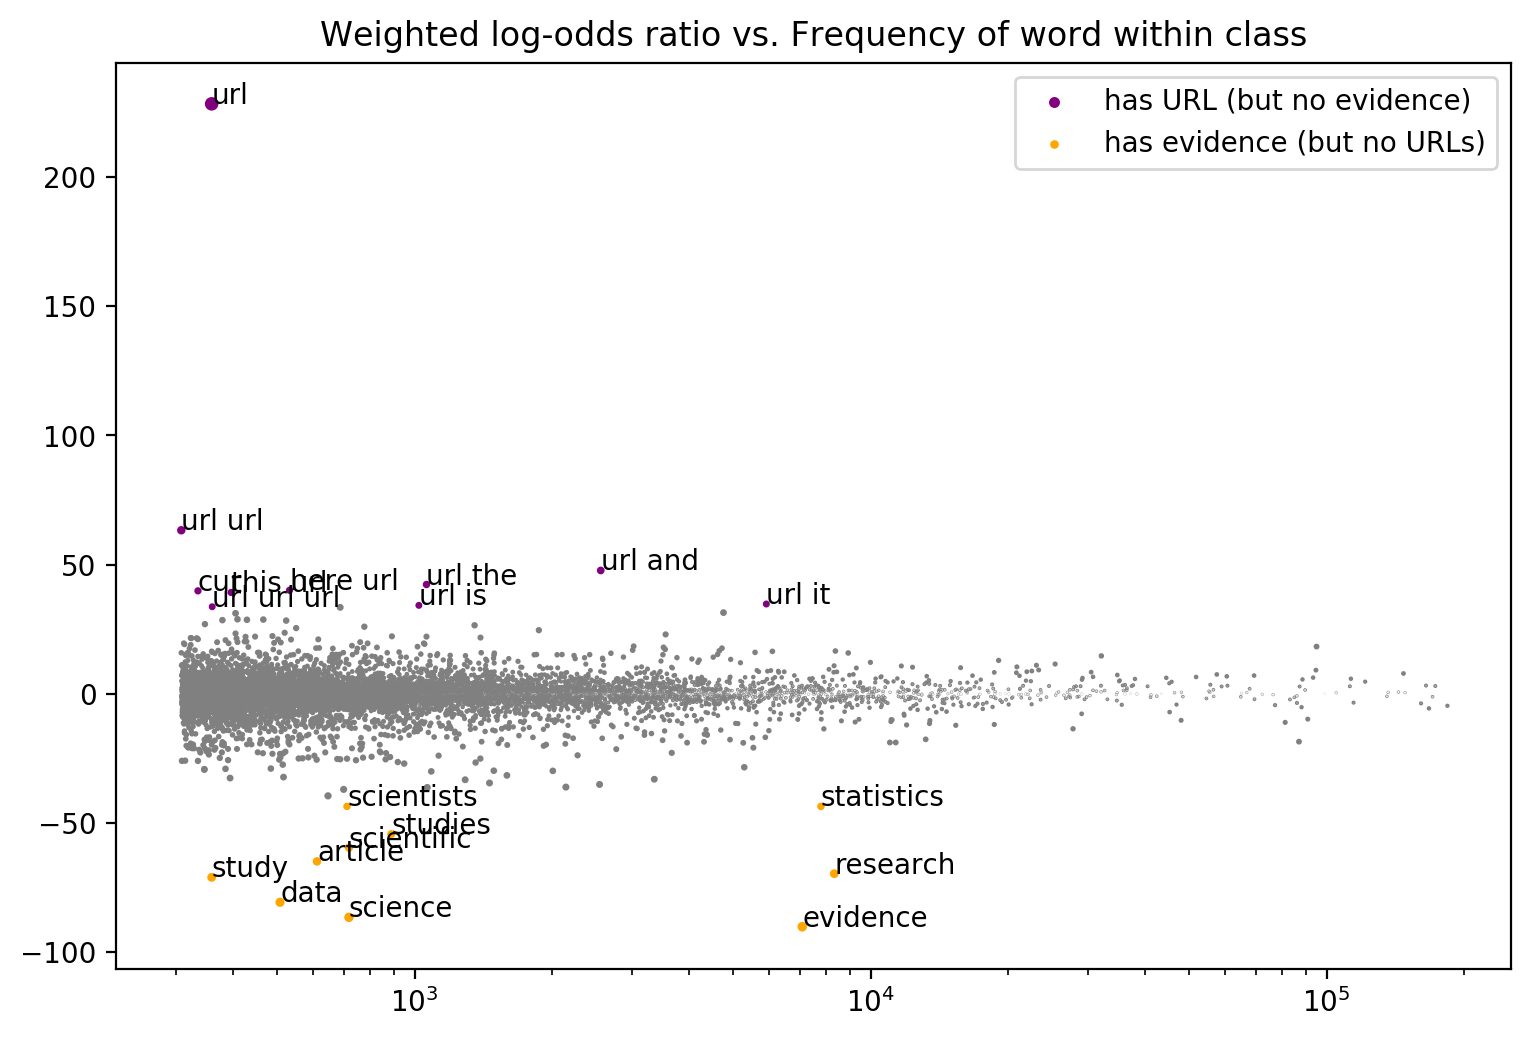

,z-score,class
ngram,,
evidence,-90.308465,has evidence (but no URLs)
science,-86.662128,has evidence (but no URLs)
data,-80.832241,has evidence (but no URLs)
study,-71.182680,has evidence (but no URLs)
research,-69.755011,has evidence (but no URLs)
article,-64.994649,has evidence (but no URLs)
scientific,-59.655807,has evidence (but no URLs)
studies,-54.431927,has evidence (but no URLs)
statistics,-43.703403,has evidence (but no URLs)


,z-score,class
ngram,,
url url url,33.655009,has URL (but no evidence)
url is,34.193712,has URL (but no evidence)
url it,34.717692,has URL (but no evidence)
this url,39.195789,has URL (but no evidence)
cur,39.813612,has URL (but no evidence)
here url,40.039507,has URL (but no evidence)
url the,42.274621,has URL (but no evidence)
url and,47.702018,has URL (but no evidence)
url url,63.279919,has URL (but no evidence)


In [10]:
url_vs_ev = FightingWords(ngram_range=(1,3))
url_vs_ev.fit(corp_to_analyze['full_cmv'], 
              class1_func=lambda utt: meets_datapoint_criteria(utt) and \
                                      (utt.meta['has_url']==True) and (utt.meta['has_evidence']==False), 
              class2_func=lambda utt: meets_datapoint_criteria(utt) and \
                                      (utt.meta['has_url']==False) and (utt.meta['has_evidence']==True),)
url_vs_ev_df = url_vs_ev.summarize(corp_to_analyze['full_cmv'], plot=True, 
                                   class1_name='has URL (but no evidence)', 
                                   class2_name='has evidence (but no URLs)')
c1, c2 = url_vs_ev.get_ngrams_past_threshold(threshold=1)
display(url_vs_ev_df.head(10))
display(url_vs_ev_df.tail(10))

In [24]:
url_vs_ev_df.head(100)

,z-score,class
ngram,,
evidence,-90.308465,has evidence (but no URLs)
science,-86.662128,has evidence (but no URLs)
data,-80.832241,has evidence (but no URLs)
study,-71.182680,has evidence (but no URLs)
research,-69.755011,has evidence (but no URLs)
article,-64.994649,has evidence (but no URLs)
scientific,-59.655807,has evidence (but no URLs)
studies,-54.431927,has evidence (but no URLs)
statistics,-43.703403,has evidence (but no URLs)


Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 254740 valid corpus components. class2_func returned 140627 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


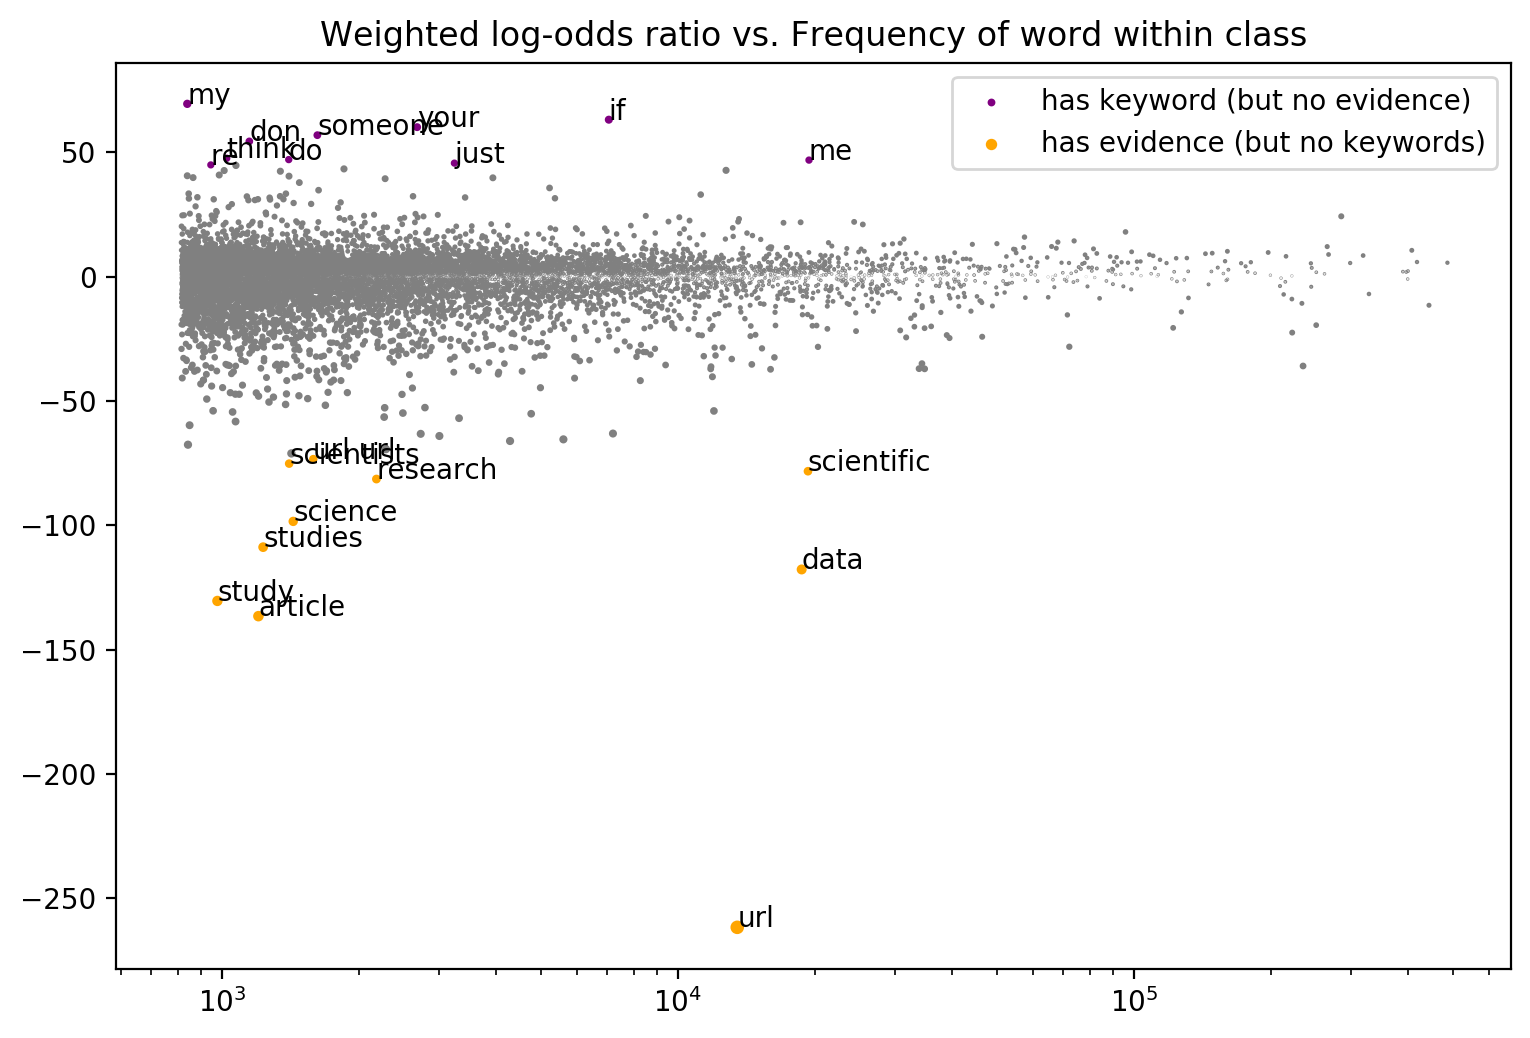

,z-score,class
ngram,,
url,-261.735915,has evidence (but no keywords)
article,-136.578599,has evidence (but no keywords)
study,-130.458828,has evidence (but no keywords)
data,-117.794344,has evidence (but no keywords)
studies,-108.828878,has evidence (but no keywords)
science,-98.469793,has evidence (but no keywords)
research,-81.431092,has evidence (but no keywords)
scientific,-78.285616,has evidence (but no keywords)
scientists,-75.226494,has evidence (but no keywords)


,z-score,class
ngram,,
re,44.921300,has keyword (but no evidence)
just,45.629354,has keyword (but no evidence)
me,46.851078,has keyword (but no evidence)
do,47.050234,has keyword (but no evidence)
think,47.585494,has keyword (but no evidence)
don,54.380737,has keyword (but no evidence)
someone,56.878438,has keyword (but no evidence)
your,60.096124,has keyword (but no evidence)
if,63.102904,has keyword (but no evidence)


In [12]:
kw_vs_ev = FightingWords(ngram_range=(1,3))
kw_vs_ev.fit(corp_to_analyze['full_cmv'], 
              class1_func=lambda utt: meets_datapoint_criteria(utt) and \
                                      (utt.meta['has_evidence_kw']==True) and (utt.meta['has_evidence']==False), 
              class2_func=lambda utt: meets_datapoint_criteria(utt) and (utt.meta['has_evidence']==True),)
kw_vs_ev_df = kw_vs_ev.summarize(corp_to_analyze['full_cmv'], plot=True, 
                                 class1_name='has keyword (but no evidence)', 
                                 class2_name='has evidence (but no keywords)')
c1, c2 = kw_vs_ev.get_ngrams_past_threshold(threshold=1)
display(kw_vs_ev_df.head(10))
display(kw_vs_ev_df.tail(10))

In [27]:
kw_vs_ev_df.head(100)

,z-score,class
ngram,,
url,-261.735915,has evidence (but no keywords)
article,-136.578599,has evidence (but no keywords)
study,-130.458828,has evidence (but no keywords)
data,-117.794344,has evidence (but no keywords)
studies,-108.828878,has evidence (but no keywords)
science,-98.469793,has evidence (but no keywords)
research,-81.431092,has evidence (but no keywords)
scientific,-78.285616,has evidence (but no keywords)
scientists,-75.226494,has evidence (but no keywords)


In [28]:
kw_vs_ev_df.tail(100)

,z-score,class
ngram,,
maybe,21.046542,has keyword (but no evidence)
they re,21.122047,has keyword (but no evidence)
it not,21.281496,has keyword (but no evidence)
but you,21.306582,has keyword (but no evidence)
don think,21.459790,has keyword (but no evidence)
moral,21.555796,has keyword (but no evidence)
right to,21.637352,has keyword (but no evidence)
classes,21.672014,has keyword (but no evidence)
bad,21.699003,has keyword (but no evidence)


In [6]:
def get_path_to_outcome(subtree_outcome_utt, excl_OP=True):
    if excl_OP:
        path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
        path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                      if get_utt(u_id).meta['meets_datapoint_crit_excl_OP']]
    else:
        path_to_outcome = subtree_outcome_utt.meta['path_to_outcome']
        path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome
                                          if get_utt(u_id).meta['meets_datapoint_crit_with_OP']]
    return path_to_outcome_valid_utts

def get_subtree_score(feat, model_type, subtree_outcome_utt, excl_OP=True, get_text=False):
    """
    Returns the subtree-level score for a given feature `feat`, model type `model_type`, and subtree
    as indexed by its outcome utt `subtree_outcome_utt` by taking the sum of the component comments' values
    (excl.) OP's.
    """
    if feat == 'senti_pos_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][0]
    elif feat == 'senti_neg_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][1]
    elif feat in {'depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp'}:
        return subtree_outcome_utt.meta['reg_feats'][feat]
    else:
        if excl_OP:
            path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                          if get_utt(u_id).meta['meets_datapoint_crit_excl_OP']]
        else:
            path_to_outcome = subtree_outcome_utt.meta['path_to_outcome']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome
                                          if get_utt(u_id).meta['meets_datapoint_crit_with_OP']]
            
        if get_text:
            subtree_text = [get_utt(u_id).text for u_id in path_to_outcome_valid_utts]
            return subtree_text
        
        if model_type == None:
            return sum([get_utt(u_id).meta['reg_feats'][feat] for u_id in path_to_outcome_valid_utts])
        else:
            return sum([get_utt(u_id).meta['reg_feats'][f'{feat}_{model_type}'] 
                        for u_id in path_to_outcome_valid_utts])

In [ ]:
reg_df = pd.read_pickle('full_cmv_subtrees_reg_df.pkl')
print(f"Read in regression df w/ {len(reg_df)} rows.")
reg_df['path_to'] = reg_df['subtree_outcome_utt_id'].apply(lambda x:
                                                              get_path_to_outcome(get_utt(x))) # excluding OP
reg_df = reg_df.loc[reg_df['path_to'].apply(lambda x: len(x) > 0)].copy()
print(f"Subsetted to {len(reg_df)} datapoints with at least one valid non-OP comment in subtree.")

reg_df['subtree_text'] = reg_df['subtree_outcome_utt_id'].apply(
    lambda x: get_subtree_score(None, None, get_utt(x), get_text=True))
# reg_df['counted_lemmas_all'] = reg_df['path_to'].apply(lambda x: get_counted_lemmas(x, 'all'))
# reg_df['counted_lemmas_adxs'] = reg_df['path_to'].apply(lambda x: get_counted_lemmas(x, 'adxs_only'))
# for model in tqdm(['all','adxs']):
#     reg_df[f'counted_nrc_{model}'] = reg_df[f'counted_lemmas_{model}'].apply(lambda x: x['nrc'])
#     reg_df[f'counted_emo_{model}'] = reg_df[f'counted_lemmas_{model}'].apply(lambda x: x['emo'])
#del nrc_cache
#del emolex_cache

# Get overall emotion intensity score by summing over 8 emotions
for model in ['all','adxs_only']:
    reg_df[f'emo_total_{model}'] = reg_df[f'emo_fear_{model}'] + reg_df[f'emo_anger_{model}'] + \
                                   reg_df[f'emo_sadness_{model}'] + reg_df[f'emo_disgust_{model}'] + \
                                   reg_df[f'emo_joy_{model}'] + reg_df[f'emo_anticipation_{model}'] + \
                                   reg_df[f'emo_trust_{model}'] + reg_df[f'emo_surprise_{model}']
    
# Take absolute value of SS neg. arousal
for model in ['all','adxs_only']:
    reg_df[f'senti_neg_arousal_{model}'] = abs(reg_df[f'senti_neg_arousal_{model}'])
    
# Log transform count variables
COUNT_VARS = ['total_num_words','mean_num_words','rel_timestamp','abs_timestamp',
              'num_urls','num_evidence_kws','num_evidence_chunks',
              'emo_total_all','nrc_val_all','nrc_arousal_all',
              'emo_total_adxs_only','nrc_val_adxs_only','nrc_arousal_adxs_only']
SMOOTHING = 0.1
for count_var in COUNT_VARS:
        reg_df[f'log_{count_var}'] = np.log(reg_df[count_var]+SMOOTHING)
    
# Get dummy variables for `has_evidence`, `has_evidence_kw`, `has_url`, `outcome`
reg_df['has_evidence'] = reg_df['num_evidence_chunks'].apply(lambda x: x>0)
reg_df['has_evidence_kw'] = reg_df['num_evidence_kws'].apply(lambda x: x>0)
reg_df['has_url'] = reg_df['num_urls'].apply(lambda x: x>0)
reg_df = pd.get_dummies(reg_df, columns=['has_evidence','has_evidence_kw','has_url','outcome'], drop_first=True)
reg_df['outcome'] = reg_df['outcome_-delta'].apply(lambda x: abs(1-x))

print(reg_df.shape) # the # of (outcome) subtrees
display(reg_df.head(10))

## Log odds to compare words found in evidence-chunks but not in urls/keywords and vice versa

### By POS: verbs, adjs, etc.